In [ ]:
! pip install datasets
! pip install transformers
! pip install evaluate
! pip install hyperopt
! pip install "ray[tune]" scipy sklearn torch tqdm
import datasets
import random
import os
from urllib import request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline, AutoModelForSeq2SeqLM
import torch
from tqdm import tqdm, trange

In [ ]:
# Handle GPU Settings
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
# CONSTANTS

PRETRAINED_MODEL = "distilbert-base-uncased"

TRAINING_DATA_PATH = "./dontpatronizeme_pcl_training.tsv"
DEV_DATA_PATH = "./dontpatronizeme_pcl_dev.tsv"
TEST_DATA_PATH = "./task4_test.tsv"

df = pd.read_csv(TRAINING_DATA_PATH, sep='\t')
df_dev = pd.read_csv(DEV_DATA_PATH, sep='\t')
df_test = pd.read_csv(TEST_DATA_PATH, sep='\t')

BINARY_CLASSES_MODE = False # Make sure the model trains as though there were only 2 classes

pcl_labels = [
    'Unbalanced_power_relations',
    'Shallow_solution',
    'Presupposition',
    'Authority_voice',
    'Metaphors',
    'Compassion',
    'The_poorer_the_merrier',
]

## Analysis of Dataset

In [ ]:
# Plot graph of Frequency of Class Labels
fig, ax = plt.subplots()
df['label'].value_counts()[df['label'].unique()].plot(ax=ax, kind='bar', xlabel='labels', ylabel='frequency')
plt.show()
plt.savefig('label_frequency.png')

<AxesSubplot:xlabel='label'>

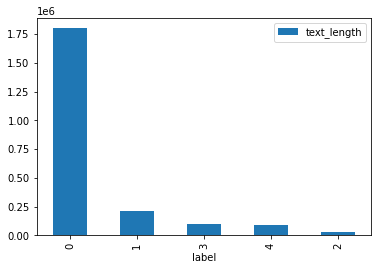

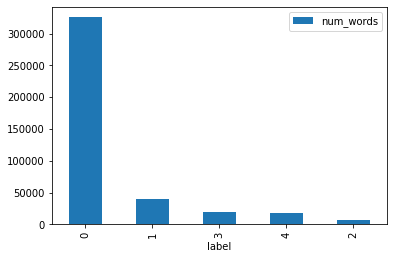

In [ ]:
df['text_length'] = [len(txt) for txt in df['text']]

# Plot graph of Class Labels v/s text length
txt_lengths = df.groupby(["label"]).text_length.sum().reset_index().sort_values('text_length', ascending=False)
txt_lengths.plot(x="label", y="text_length", kind="bar")


# Plot graph of Class Labels v/s num, words
df['num_words'] = [len(txt.split()) for txt in df['text']]
num_words = df.groupby(["label"]).num_words.sum().reset_index().sort_values('num_words', ascending=False)
num_words.plot(x="label", y="num_words", kind="bar")


Total Number of Countries: 20


<AxesSubplot:xlabel='country code', ylabel='frequency'>

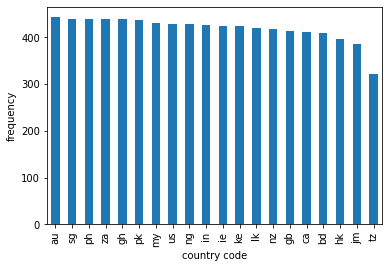

In [ ]:
# Plot graph of Which Country the text originates most from
fig, ax = plt.subplots()
print("Total Number of Countries:", len(df['country_code'].unique()))
df['country_code'].value_counts().plot(ax=ax, kind='bar', xlabel='country code', ylabel='frequency')

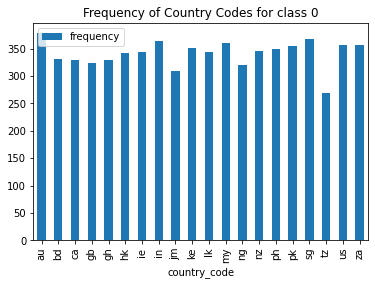

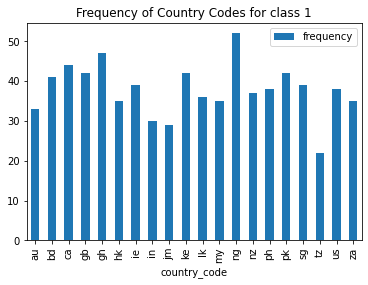

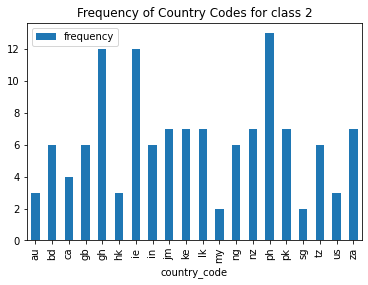

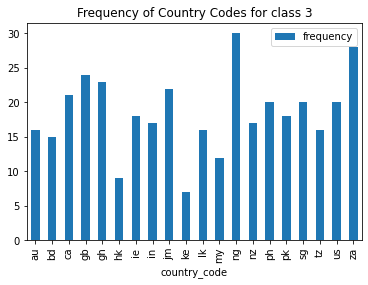

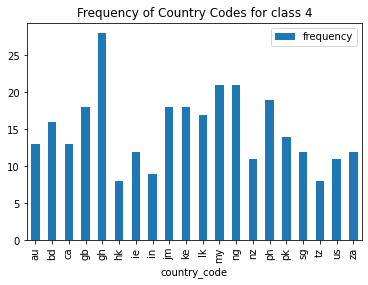

In [ ]:
# Plot for each class, which country is most present
labels_by_country = df.groupby(["label", "country_code"]).size().reset_index()
labels_by_country.rename(columns={0: 'frequency'}, inplace=True)

for cls in labels_by_country['label'].unique():
  tbl = labels_by_country[labels_by_country['label'] == cls].sort_values('country_code', ascending=True)
  tbl.plot(y="frequency", x='country_code', kind='bar', title=f"Frequency of Country Codes for class {cls}")

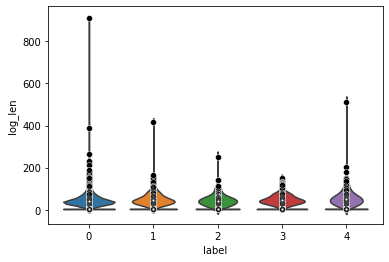

In [ ]:
import math
import seaborn as sns

df_copy = df.copy() 
 
# def len_list(len):  
#   if len > 60:
#     return ">60"
#   elif len <=60 and len>42:
#     return "42-60"
#   elif len <=42 and len>30:
#     return '30-42'
#   else:
#     return "<=30"

df_copy['len'] = df_copy.apply (lambda row: (int(len(row['text'].split()))), axis=1)
# drop zero length text
df_copy = df_copy.drop(df_copy.index[df_copy.len ==0])
# log length
df_copy['Log of Text Length In Words'] = df_copy.apply (lambda row: math.log(int(len(row['text'].split()))), axis=1)

df_copy['Text Length In Words'] = df_copy.apply (lambda row: row.len, axis=1)

sns.violinplot(x ='label', y ='Text Length In Words', data = df_copy)
sns.scatterplot(x ='label', y ='Text Length In Words', data = df_copy, color ='black')
plt.savefig('length_vs_label.png')

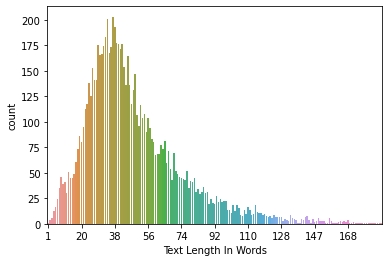

In [ ]:
df_copy = df.copy()
df_copy['Text Length In Words'] = df_copy.apply (lambda row: (int(len(row['text'].split()))), axis=1)
ax = sns.countplot(x='Text Length In Words',data=df_copy)
ax.set_xticks([1 * x for x in range(10)])
plt.savefig('text_length_distribution.png')

## Preprocessing

In [ ]:
def random_replacement_augmentation(df):
  fillmask = pipeline("fill-mask", model="roberta-base")
  mask_token = fillmask.tokenizer.mask_token

  def make_new_text(txt):
    words = txt.split(' ')
    if len(words) <= 1:
      return txt
    K = random.randint(1, len(words) - 1)
    masked_text = " ".join(words[:K] + [mask_token] + words[K+1:])
    predictions = fillmask(masked_text)
    original_word = words[K]
    augmented_text = ""
    for pred in predictions:
      if pred["token_str"].strip() != original_word:
        augmented_text = pred['sequence']
        break
    return augmented_text
  
  df["text"] = df["text"].map(make_new_text)
  return df

def back_translation_augmentation(df):
  translator_en_to_fr = pipeline("translation_en_to_fr", model="t5-base", max_length=500)
  model_name = "Helsinki-NLP/opus-mt-fr-en"
  model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
  model.to(device)

  tokenizer = AutoTokenizer.from_pretrained(model_name)

  def translate(txt):
    en_to_fr_output = translator_en_to_fr(txt)
    translated_txt = en_to_fr_output[0]["translation_text"]
    input_ids = tokenizer.encode(translated_txt, return_tensors="pt").to(device)
    outputs = model.generate(input_ids, max_length=512)
    augmented_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return augmented_text

  df["text"] = df["text"].map(translate)
  return df

In [ ]:
""" PREPROCESS """

# num_classes = len(df['label'].unique()) if not BINARY_CLASSES_MODE else 2

def preprocess(df):
  # drop rows with empty text
  df = df.dropna(subset=['text'])
  df = df.reset_index(drop=True)

  # drop rows with empty labels
  df = df[df['label'] != '']
  df = df.reset_index(drop=True)
  df = df[['text', 'label', 'par_id']]

  # if BINARY_CLASSES_MODE:
  #   df.loc[df['label'].isin([2, 3, 4]), 'label'] = 1
  #   df.loc[df['label'].isin([0, 1]), 'label'] = 0

  # Run Text Augmentation
  # df = random_replacement_augmentation(df)
  # df = back_translation_augmentation(df)

  # if classes are only 2
  return df

df = preprocess(df)
df_dev = preprocess(df_dev)
df_test = df_test[["par_id", "span_text"]]

df.head()

,text,label,par_id
0,"We 're living in times of absolute insanity , ...",0,1
1,"In Libya today , there are countless number of...",0,2
2,White House press secretary Sean Spicer said t...,0,3
3,Council customers only signs would be displaye...,0,4
4,""" Just like we received migrants fleeing El Sa...",0,5


In [ ]:
# equal_df = df.groupby("label").apply(lambda x: x.sample(n=200, replace=True)).reset_index(drop = True)
# equal_df.head()

,text,label,par_id
0,Bangladeshi Muslim immigrants living in the no...,0,6073
1,"In 2015 alone , approximately 163,000 individu...",0,4988
2,Volunteers are demanding answers from the gove...,0,6394
3,"Presently , what aspect of smart cities do you...",0,1370
4,"China , which along with Russia is a major sup...",0,4763


In [ ]:
from sklearn.model_selection import train_test_split
from datasets import DatasetDict, Dataset

# Create a dataset from the pandas dataframe
train = Dataset.from_dict({"text": df["text"], "label": df["label"], "par_id": df["par_id"]})
validation = Dataset.from_dict({"text": df_dev["text"], "label": df_dev["label"], "par_id": df_dev["par_id"]})
test = Dataset.from_dict({"text": df_test["span_text"], "par_id": df_test["par_id"]})

dataset = DatasetDict({"train": train, "validation": validation, "test": test})

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'par_id'],
        num_rows: 8375
    })
    validation: Dataset({
        features: ['text', 'label', 'par_id'],
        num_rows: 2093
    })
    test: Dataset({
        features: ['text', 'par_id'],
        num_rows: 3832
    })
})

## Tokenization

In [ ]:
from transformers import AutoTokenizer, DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset.set_format("torch")

train_dataset = tokenized_dataset["train"].shuffle(seed=42)
validation_dataset = tokenized_dataset["validation"].shuffle(seed=42)

Map:   0%|          | 0/8375 [00:00<?, ? examples/s]

Map:   0%|          | 0/2093 [00:00<?, ? examples/s]

Map:   0%|          | 0/3832 [00:00<?, ? examples/s]

## Initiating Training

In [16]:
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, EvalPrediction
from datasets import load_metric
from sklearn.metrics import f1_score
# from ray.tune.suggest.hyperopt import HyperOptSearch
# from ray.tune.schedulers import ASHAScheduler
 
def compute_metrics(eval_pred: EvalPrediction):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")
   preds, labels = eval_pred
   print("eval_pred", eval_pred)
   predictions = np.argmax(preds, axis=-1)

   normalized_preds = (predictions >= 2).astype(int)
   normalized_truth = (labels >= 2).astype(int)
   f1score = f1_score(normalized_truth, normalized_preds)

   # f1 = load_f1.compute(predictions=predictions, references=labels, average=None)["f1"]
   # score = {f"class{k}":v for k,v in zip(range(5), f1)}
   # acc = {"accuracy": accuracy}
  
   return {"f1": f1score}

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(PRETRAINED_MODEL, num_labels=5)

training_args = TrainingArguments(
  output_dir="finetuned_dontpatronizeme_model",
  evaluation_strategy="epoch",
  learning_rate=1e-5,
  per_device_train_batch_size=32,
  per_device_eval_batch_size=32,
  num_train_epochs=10,
  weight_decay=0.1,
  save_strategy="epoch",
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


## Vanilla Training

In [ ]:
trainer = Trainer(
  model_init=model_init,
  args=training_args,
  train_dataset=train_dataset,
  eval_dataset=validation_dataset,
  tokenizer=tokenizer,
  data_collator=data_collator,
  compute_metrics=compute_metrics,
)

trainer.train()

In [15]:
res = trainer.evaluate()
res

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: par_id, text. If par_id, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2093
  Batch size = 32


{'eval_loss': 0.6919258832931519,
 'eval_accuracy': 0.8041089345437171,
 'eval_class0': 0.9155453764672202,
 'eval_class1': 0.2094240837696335,
 'eval_class2': 0.0,
 'eval_class3': 0.22972972972972971,
 'eval_class4': 0.37241379310344824,
 'eval_runtime': 10.7226,
 'eval_samples_per_second': 195.195,
 'eval_steps_per_second': 6.155,
 'epoch': 10.0}

## Hyperparameter Search - Basic

In [ ]:
# !pip install "ray[tune]"
from ray import tune

def ray_hp_space(trial):
  return {
      "learning_rate": tune.loguniform(1e-5, 1e-2),
      "per_device_train_batch_size": tune.choice([16, 32, 64, 128]),
  }

trainer = Trainer(
  model_init=model_init,
  args=training_args,
  train_dataset=train_dataset,
  eval_dataset=validation_dataset,
  tokenizer=tokenizer,
  data_collator=data_collator,
  compute_metrics=compute_metrics,
)

best_run = trainer.hyperparameter_search(
    direction="maximize", 
    backend="ray", 
    hp_space=ray_hp_space,
    n_trials=1
)

best_run

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin

== Status ==
Current time: 2023-03-08 11:41:27 (running for 00:00:00.04)
Memory usage on this node: 6.9/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |
|                        |          |                  |                 |                ch_size |
|------------------------+----------+------------------+-----------------+------------------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |
+------------------------+----------+------------------+-----------------+------------------------+




(_objective pid=2697) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
(_objective pid=2697) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=2697) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=2697) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-unc

== Status ==
Current time: 2023-03-08 11:41:37 (running for 00:00:09.93)
Memory usage on this node: 9.3/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |
|                        |          |                  |                 |                ch_size |
|------------------------+----------+------------------+-----------------+------------------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |
+------------------------+----------+------------------+-----------------+------------------------+




  3%|▎         | 91/2620 [00:06<02:14, 18.79it/s]


== Status ==
Current time: 2023-03-08 11:41:42 (running for 00:00:14.93)
Memory usage on this node: 9.3/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |
|                        |          |                  |                 |                ch_size |
|------------------------+----------+------------------+-----------------+------------------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |
+------------------------+----------+------------------+-----------------+------------------------+




  7%|▋         | 183/2620 [00:11<02:25, 16.74it/s]


== Status ==
Current time: 2023-03-08 11:41:47 (running for 00:00:19.93)
Memory usage on this node: 9.4/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |
|                        |          |                  |                 |                ch_size |
|------------------------+----------+------------------+-----------------+------------------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |
+------------------------+----------+------------------+-----------------+------------------------+




 10%|█         | 269/2620 [00:16<02:17, 17.09it/s]


== Status ==
Current time: 2023-03-08 11:41:52 (running for 00:00:24.94)
Memory usage on this node: 9.4/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |
|                        |          |                  |                 |                ch_size |
|------------------------+----------+------------------+-----------------+------------------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |
+------------------------+----------+------------------+-----------------+------------------------+




 14%|█▎        | 359/2620 [00:21<02:25, 15.59it/s]


== Status ==
Current time: 2023-03-08 11:41:57 (running for 00:00:29.94)
Memory usage on this node: 9.4/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |
|                        |          |                  |                 |                ch_size |
|------------------------+----------+------------------+-----------------+------------------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |
+------------------------+----------+------------------+-----------------+------------------------+




 17%|█▋        | 444/2620 [00:26<02:15, 16.09it/s]


== Status ==
Current time: 2023-03-08 11:42:02 (running for 00:00:34.94)
Memory usage on this node: 9.4/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |
|                        |          |                  |                 |                ch_size |
|------------------------+----------+------------------+-----------------+------------------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |
+------------------------+----------+------------------+-----------------+------------------------+




 19%|█▉        | 500/2620 [00:29<02:05, 16.84it/s]


(_objective pid=2697) {'loss': 0.6613, 'learning_rate': 0.00010756102350955647, 'epoch': 0.95}


 20%|█▉        | 522/2620 [00:30<01:53, 18.47it/s]
(_objective pid=2697) 
  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=2697) 
  5%|▍         | 6/131 [00:00<00:02, 57.92it/s]
(_objective pid=2697) 
 10%|▉         | 13/131 [00:00<00:01, 63.80it/s]
(_objective pid=2697) 
 15%|█▌        | 20/131 [00:00<00:01, 61.92it/s]
(_objective pid=2697) 
 21%|██        | 27/131 [00:00<00:01, 62.28it/s]
(_objective pid=2697) 
 26%|██▌       | 34/131 [00:00<00:01, 63.15it/s]
(_objective pid=2697) 
 31%|███▏      | 41/131 [00:00<00:01, 63.20it/s]
(_objective pid=2697) 
 37%|███▋      | 48/131 [00:00<00:01, 64.71it/s]


== Status ==
Current time: 2023-03-08 11:42:07 (running for 00:00:39.95)
Memory usage on this node: 9.4/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |
|                        |          |                  |                 |                ch_size |
|------------------------+----------+------------------+-----------------+------------------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |
+------------------------+----------+------------------+-----------------+------------------------+




(_objective pid=2697) 
 42%|████▏     | 55/131 [00:00<00:01, 57.49it/s]
(_objective pid=2697) 
 47%|████▋     | 62/131 [00:01<00:01, 59.90it/s]
(_objective pid=2697) 
 53%|█████▎    | 69/131 [00:01<00:01, 61.42it/s]
(_objective pid=2697) 
 58%|█████▊    | 76/131 [00:01<00:00, 58.14it/s]
(_objective pid=2697) 
 63%|██████▎   | 82/131 [00:01<00:00, 58.53it/s]
(_objective pid=2697) 
 67%|██████▋   | 88/131 [00:01<00:00, 58.07it/s]
(_objective pid=2697) 
 72%|███████▏  | 94/131 [00:01<00:00, 58.48it/s]
(_objective pid=2697) 
 77%|███████▋  | 101/131 [00:01<00:00, 60.73it/s]
(_objective pid=2697) 
 82%|████████▏ | 108/131 [00:01<00:00, 63.26it/s]
(_objective pid=2697) 
 88%|████████▊ | 115/131 [00:01<00:00, 62.64it/s]
(_objective pid=2697) 
 93%|█████████▎| 122/131 [00:01<00:00, 61.99it/s]
(_objective pid=2697) 
 98%|█████████▊| 129/131 [00:02<00:00, 61.63it/s]<ipython-input-9-ec78f4877ef0>:9: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets

Trial name,date,done,episodes_total,epoch,eval_accuracy,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,objective,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
_objective_29685_00000,2023-03-08_11-44-24,True,,5,0.764931,0.876601,2.5868,809.095,50.641,d3e47b9a379e4afc9dd5e64a7abe7f7b,"0_learning_rate=0.0001,per_device_train_batch_size=16",d5990114392d,5,172.28.0.12,0.764931,2697,172.036,34.0851,172.036,1678275864,0,,5,29685_00000,0.00378895


(_objective pid=2697) F1: [0.89796994 0.         0.         0.         0.04210526]
(_objective pid=2697) {'eval_loss': 0.691087543964386, 'eval_accuracy': 0.8146201624462494, 'eval_runtime': 2.735, 'eval_samples_per_second': 765.263, 'eval_steps_per_second': 47.897, 'epoch': 1.0}


                                                  
100%|██████████| 131/131 [00:02<00:00, 61.63it/s]
                                                 
 23%|██▎       | 592/2620 [00:38<01:58, 17.13it/s]


== Status ==
Current time: 2023-03-08 11:42:14 (running for 00:00:46.99)
Memory usage on this node: 9.4/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |   objective |
|                        |          |                  |                 |                ch_size |             |
|------------------------+----------+------------------+-----------------+------------------------+-------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |     0.81462 |
+------------------------+----------+------------------+---------

 26%|██▌       | 682/2620 [00:43<01:47, 18.07it/s]


== Status ==
Current time: 2023-03-08 11:42:19 (running for 00:00:51.99)
Memory usage on this node: 9.4/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |   objective |
|                        |          |                  |                 |                ch_size |             |
|------------------------+----------+------------------+-----------------+------------------------+-------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |     0.81462 |
+------------------------+----------+------------------+---------

 29%|██▉       | 770/2620 [00:48<01:47, 17.26it/s]


== Status ==
Current time: 2023-03-08 11:42:24 (running for 00:00:56.99)
Memory usage on this node: 9.4/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |   objective |
|                        |          |                  |                 |                ch_size |             |
|------------------------+----------+------------------+-----------------+------------------------+-------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |     0.81462 |
+------------------------+----------+------------------+---------

 33%|███▎      | 857/2620 [00:53<01:33, 18.80it/s]


== Status ==
Current time: 2023-03-08 11:42:29 (running for 00:01:02.00)
Memory usage on this node: 9.4/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |   objective |
|                        |          |                  |                 |                ch_size |             |
|------------------------+----------+------------------+-----------------+------------------------+-------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |     0.81462 |
+------------------------+----------+------------------+---------

 36%|███▌      | 946/2620 [00:58<01:31, 18.32it/s]


== Status ==
Current time: 2023-03-08 11:42:34 (running for 00:01:07.00)
Memory usage on this node: 9.4/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |   objective |
|                        |          |                  |                 |                ch_size |             |
|------------------------+----------+------------------+-----------------+------------------------+-------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |     0.81462 |
+------------------------+----------+------------------+---------

 38%|███▊      | 1000/2620 [01:01<01:41, 15.91it/s]


(_objective pid=2697) {'loss': 0.5498, 'learning_rate': 8.219285758749127e-05, 'epoch': 1.91}


 39%|███▉      | 1031/2620 [01:03<01:29, 17.82it/s]


== Status ==
Current time: 2023-03-08 11:42:39 (running for 00:01:12.02)
Memory usage on this node: 9.4/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |   objective |
|                        |          |                  |                 |                ch_size |             |
|------------------------+----------+------------------+-----------------+------------------------+-------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |     0.81462 |
+------------------------+----------+------------------+---------

 40%|███▉      | 1047/2620 [01:04<01:31, 17.23it/s]
(_objective pid=2697) 
  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=2697) 
  5%|▍         | 6/131 [00:00<00:02, 58.79it/s]
(_objective pid=2697) 
 10%|▉         | 13/131 [00:00<00:01, 64.04it/s]
(_objective pid=2697) 
 15%|█▌        | 20/131 [00:00<00:01, 62.38it/s]
(_objective pid=2697) 
 21%|██        | 27/131 [00:00<00:01, 62.65it/s]
(_objective pid=2697) 
 26%|██▌       | 34/131 [00:00<00:01, 63.49it/s]
(_objective pid=2697) 
 31%|███▏      | 41/131 [00:00<00:01, 63.61it/s]
(_objective pid=2697) 
 37%|███▋      | 48/131 [00:00<00:01, 65.42it/s]
(_objective pid=2697) 
 42%|████▏     | 55/131 [00:00<00:01, 58.20it/s]
(_objective pid=2697) 
 47%|████▋     | 62/131 [00:01<00:01, 60.81it/s]
(_objective pid=2697) 
 53%|█████▎    | 69/131 [00:01<00:00, 62.68it/s]
(_objective pid=2697) 
 58%|█████▊    | 76/131 [00:01<00:00, 59.12it/s]
(_objective pid=2697) 
 63%|██████▎   | 83/131 [00:01<00:00, 59.05it/s]
(_objective pid=2697) 

(_objective pid=2697) F1: [0.91384102 0.07874016 0.         0.26785714 0.        ]
(_objective pid=2697) {'eval_loss': 0.6148763298988342, 'eval_accuracy': 0.8045867176301958, 'eval_runtime': 2.612, 'eval_samples_per_second': 801.311, 'eval_steps_per_second': 50.154, 'epoch': 2.0}


                                                   
100%|██████████| 131/131 [00:02<00:00, 64.43it/s]
                                                 
 42%|████▏     | 1110/2620 [01:11<01:35, 15.86it/s]


== Status ==
Current time: 2023-03-08 11:42:48 (running for 00:01:20.58)
Memory usage on this node: 9.4/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |   objective |
|                        |          |                  |                 |                ch_size |             |
|------------------------+----------+------------------+-----------------+------------------------+-------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |    0.804587 |
+------------------------+----------+------------------+---------

 46%|████▌     | 1201/2620 [01:17<01:25, 16.63it/s]


== Status ==
Current time: 2023-03-08 11:42:53 (running for 00:01:25.59)
Memory usage on this node: 9.4/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |   objective |
|                        |          |                  |                 |                ch_size |             |
|------------------------+----------+------------------+-----------------+------------------------+-------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |    0.804587 |
+------------------------+----------+------------------+---------

 49%|████▉     | 1287/2620 [01:21<01:36, 13.82it/s]


== Status ==
Current time: 2023-03-08 11:42:58 (running for 00:01:30.59)
Memory usage on this node: 9.4/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |   objective |
|                        |          |                  |                 |                ch_size |             |
|------------------------+----------+------------------+-----------------+------------------------+-------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |    0.804587 |
+------------------------+----------+------------------+---------

 53%|█████▎    | 1376/2620 [01:27<01:09, 17.87it/s]


== Status ==
Current time: 2023-03-08 11:43:03 (running for 00:01:35.59)
Memory usage on this node: 9.3/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |   objective |
|                        |          |                  |                 |                ch_size |             |
|------------------------+----------+------------------+-----------------+------------------------+-------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |    0.804587 |
+------------------------+----------+------------------+---------

 56%|█████▌    | 1465/2620 [01:32<01:05, 17.65it/s]


== Status ==
Current time: 2023-03-08 11:43:08 (running for 00:01:40.60)
Memory usage on this node: 9.3/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |   objective |
|                        |          |                  |                 |                ch_size |             |
|------------------------+----------+------------------+-----------------+------------------------+-------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |    0.804587 |
+------------------------+----------+------------------+---------

 57%|█████▋    | 1500/2620 [01:34<01:02, 18.02it/s]


(_objective pid=2697) {'loss': 0.4645, 'learning_rate': 5.682469166542606e-05, 'epoch': 2.86}


 59%|█████▉    | 1552/2620 [01:36<00:53, 19.85it/s]


== Status ==
Current time: 2023-03-08 11:43:13 (running for 00:01:45.60)
Memory usage on this node: 9.3/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |   objective |
|                        |          |                  |                 |                ch_size |             |
|------------------------+----------+------------------+-----------------+------------------------+-------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |    0.804587 |
+------------------------+----------+------------------+---------

 60%|█████▉    | 1570/2620 [01:37<00:57, 18.38it/s]
(_objective pid=2697) 
  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=2697) 
  5%|▍         | 6/131 [00:00<00:02, 58.81it/s]
(_objective pid=2697) 
 10%|▉         | 13/131 [00:00<00:01, 64.78it/s]
(_objective pid=2697) 
 15%|█▌        | 20/131 [00:00<00:01, 60.28it/s]
(_objective pid=2697) 
 21%|██        | 27/131 [00:00<00:01, 61.20it/s]
(_objective pid=2697) 
 26%|██▌       | 34/131 [00:00<00:01, 62.68it/s]
(_objective pid=2697) 
 31%|███▏      | 41/131 [00:00<00:01, 62.75it/s]
(_objective pid=2697) 
 37%|███▋      | 48/131 [00:00<00:01, 64.67it/s]
(_objective pid=2697) 
 42%|████▏     | 55/131 [00:00<00:01, 57.58it/s]
(_objective pid=2697) 
 47%|████▋     | 62/131 [00:01<00:01, 60.05it/s]
(_objective pid=2697) 
 53%|█████▎    | 69/131 [00:01<00:01, 61.37it/s]
(_objective pid=2697) 
 58%|█████▊    | 76/131 [00:01<00:00, 58.01it/s]
(_objective pid=2697) 
 63%|██████▎   | 82/131 [00:01<00:00, 57.99it/s]
(_objective pid=2697) 

(_objective pid=2697) F1: [0.91182197 0.19726027 0.         0.08928571 0.04166667]
(_objective pid=2697) {'eval_loss': 0.7032642960548401, 'eval_accuracy': 0.8036311514572384, 'eval_runtime': 2.63, 'eval_samples_per_second': 795.817, 'eval_steps_per_second': 49.81, 'epoch': 3.0}


                                                   
100%|██████████| 131/131 [00:02<00:00, 63.22it/s]
                                                 
 62%|██████▏   | 1633/2620 [01:45<01:01, 16.00it/s]


== Status ==
Current time: 2023-03-08 11:43:21 (running for 00:01:54.20)
Memory usage on this node: 9.3/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |   objective |
|                        |          |                  |                 |                ch_size |             |
|------------------------+----------+------------------+-----------------+------------------------+-------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |    0.803631 |
+------------------------+----------+------------------+---------

 66%|██████▌   | 1723/2620 [01:50<00:51, 17.57it/s]


== Status ==
Current time: 2023-03-08 11:43:26 (running for 00:01:59.20)
Memory usage on this node: 9.3/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |   objective |
|                        |          |                  |                 |                ch_size |             |
|------------------------+----------+------------------+-----------------+------------------------+-------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |    0.803631 |
+------------------------+----------+------------------+---------

 69%|██████▉   | 1810/2620 [01:55<00:48, 16.78it/s]


== Status ==
Current time: 2023-03-08 11:43:31 (running for 00:02:04.21)
Memory usage on this node: 9.3/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |   objective |
|                        |          |                  |                 |                ch_size |             |
|------------------------+----------+------------------+-----------------+------------------------+-------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |    0.803631 |
+------------------------+----------+------------------+---------

 73%|███████▎  | 1902/2620 [02:00<00:40, 17.81it/s]


== Status ==
Current time: 2023-03-08 11:43:36 (running for 00:02:09.21)
Memory usage on this node: 9.3/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |   objective |
|                        |          |                  |                 |                ch_size |             |
|------------------------+----------+------------------+-----------------+------------------------+-------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |    0.803631 |
+------------------------+----------+------------------+---------

 76%|███████▌  | 1986/2620 [02:05<00:32, 19.45it/s]


== Status ==
Current time: 2023-03-08 11:43:41 (running for 00:02:14.21)
Memory usage on this node: 9.3/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |   objective |
|                        |          |                  |                 |                ch_size |             |
|------------------------+----------+------------------+-----------------+------------------------+-------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |    0.803631 |
+------------------------+----------+------------------+---------

 76%|███████▋  | 2001/2620 [02:06<00:33, 18.55it/s]


(_objective pid=2697) {'loss': 0.3735, 'learning_rate': 3.145652574336085e-05, 'epoch': 3.82}


 79%|███████▉  | 2076/2620 [02:10<00:30, 17.98it/s]


== Status ==
Current time: 2023-03-08 11:43:46 (running for 00:02:19.22)
Memory usage on this node: 9.3/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |   objective |
|                        |          |                  |                 |                ch_size |             |
|------------------------+----------+------------------+-----------------+------------------------+-------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |    0.803631 |
+------------------------+----------+------------------+---------

  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=2697) 
  5%|▍         | 6/131 [00:00<00:02, 58.41it/s]
(_objective pid=2697) 
 10%|▉         | 13/131 [00:00<00:01, 63.23it/s]
(_objective pid=2697) 
 15%|█▌        | 20/131 [00:00<00:01, 61.66it/s]
(_objective pid=2697) 
 21%|██        | 27/131 [00:00<00:01, 61.84it/s]
(_objective pid=2697) 
 26%|██▌       | 34/131 [00:00<00:01, 62.15it/s]
(_objective pid=2697) 
 31%|███▏      | 41/131 [00:00<00:01, 62.31it/s]
(_objective pid=2697) 
 37%|███▋      | 48/131 [00:00<00:01, 62.95it/s]
(_objective pid=2697) 
 42%|████▏     | 55/131 [00:00<00:01, 56.10it/s]
(_objective pid=2697) 
 47%|████▋     | 62/131 [00:01<00:01, 58.66it/s]
(_objective pid=2697) 
 53%|█████▎    | 69/131 [00:01<00:01, 60.68it/s]
(_objective pid=2697) 
 58%|█████▊    | 76/131 [00:01<00:00, 57.90it/s]
(_objective pid=2697) 
 63%|██████▎   | 83/131 [00:01<00:00, 58.04it/s]
(_objective pid=2697) 
 69%|██████▊   | 90/131 [00:01<00:00, 59.21it/s]
(_objective pid=2697) 
 7

(_objective pid=2697) F1: [0.90654473 0.2038835  0.         0.08196721 0.23703704]
(_objective pid=2697) {'eval_loss': 0.7857621908187866, 'eval_accuracy': 0.78786430960344, 'eval_runtime': 2.6023, 'eval_samples_per_second': 804.287, 'eval_steps_per_second': 50.34, 'epoch': 4.0}


                                                   
100%|██████████| 131/131 [00:02<00:00, 64.93it/s]
                                                 
 83%|████████▎ | 2162/2620 [02:19<00:25, 18.20it/s]


== Status ==
Current time: 2023-03-08 11:43:55 (running for 00:02:27.89)
Memory usage on this node: 9.3/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |   objective |
|                        |          |                  |                 |                ch_size |             |
|------------------------+----------+------------------+-----------------+------------------------+-------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |    0.787864 |
+------------------------+----------+------------------+---------

 86%|████████▌ | 2250/2620 [02:24<00:21, 16.96it/s]


== Status ==
Current time: 2023-03-08 11:44:00 (running for 00:02:32.89)
Memory usage on this node: 9.3/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |   objective |
|                        |          |                  |                 |                ch_size |             |
|------------------------+----------+------------------+-----------------+------------------------+-------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |    0.787864 |
+------------------------+----------+------------------+---------

 89%|████████▉ | 2331/2620 [02:29<00:15, 19.01it/s]


== Status ==
Current time: 2023-03-08 11:44:05 (running for 00:02:37.89)
Memory usage on this node: 9.3/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |   objective |
|                        |          |                  |                 |                ch_size |             |
|------------------------+----------+------------------+-----------------+------------------------+-------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |    0.787864 |
+------------------------+----------+------------------+---------

 92%|█████████▏| 2417/2620 [02:34<00:12, 16.80it/s]


== Status ==
Current time: 2023-03-08 11:44:10 (running for 00:02:42.90)
Memory usage on this node: 9.3/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |   objective |
|                        |          |                  |                 |                ch_size |             |
|------------------------+----------+------------------+-----------------+------------------------+-------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |    0.787864 |
+------------------------+----------+------------------+---------

 95%|█████████▌| 2498/2620 [02:38<00:06, 18.69it/s]


(_objective pid=2697) {'loss': 0.2911, 'learning_rate': 6.088359821295649e-06, 'epoch': 4.77}


 96%|█████████▌| 2507/2620 [02:39<00:05, 19.09it/s]


== Status ==
Current time: 2023-03-08 11:44:15 (running for 00:02:47.90)
Memory usage on this node: 9.3/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |   objective |
|                        |          |                  |                 |                ch_size |             |
|------------------------+----------+------------------+-----------------+------------------------+-------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |    0.787864 |
+------------------------+----------+------------------+---------

 99%|█████████▉| 2593/2620 [02:44<00:01, 17.77it/s]


== Status ==
Current time: 2023-03-08 11:44:20 (running for 00:02:52.90)
Memory usage on this node: 9.3/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 RUNNING)
+------------------------+----------+------------------+-----------------+------------------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   per_device_train_bat |   objective |
|                        |          |                  |                 |                ch_size |             |
|------------------------+----------+------------------+-----------------+------------------------+-------------|
| _objective_29685_00000 | RUNNING  | 172.28.0.12:2697 |     0.000132929 |                     16 |    0.787864 |
+------------------------+----------+------------------+---------

100%|█████████▉| 2618/2620 [02:45<00:00, 16.43it/s]
(_objective pid=2697) 
  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=2697) 
  5%|▍         | 6/131 [00:00<00:02, 51.91it/s]
(_objective pid=2697) 
 10%|▉         | 13/131 [00:00<00:01, 60.10it/s]
(_objective pid=2697) 
 15%|█▌        | 20/131 [00:00<00:01, 59.60it/s]
(_objective pid=2697) 
 20%|█▉        | 26/131 [00:00<00:01, 59.50it/s]
(_objective pid=2697) 
 25%|██▌       | 33/131 [00:00<00:01, 62.18it/s]
(_objective pid=2697) 
 31%|███       | 40/131 [00:00<00:01, 63.12it/s]
(_objective pid=2697) 
 36%|███▌      | 47/131 [00:00<00:01, 63.82it/s]
(_objective pid=2697) 
 41%|████      | 54/131 [00:00<00:01, 57.93it/s]
(_objective pid=2697) 
 47%|████▋     | 61/131 [00:01<00:01, 59.26it/s]
(_objective pid=2697) 
 52%|█████▏    | 68/131 [00:01<00:01, 62.11it/s]
(_objective pid=2697) 
 57%|█████▋    | 75/131 [00:01<00:00, 57.88it/s]
(_objective pid=2697) 
 63%|██████▎   | 82/131 [00:01<00:00, 58.94it/s]
(_objective pid=2697) 

(_objective pid=2697) F1: [0.89490727 0.24657534 0.         0.09090909 0.1875    ]
(_objective pid=2697) {'eval_loss': 0.8766011595726013, 'eval_accuracy': 0.7649307214524605, 'eval_runtime': 2.5868, 'eval_samples_per_second': 809.095, 'eval_steps_per_second': 50.641, 'epoch': 5.0}


                                                   
100%|██████████| 131/131 [00:02<00:00, 63.57it/s]
                                                 
2023-03-08 11:44:25,774	INFO tune.py:798 -- Total run time: 178.25 seconds (178.24 seconds for the tuning loop).


== Status ==
Current time: 2023-03-08 11:44:25 (running for 00:02:58.23)
Memory usage on this node: 9.1/83.5 GiB 
Using FIFO scheduling algorithm.
Resources requested: 0/12 CPUs, 0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.93 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-41-27
Number of trials: 1/1 (1 TERMINATED)
+------------------------+------------+------------------+-----------------+------------------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   per_device_train_bat |   objective |
|                        |            |                  |                 |                ch_size |             |
|------------------------+------------+------------------+-----------------+------------------------+-------------|
| _objective_29685_00000 | TERMINATED | 172.28.0.12:2697 |     0.000132929 |                     16 |    0.764931 |
+------------------------+------------+-----------------

BestRun(run_id='29685_00000', objective=0.7649307214524605, hyperparameters={'learning_rate': 0.00013292918943162168, 'per_device_train_batch_size': 16})

In [ ]:
for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

trainer.train()

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin

Epoch,Training Loss,Validation Loss,Accuracy
1,0.661300,0.691088,0.814620
2,0.549800,0.614876,0.804587
3,0.464500,0.703264,0.803631
4,0.373500,0.785762,0.787864
5,0.291100,0.876601,0.764931


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, par_id. If text, par_id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2093
  Batch size = 16
<ipython-input-9-ec78f4877ef0>:9: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


F1: [0.89796994 0.         0.         0.         0.04210526]


Saving model checkpoint to finetuned_dontpatronizeme_model/checkpoint-524
Configuration saved in finetuned_dontpatronizeme_model/checkpoint-524/config.json
Model weights saved in finetuned_dontpatronizeme_model/checkpoint-524/pytorch_model.bin
tokenizer config file saved in finetuned_dontpatronizeme_model/checkpoint-524/tokenizer_config.json
Special tokens file saved in finetuned_dontpatronizeme_model/checkpoint-524/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, par_id. If text, par_id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2093
  Batch size = 16


F1: [0.91384102 0.07874016 0.         0.26785714 0.        ]


Saving model checkpoint to finetuned_dontpatronizeme_model/checkpoint-1048
Configuration saved in finetuned_dontpatronizeme_model/checkpoint-1048/config.json
Model weights saved in finetuned_dontpatronizeme_model/checkpoint-1048/pytorch_model.bin
tokenizer config file saved in finetuned_dontpatronizeme_model/checkpoint-1048/tokenizer_config.json
Special tokens file saved in finetuned_dontpatronizeme_model/checkpoint-1048/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, par_id. If text, par_id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2093
  Batch size = 16


F1: [0.91182197 0.19726027 0.         0.08928571 0.04166667]


Saving model checkpoint to finetuned_dontpatronizeme_model/checkpoint-1572
Configuration saved in finetuned_dontpatronizeme_model/checkpoint-1572/config.json
Model weights saved in finetuned_dontpatronizeme_model/checkpoint-1572/pytorch_model.bin
tokenizer config file saved in finetuned_dontpatronizeme_model/checkpoint-1572/tokenizer_config.json
Special tokens file saved in finetuned_dontpatronizeme_model/checkpoint-1572/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, par_id. If text, par_id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2093
  Batch size = 16


F1: [0.90654473 0.2038835  0.         0.08196721 0.23703704]


Saving model checkpoint to finetuned_dontpatronizeme_model/checkpoint-2096
Configuration saved in finetuned_dontpatronizeme_model/checkpoint-2096/config.json
Model weights saved in finetuned_dontpatronizeme_model/checkpoint-2096/pytorch_model.bin
tokenizer config file saved in finetuned_dontpatronizeme_model/checkpoint-2096/tokenizer_config.json
Special tokens file saved in finetuned_dontpatronizeme_model/checkpoint-2096/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, par_id. If text, par_id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2093
  Batch size = 16


F1: [0.89490727 0.24657534 0.         0.09090909 0.1875    ]


Saving model checkpoint to finetuned_dontpatronizeme_model/checkpoint-2620
Configuration saved in finetuned_dontpatronizeme_model/checkpoint-2620/config.json
Model weights saved in finetuned_dontpatronizeme_model/checkpoint-2620/pytorch_model.bin
tokenizer config file saved in finetuned_dontpatronizeme_model/checkpoint-2620/tokenizer_config.json
Special tokens file saved in finetuned_dontpatronizeme_model/checkpoint-2620/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=2620, training_loss=0.4580336403300744, metrics={'train_runtime': 171.902, 'train_samples_per_second': 243.598, 'train_steps_per_second': 15.241, 'total_flos': 1389697977681510.0, 'train_loss': 0.4580336403300744, 'epoch': 5.0})

In [ ]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, par_id. If text, par_id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2093
  Batch size = 16


F1: [0.89490727 0.24657534 0.         0.09090909 0.1875    ]


{'eval_loss': 0.8766011595726013,
 'eval_accuracy': 0.7649307214524605,
 'eval_runtime': 2.6782,
 'eval_samples_per_second': 781.493,
 'eval_steps_per_second': 48.913,
 'epoch': 5.0}

## Hyperparameter Search with Scheduler

In [ ]:
!pip install "ray[tune]"
import ray
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune.schedulers import ASHAScheduler

trainer = Trainer(
  model_init=model_init,
  args=training_args,
  train_dataset=train_dataset,
  eval_dataset=validation_dataset,
  tokenizer=tokenizer,
  data_collator=data_collator,
  compute_metrics=compute_metrics,
)

best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="ray",
    search_alg=HyperOptSearch(metric="objective", mode="max"),
    scheduler=ASHAScheduler(metric="objective", mode="max"))
best_trial

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-8-d8129f5f7469>:3: DeprecationWarning: The module `ray.tune.suggest` has been moved to `ray.tune.search` and the old location will be deprecated soon. Please adjust your imports to point to the new location. Example: Do a global search and replace `ray.tune.suggest` with `ray.tune.search`.
  from ray.tune.suggest.hyperopt import HyperOptSearch
<ipython-input-8-d8129f5f7469>:3: DeprecationWarning: The module `ray.tune.suggest.hyperopt` has been moved to `ray.tune.search.hyperopt` and the old location will be deprecated soon. Please adjust your imports to point to the new location. Example: Do a global search and replace `ray.tune.suggest.hyperopt` with `ray.tune.search.hyperopt`.
  from ray.tune.suggest.hyperopt import HyperOptSearch
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-ba

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBert

== Status ==
Current time: 2023-03-08 11:53:43 (running for 00:00:00.11)
Memory usage on this node: 5.4/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 1/20 (1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |
|                     |          |                  |                 |                    |                ch_size |         |
|---------------------+----------+------------------+-----------------+--------------------+------------------------+---------|
| _objective_c7202e88 | RUNNING  |

(_objective pid=3005) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
(_objective pid=3005) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=3005) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=3005) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-unc

== Status ==
Current time: 2023-03-08 11:53:53 (running for 00:00:09.99)
Memory usage on this node: 7.5/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |
|                     |          |                  |                 |                    |                ch_size |         |
|---------------------+----------+------------------+-----------------+--------------------+------------------------+---------|
| _objective_c7202e88 |

  1%|          | 83/10470 [00:05<05:35, 30.99it/s]


== Status ==
Current time: 2023-03-08 11:53:58 (running for 00:00:15.01)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |
|                     |          |                  |                 |                    |                ch_size |         |
|---------------------+----------+------------------+-----------------+--------------------+------------------------+---------|
| _objective_c7202e88 |

  2%|▏         | 231/10470 [00:10<05:40, 30.04it/s]


== Status ==
Current time: 2023-03-08 11:54:03 (running for 00:00:20.01)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |
|                     |          |                  |                 |                    |                ch_size |         |
|---------------------+----------+------------------+-----------------+--------------------+------------------------+---------|
| _objective_c7202e88 |

  4%|▎         | 378/10470 [00:15<06:01, 27.94it/s]


== Status ==
Current time: 2023-03-08 11:54:08 (running for 00:00:25.02)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |
|                     |          |                  |                 |                    |                ch_size |         |
|---------------------+----------+------------------+-----------------+--------------------+------------------------+---------|
| _objective_c7202e88 |

  5%|▍         | 501/10470 [00:19<05:59, 27.74it/s]


(_objective pid=3005) {'loss': 0.8265, 'learning_rate': 6.796829641389557e-05, 'epoch': 0.24}


  5%|▌         | 524/10470 [00:20<05:53, 28.13it/s]


== Status ==
Current time: 2023-03-08 11:54:13 (running for 00:00:30.02)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |
|                     |          |                  |                 |                    |                ch_size |         |
|---------------------+----------+------------------+-----------------+--------------------+------------------------+---------|
| _objective_c7202e88 |

  7%|▋         | 683/10470 [00:25<05:31, 29.57it/s]


== Status ==
Current time: 2023-03-08 11:54:18 (running for 00:00:35.03)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |
|                     |          |                  |                 |                    |                ch_size |         |
|---------------------+----------+------------------+-----------------+--------------------+------------------------+---------|
| _objective_c7202e88 |

  8%|▊         | 830/10470 [00:30<05:17, 30.34it/s]


== Status ==
Current time: 2023-03-08 11:54:23 (running for 00:00:40.03)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |
|                     |          |                  |                 |                    |                ch_size |         |
|---------------------+----------+------------------+-----------------+--------------------+------------------------+---------|
| _objective_c7202e88 |

  9%|▉         | 982/10470 [00:35<05:08, 30.78it/s]


== Status ==
Current time: 2023-03-08 11:54:28 (running for 00:00:45.04)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |
|                     |          |                  |                 |                    |                ch_size |         |
|---------------------+----------+------------------+-----------------+--------------------+------------------------+---------|
| _objective_c7202e88 |

 10%|▉         | 1002/10470 [00:36<05:14, 30.06it/s]


(_objective pid=3005) {'loss': 0.8115, 'learning_rate': 6.455965567097203e-05, 'epoch': 0.48}


 11%|█         | 1134/10470 [00:40<04:59, 31.15it/s]


== Status ==
Current time: 2023-03-08 11:54:33 (running for 00:00:50.04)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |
|                     |          |                  |                 |                    |                ch_size |         |
|---------------------+----------+------------------+-----------------+--------------------+------------------------+---------|
| _objective_c7202e88 |

 12%|█▏        | 1291/10470 [00:45<05:09, 29.61it/s]


== Status ==
Current time: 2023-03-08 11:54:38 (running for 00:00:55.05)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |
|                     |          |                  |                 |                    |                ch_size |         |
|---------------------+----------+------------------+-----------------+--------------------+------------------------+---------|
| _objective_c7202e88 |

 14%|█▍        | 1443/10470 [00:50<04:47, 31.35it/s]


== Status ==
Current time: 2023-03-08 11:54:43 (running for 00:01:00.05)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |
|                     |          |                  |                 |                    |                ch_size |         |
|---------------------+----------+------------------+-----------------+--------------------+------------------------+---------|
| _objective_c7202e88 |

 14%|█▍        | 1503/10470 [00:52<04:58, 30.07it/s]


(_objective pid=3005) {'loss': 0.8103, 'learning_rate': 6.115101492804847e-05, 'epoch': 0.72}


 15%|█▌        | 1599/10470 [00:55<04:45, 31.07it/s]


== Status ==
Current time: 2023-03-08 11:54:48 (running for 00:01:05.06)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |
|                     |          |                  |                 |                    |                ch_size |         |
|---------------------+----------+------------------+-----------------+--------------------+------------------------+---------|
| _objective_c7202e88 |

 17%|█▋        | 1744/10470 [01:00<05:04, 28.65it/s]


== Status ==
Current time: 2023-03-08 11:54:53 (running for 00:01:10.06)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |
|                     |          |                  |                 |                    |                ch_size |         |
|---------------------+----------+------------------+-----------------+--------------------+------------------------+---------|
| _objective_c7202e88 |

 18%|█▊        | 1903/10470 [01:05<04:31, 31.60it/s]


== Status ==
Current time: 2023-03-08 11:54:58 (running for 00:01:15.06)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |
|                     |          |                  |                 |                    |                ch_size |         |
|---------------------+----------+------------------+-----------------+--------------------+------------------------+---------|
| _objective_c7202e88 |

 19%|█▉        | 2003/10470 [01:08<04:31, 31.14it/s]


(_objective pid=3005) {'loss': 0.829, 'learning_rate': 5.7742374185124926e-05, 'epoch': 0.96}


 20%|█▉        | 2052/10470 [01:10<04:42, 29.77it/s]


== Status ==
Current time: 2023-03-08 11:55:03 (running for 00:01:20.07)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |
|                     |          |                  |                 |                    |                ch_size |         |
|---------------------+----------+------------------+-----------------+--------------------+------------------------+---------|
| _objective_c7202e88 |

 20%|█▉        | 2093/10470 [01:11<04:34, 30.51it/s]
(_objective pid=3005) 
  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=3005) 
  5%|▍         | 6/131 [00:00<00:02, 58.50it/s]
(_objective pid=3005) 
 10%|▉         | 13/131 [00:00<00:01, 64.28it/s]
(_objective pid=3005) 
 15%|█▌        | 20/131 [00:00<00:01, 61.95it/s]
(_objective pid=3005) 
 21%|██        | 27/131 [00:00<00:01, 62.36it/s]
(_objective pid=3005) 
 26%|██▌       | 34/131 [00:00<00:01, 63.40it/s]
(_objective pid=3005) 
 31%|███▏      | 41/131 [00:00<00:01, 63.49it/s]
(_objective pid=3005) 
 37%|███▋      | 48/131 [00:00<00:01, 64.99it/s]
(_objective pid=3005) 
 42%|████▏     | 55/131 [00:00<00:01, 57.97it/s]
(_objective pid=3005) 
 47%|████▋     | 62/131 [00:01<00:01, 60.61it/s]
(_objective pid=3005) 
 53%|█████▎    | 69/131 [00:01<00:00, 62.29it/s]
(_objective pid=3005) 
 58%|█████▊    | 76/131 [00:01<00:00, 58.78it/s]
(_objective pid=3005) 
 63%|██████▎   | 82/131 [00:01<00:00, 57.54it/s]
(_objective pid=3005)

== Status ==
Current time: 2023-03-08 11:55:08 (running for 00:01:25.07)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |
|                     |          |                  |                 |                    |                ch_size |         |
|---------------------+----------+------------------+-----------------+--------------------+------------------------+---------|
| _objective_c7202e88 |

Trial name,date,done,episodes_total,epoch,eval_accuracy,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,experiment_id,hostname,iterations_since_restore,node_ip,objective,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
_objective_02c69ff3,2023-03-08_12-03-28,True,,4,0.788342,0.793849,4.091,511.616,32.022,ab754acb38a04865ae505bb3ce267a97,39eee18d3e42,4,172.28.0.12,0.788342,8202,144.207,35.1008,144.207,1678277008,0,,4,02c69ff3,0.00400567
_objective_17afc4a7,2023-03-08_12-14-07,True,,1,0.813665,0.710006,4.1588,503.264,31.499,7e7c6575fe134232b67d72b5edb526f9,39eee18d3e42,1,172.28.0.12,0.813665,16662,39.0944,39.0944,39.0944,1678277647,0,,1,17afc4a7,0.00417209
_objective_19715e14,2023-03-08_12-21-06,True,,1,0.813665,0.693372,4.1146,508.674,31.838,45245fa2faed415b98472adc8dd3d79c,39eee18d3e42,1,172.28.0.12,0.813665,21200,37.7869,37.7869,37.7869,1678278066,0,,1,19715e14,0.00387454
_objective_395b6347,2023-03-08_12-13-21,True,,3,0.817009,0.535389,4.0937,511.271,32,ce7ff7365c8045a59b01fdd569061075,39eee18d3e42,3,172.28.0.12,0.817009,15325,109.047,34.8019,109.047,1678277601,0,,3,395b6347,0.00397229
_objective_407d3bf1,2023-03-08_12-10-33,True,,4,0.792642,0.825814,4.3503,481.121,30.113,c68e4ffb956d40dabaa3326a68a6cb9a,39eee18d3e42,4,172.28.0.12,0.792642,13163,139.149,33.9592,139.149,1678277433,0,,4,407d3bf1,0.0038209
_objective_417587db,2023-03-08_12-18-28,True,,1,0.815576,0.56073,4.1065,509.686,31.901,12f385f0b8784724b0ef573853813a8b,39eee18d3e42,1,172.28.0.12,0.815576,19643,39.2374,39.2374,39.2374,1678277908,0,,1,417587db,0.00361681
_objective_5908fd45,2023-03-08_12-17-43,True,,1,0.816531,0.541737,4.0685,514.443,32.199,b6d5c73e9b334efd97e76e8515ba2e85,39eee18d3e42,1,172.28.0.12,0.816531,19219,38.5182,38.5182,38.5182,1678277863,0,,1,5908fd45,0.00361848
_objective_6af1d027,2023-03-08_12-05-59,True,,4,0.764453,1.00634,4.0492,516.89,32.352,f9584bf74bea471d8b302bed62b09145,39eee18d3e42,4,172.28.0.12,0.764453,9938,145.291,34.9569,145.291,1678277159,0,,4,6af1d027,0.00412774
_objective_727c08e1,2023-03-08_12-06-43,True,,1,0.813187,0.585861,4.0532,516.382,32.32,9cc41e866cf94a6eac7c756c314eb535,39eee18d3e42,1,172.28.0.12,0.813187,11715,38.6064,38.6064,38.6064,1678277203,0,,1,727c08e1,0.00368547
_objective_7cb6da29,2023-03-08_12-25-22,True,,1,0.813665,0.641244,4.4329,472.155,29.552,71951145cdc2466c854a045d40c4735a,39eee18d3e42,1,172.28.0.12,0.813665,24069,48.8132,48.8132,48.8132,1678278322,0,,1,7cb6da29,0.00395632


(_objective pid=3005) 
(_objective pid=3005) 
                                                    
100%|██████████| 131/131 [00:04<00:00, 62.80it/s]
                                                 


(_objective pid=3005) F1: [0.89726027 0.         0.         0.         0.        ]
(_objective pid=3005) {'eval_loss': 0.7169699668884277, 'eval_accuracy': 0.8136645962732919, 'eval_runtime': 4.4259, 'eval_samples_per_second': 472.896, 'eval_steps_per_second': 29.598, 'epoch': 1.0}


 21%|██        | 2211/10470 [01:21<04:23, 31.32it/s]


== Status ==
Current time: 2023-03-08 11:55:14 (running for 00:01:30.77)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 23%|██▎       | 2361/10470 [01:26<04:26, 30.40it/s]


== Status ==
Current time: 2023-03-08 11:55:19 (running for 00:01:35.78)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 24%|██▍       | 2487/10470 [01:31<04:30, 29.51it/s]


== Status ==
Current time: 2023-03-08 11:55:24 (running for 00:01:40.78)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 24%|██▍       | 2503/10470 [01:31<04:21, 30.47it/s]


(_objective pid=3005) {'loss': 0.8109, 'learning_rate': 5.433373344220138e-05, 'epoch': 1.19}


 25%|██▌       | 2641/10470 [01:36<04:24, 29.56it/s]


== Status ==
Current time: 2023-03-08 11:55:29 (running for 00:01:45.79)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 27%|██▋       | 2793/10470 [01:41<04:09, 30.75it/s]


== Status ==
Current time: 2023-03-08 11:55:34 (running for 00:01:50.79)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 28%|██▊       | 2938/10470 [01:46<04:13, 29.77it/s]


== Status ==
Current time: 2023-03-08 11:55:39 (running for 00:01:55.80)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 29%|██▊       | 3002/10470 [01:48<04:11, 29.66it/s]


(_objective pid=3005) {'loss': 0.7887, 'learning_rate': 5.092509269927783e-05, 'epoch': 1.43}


 30%|██▉       | 3094/10470 [01:51<04:05, 30.09it/s]


== Status ==
Current time: 2023-03-08 11:55:44 (running for 00:02:00.81)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 31%|███       | 3246/10470 [01:56<03:57, 30.45it/s]


== Status ==
Current time: 2023-03-08 11:55:49 (running for 00:02:05.81)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 32%|███▏      | 3394/10470 [02:01<03:52, 30.47it/s]


== Status ==
Current time: 2023-03-08 11:55:54 (running for 00:02:10.82)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 33%|███▎      | 3504/10470 [02:04<04:00, 28.93it/s]


(_objective pid=3005) {'loss': 0.8486, 'learning_rate': 4.751645195635428e-05, 'epoch': 1.67}


 34%|███▍      | 3547/10470 [02:06<03:56, 29.29it/s]


== Status ==
Current time: 2023-03-08 11:55:59 (running for 00:02:15.83)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 35%|███▌      | 3697/10470 [02:11<03:58, 28.38it/s]


== Status ==
Current time: 2023-03-08 11:56:04 (running for 00:02:20.84)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 37%|███▋      | 3841/10470 [02:16<03:52, 28.47it/s]


== Status ==
Current time: 2023-03-08 11:56:09 (running for 00:02:25.84)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 38%|███▊      | 3988/10470 [02:21<03:40, 29.43it/s]


== Status ==
Current time: 2023-03-08 11:56:14 (running for 00:02:30.85)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 38%|███▊      | 4001/10470 [02:21<03:37, 29.72it/s]


(_objective pid=3005) {'loss': 0.8079, 'learning_rate': 4.410781121343072e-05, 'epoch': 1.91}


 40%|███▉      | 4138/10470 [02:26<03:43, 28.39it/s]


== Status ==
Current time: 2023-03-08 11:56:19 (running for 00:02:35.85)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=3005) 
  5%|▍         | 6/131 [00:00<00:02, 57.50it/s]
(_objective pid=3005) 
 10%|▉         | 13/131 [00:00<00:01, 63.14it/s]
(_objective pid=3005) 
 15%|█▌        | 20/131 [00:00<00:01, 61.19it/s]
(_objective pid=3005) 
 21%|██        | 27/131 [00:00<00:01, 61.36it/s]
(_objective pid=3005) 
 26%|██▌       | 34/131 [00:00<00:01, 62.06it/s]
(_objective pid=3005) 
 31%|███▏      | 41/131 [00:00<00:01, 62.03it/s]
(_objective pid=3005) 
 37%|███▋      | 48/131 [00:00<00:01, 63.40it/s]
(_objective pid=3005) 
 42%|████▏     | 55/131 [00:00<00:01, 55.01it/s]
(_objective pid=3005) 
 47%|████▋     | 62/131 [00:01<00:01, 57.96it/s]
(_objective pid=3005) 
 53%|█████▎    | 69/131 [00:01<00:01, 59.91it/s]
(_objective pid=3005) 
 58%|█████▊    | 76/131 [00:01<00:00, 57.05it/s]
(_objective pid=3005) 
 63%|██████▎   | 82/131 [00:01<00:00, 57.59it/s]
(_objective pid=3005) 
 67%|██████▋   | 88/131 [00:01<00:00, 57.20it/s]
(_objective pid=3005) 
 7

== Status ==
Current time: 2023-03-08 11:56:24 (running for 00:02:40.86)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

                                                    
100%|██████████| 131/131 [00:04<00:00, 61.49it/s]
                                                 


(_objective pid=3005) F1: [0.89726027 0.         0.         0.         0.        ]
(_objective pid=3005) {'eval_loss': 0.8183178305625916, 'eval_accuracy': 0.8136645962732919, 'eval_runtime': 4.1513, 'eval_samples_per_second': 504.182, 'eval_steps_per_second': 31.557, 'epoch': 2.0}


 41%|████      | 4295/10470 [02:37<03:22, 30.43it/s]


== Status ==
Current time: 2023-03-08 11:56:30 (running for 00:02:46.74)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 42%|████▏     | 4441/10470 [02:42<03:35, 27.96it/s]


== Status ==
Current time: 2023-03-08 11:56:35 (running for 00:02:51.75)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 43%|████▎     | 4501/10470 [02:44<03:44, 26.58it/s]


(_objective pid=3005) {'loss': 0.857, 'learning_rate': 4.0699170470507174e-05, 'epoch': 2.15}


 44%|████▎     | 4579/10470 [02:47<03:22, 29.16it/s]


== Status ==
Current time: 2023-03-08 11:56:40 (running for 00:02:56.76)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 45%|████▌     | 4733/10470 [02:52<03:06, 30.77it/s]


== Status ==
Current time: 2023-03-08 11:56:45 (running for 00:03:01.76)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 47%|████▋     | 4888/10470 [02:57<03:09, 29.44it/s]


== Status ==
Current time: 2023-03-08 11:56:50 (running for 00:03:06.77)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 48%|████▊     | 5000/10470 [03:01<03:06, 29.30it/s]


(_objective pid=3005) {'loss': 0.7591, 'learning_rate': 3.729052972758363e-05, 'epoch': 2.39}


 48%|████▊     | 5029/10470 [03:02<02:57, 30.62it/s]


== Status ==
Current time: 2023-03-08 11:56:55 (running for 00:03:11.77)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 50%|████▉     | 5185/10470 [03:07<02:57, 29.81it/s]


== Status ==
Current time: 2023-03-08 11:57:00 (running for 00:03:16.78)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 51%|█████     | 5337/10470 [03:12<02:47, 30.58it/s]


== Status ==
Current time: 2023-03-08 11:57:05 (running for 00:03:21.78)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 52%|█████▏    | 5491/10470 [03:17<02:41, 30.85it/s]


== Status ==
Current time: 2023-03-08 11:57:10 (running for 00:03:26.79)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 53%|█████▎    | 5500/10470 [03:17<02:41, 30.81it/s]


(_objective pid=3005) {'loss': 0.7157, 'learning_rate': 3.388188898466008e-05, 'epoch': 2.63}


 54%|█████▍    | 5642/10470 [03:22<02:39, 30.26it/s]


== Status ==
Current time: 2023-03-08 11:57:15 (running for 00:03:31.79)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 55%|█████▌    | 5791/10470 [03:27<02:36, 29.80it/s]


== Status ==
Current time: 2023-03-08 11:57:20 (running for 00:03:36.80)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 57%|█████▋    | 5941/10470 [03:32<02:28, 30.45it/s]


== Status ==
Current time: 2023-03-08 11:57:25 (running for 00:03:41.80)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 57%|█████▋    | 6005/10470 [03:34<02:24, 30.81it/s]


(_objective pid=3005) {'loss': 0.7114, 'learning_rate': 3.0473248241736528e-05, 'epoch': 2.87}


 58%|█████▊    | 6089/10470 [03:37<02:23, 30.54it/s]


== Status ==
Current time: 2023-03-08 11:57:30 (running for 00:03:46.81)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 60%|█████▉    | 6245/10470 [03:42<02:22, 29.60it/s]


== Status ==
Current time: 2023-03-08 11:57:35 (running for 00:03:51.81)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 60%|█████▉    | 6280/10470 [03:43<02:22, 29.45it/s]
(_objective pid=3005) 
  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=3005) 
  5%|▍         | 6/131 [00:00<00:02, 57.82it/s]
(_objective pid=3005) 
 10%|▉         | 13/131 [00:00<00:01, 63.80it/s]
(_objective pid=3005) 
 15%|█▌        | 20/131 [00:00<00:01, 61.99it/s]
(_objective pid=3005) 
 21%|██        | 27/131 [00:00<00:01, 61.83it/s]
(_objective pid=3005) 
 26%|██▌       | 34/131 [00:00<00:01, 62.69it/s]
(_objective pid=3005) 
 31%|███▏      | 41/131 [00:00<00:01, 62.69it/s]
(_objective pid=3005) 
 37%|███▋      | 48/131 [00:00<00:01, 64.71it/s]
(_objective pid=3005) 
 42%|████▏     | 55/131 [00:00<00:01, 57.69it/s]
(_objective pid=3005) 
 47%|████▋     | 62/131 [00:01<00:01, 60.13it/s]
(_objective pid=3005) 
 53%|█████▎    | 69/131 [00:01<00:01, 61.04it/s]
(_objective pid=3005) 
 58%|█████▊    | 76/131 [00:01<00:00, 58.15it/s]
(_objective pid=3005) 
 63%|██████▎   | 83/131 [00:01<00:00, 58.21it/s]
(_objective pid=3005)

== Status ==
Current time: 2023-03-08 11:57:40 (running for 00:03:56.82)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

                                                    
100%|██████████| 131/131 [00:04<00:00, 64.32it/s]
                                                 


(_objective pid=3005) F1: [0.89470656 0.25048924 0.         0.         0.        ]
(_objective pid=3005) {'eval_loss': 0.7915276885032654, 'eval_accuracy': 0.7735308170090779, 'eval_runtime': 4.059, 'eval_samples_per_second': 515.643, 'eval_steps_per_second': 32.274, 'epoch': 3.0}


 61%|██████    | 6397/10470 [03:52<02:14, 30.29it/s]


== Status ==
Current time: 2023-03-08 11:57:45 (running for 00:04:02.16)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 62%|██████▏   | 6504/10470 [03:56<02:13, 29.63it/s]


(_objective pid=3005) {'loss': 0.6562, 'learning_rate': 2.706460749881298e-05, 'epoch': 3.1}


 63%|██████▎   | 6546/10470 [03:57<02:16, 28.69it/s]


== Status ==
Current time: 2023-03-08 11:57:50 (running for 00:04:07.17)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 64%|██████▍   | 6694/10470 [04:02<02:10, 28.92it/s]


== Status ==
Current time: 2023-03-08 11:57:55 (running for 00:04:12.17)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 65%|██████▌   | 6842/10470 [04:07<01:57, 30.95it/s]


== Status ==
Current time: 2023-03-08 11:58:00 (running for 00:04:17.18)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 67%|██████▋   | 6993/10470 [04:12<01:58, 29.34it/s]


== Status ==
Current time: 2023-03-08 11:58:05 (running for 00:04:22.18)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 68%|██████▊   | 7139/10470 [04:17<01:49, 30.49it/s]


== Status ==
Current time: 2023-03-08 11:58:10 (running for 00:04:27.19)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 70%|██████▉   | 7295/10470 [04:22<01:42, 31.11it/s]


== Status ==
Current time: 2023-03-08 11:58:15 (running for 00:04:32.19)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 71%|███████   | 7445/10470 [04:27<01:40, 30.22it/s]


== Status ==
Current time: 2023-03-08 11:58:20 (running for 00:04:37.20)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 72%|███████▏  | 7500/10470 [04:29<01:40, 29.63it/s]


(_objective pid=3005) {'loss': 0.6098, 'learning_rate': 2.0247326012965882e-05, 'epoch': 3.58}


 73%|███████▎  | 7596/10470 [04:32<01:34, 30.35it/s]


== Status ==
Current time: 2023-03-08 11:58:25 (running for 00:04:42.20)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 74%|███████▍  | 7745/10470 [04:37<01:31, 29.83it/s]


== Status ==
Current time: 2023-03-08 11:58:30 (running for 00:04:47.21)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 75%|███████▌  | 7897/10470 [04:42<01:27, 29.26it/s]


== Status ==
Current time: 2023-03-08 11:58:35 (running for 00:04:52.21)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 76%|███████▋  | 8000/10470 [04:46<01:22, 29.84it/s]


(_objective pid=3005) {'loss': 0.6164, 'learning_rate': 1.6838685270042334e-05, 'epoch': 3.82}


 77%|███████▋  | 8045/10470 [04:47<01:19, 30.47it/s]


== Status ==
Current time: 2023-03-08 11:58:40 (running for 00:04:57.22)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 78%|███████▊  | 8197/10470 [04:52<01:16, 29.75it/s]


== Status ==
Current time: 2023-03-08 11:58:45 (running for 00:05:02.22)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 80%|███████▉  | 8345/10470 [04:57<01:11, 29.91it/s]


== Status ==
Current time: 2023-03-08 11:58:50 (running for 00:05:07.23)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

 80%|███████▉  | 8375/10470 [04:58<01:10, 29.57it/s]
(_objective pid=3005) 
  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=3005) 
  5%|▍         | 6/131 [00:00<00:02, 58.40it/s]
(_objective pid=3005) 
 10%|▉         | 13/131 [00:00<00:01, 64.23it/s]
(_objective pid=3005) 
 15%|█▌        | 20/131 [00:00<00:01, 62.46it/s]
(_objective pid=3005) 
 21%|██        | 27/131 [00:00<00:01, 62.59it/s]
(_objective pid=3005) 
 26%|██▌       | 34/131 [00:00<00:01, 63.38it/s]
(_objective pid=3005) 
 31%|███▏      | 41/131 [00:00<00:01, 63.13it/s]
(_objective pid=3005) 
 37%|███▋      | 48/131 [00:00<00:01, 64.85it/s]
(_objective pid=3005) 
 42%|████▏     | 55/131 [00:00<00:01, 56.11it/s]
(_objective pid=3005) 
 47%|████▋     | 62/131 [00:01<00:01, 59.10it/s]
(_objective pid=3005) 
 53%|█████▎    | 69/131 [00:01<00:01, 61.21it/s]
(_objective pid=3005) 
 58%|█████▊    | 76/131 [00:01<00:00, 58.26it/s]
(_objective pid=3005) 
 63%|██████▎   | 82/131 [00:01<00:00, 58.68it/s]
(_objective pid=3005)

== Status ==
Current time: 2023-03-08 11:58:55 (running for 00:05:12.23)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+--------------------+---

                                                    
100%|██████████| 131/131 [00:04<00:00, 63.30it/s]
                                                 


(_objective pid=3005) F1: [0.90579511 0.20809249 0.         0.         0.        ]
(_objective pid=3005) {'eval_loss': 0.6983005404472351, 'eval_accuracy': 0.8050645007166747, 'eval_runtime': 4.4295, 'eval_samples_per_second': 472.512, 'eval_steps_per_second': 29.574, 'epoch': 4.0}


 81%|████████  | 8486/10470 [05:08<01:05, 30.26it/s]


== Status ==
Current time: 2023-03-08 11:59:01 (running for 00:05:17.55)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+----------

 81%|████████  | 8501/10470 [05:08<01:06, 29.81it/s]


(_objective pid=3005) {'loss': 0.5808, 'learning_rate': 1.3430044527118785e-05, 'epoch': 4.06}


 83%|████████▎ | 8639/10470 [05:13<01:00, 30.34it/s]


== Status ==
Current time: 2023-03-08 11:59:06 (running for 00:05:22.56)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+----------

 84%|████████▍ | 8790/10470 [05:18<00:55, 30.54it/s]


== Status ==
Current time: 2023-03-08 11:59:11 (running for 00:05:27.56)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+----------

 85%|████████▌ | 8938/10470 [05:23<00:50, 30.43it/s]


== Status ==
Current time: 2023-03-08 11:59:16 (running for 00:05:32.57)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+----------

 86%|████████▌ | 9001/10470 [05:25<00:49, 29.88it/s]


(_objective pid=3005) {'loss': 0.4926, 'learning_rate': 1.0021403784195236e-05, 'epoch': 4.3}


 87%|████████▋ | 9087/10470 [05:28<00:45, 30.14it/s]


== Status ==
Current time: 2023-03-08 11:59:21 (running for 00:05:37.57)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+----------

 88%|████████▊ | 9235/10470 [05:33<00:40, 30.64it/s]


== Status ==
Current time: 2023-03-08 11:59:26 (running for 00:05:42.58)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+----------

 90%|████████▉ | 9391/10470 [05:38<00:35, 30.71it/s]


== Status ==
Current time: 2023-03-08 11:59:31 (running for 00:05:47.58)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+----------

 91%|█████████ | 9504/10470 [05:41<00:32, 29.79it/s]


(_objective pid=3005) {'loss': 0.561, 'learning_rate': 6.612763041271686e-06, 'epoch': 4.54}


 91%|█████████ | 9545/10470 [05:43<00:30, 29.85it/s]


== Status ==
Current time: 2023-03-08 11:59:36 (running for 00:05:52.59)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+----------

 93%|█████████▎| 9691/10470 [05:48<00:25, 30.38it/s]


== Status ==
Current time: 2023-03-08 11:59:41 (running for 00:05:57.59)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+----------

 94%|█████████▍| 9843/10470 [05:53<00:20, 31.20it/s]


== Status ==
Current time: 2023-03-08 11:59:46 (running for 00:06:02.60)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+----------

 95%|█████████▌| 9989/10470 [05:58<00:15, 30.29it/s]


== Status ==
Current time: 2023-03-08 11:59:51 (running for 00:06:07.61)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+----------

 96%|█████████▌| 10002/10470 [05:58<00:16, 28.72it/s]


(_objective pid=3005) {'loss': 0.5505, 'learning_rate': 3.204122298348136e-06, 'epoch': 4.78}


 97%|█████████▋| 10144/10470 [06:03<00:11, 29.54it/s]


== Status ==
Current time: 2023-03-08 11:59:56 (running for 00:06:12.61)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+----------

 98%|█████████▊| 10295/10470 [06:08<00:05, 30.94it/s]


== Status ==
Current time: 2023-03-08 12:00:01 (running for 00:06:17.62)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+----------

100%|█████████▉| 10445/10470 [06:13<00:00, 30.18it/s]


== Status ==
Current time: 2023-03-08 12:00:06 (running for 00:06:22.62)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+----------

  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=3005) 
  5%|▍         | 6/131 [00:00<00:02, 58.40it/s]
(_objective pid=3005) 
 10%|▉         | 13/131 [00:00<00:01, 63.77it/s]
(_objective pid=3005) 
 15%|█▌        | 20/131 [00:00<00:01, 61.79it/s]
(_objective pid=3005) 
 21%|██        | 27/131 [00:00<00:01, 62.24it/s]
(_objective pid=3005) 
 26%|██▌       | 34/131 [00:00<00:01, 63.36it/s]
(_objective pid=3005) 
 31%|███▏      | 41/131 [00:00<00:01, 62.96it/s]
(_objective pid=3005) 
 37%|███▋      | 48/131 [00:00<00:01, 64.67it/s]
(_objective pid=3005) 
 42%|████▏     | 55/131 [00:00<00:01, 57.48it/s]
(_objective pid=3005) 
 47%|████▋     | 62/131 [00:01<00:01, 60.13it/s]
(_objective pid=3005) 
 53%|█████▎    | 69/131 [00:01<00:01, 61.60it/s]
(_objective pid=3005) 
 58%|█████▊    | 76/131 [00:01<00:00, 58.20it/s]
(_objective pid=3005) 
 63%|██████▎   | 82/131 [00:01<00:00, 56.80it/s]
(_objective pid=3005) 
 67%|██████▋   | 88/131 [00:01<00:00, 56.76it/s]
(_objective pid=3005) 
 7

== Status ==
Current time: 2023-03-08 12:00:11 (running for 00:06:27.63)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 2/20 (1 PENDING, 1 RUNNING)
+---------------------+----------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status   | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |          |                  |                 |                    |                ch_size |         |             |
|---------------------+----------+------------------+-----------------+----------

                                                     
100%|██████████| 131/131 [00:04<00:00, 63.19it/s]
                                                 
100%|██████████| 10470/10470 [06:19<00:00, 27.58it/s]


(_objective pid=3005) {'train_runtime': 379.6728, 'train_samples_per_second': 110.292, 'train_steps_per_second': 27.576, 'train_loss': 0.7088546199124545, 'epoch': 5.0}


(pid=7667) 2023-03-08 12:00:15.722242: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=7667) 2023-03-08 12:00:15.722344: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=7667) 2023-03-08 12:00:15.722358: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


== Status ==
Current time: 2023-03-08 12:00:18 (running for 00:06:34.68)
Memory usage on this node: 5.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 3/20 (1 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |            |                  |                 |                    |                ch_size |         |             |
|---------------------+------------+------------------+------

(_objective pid=7667) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
(_objective pid=7667) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=7667) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=7667) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-unc

== Status ==
Current time: 2023-03-08 12:00:23 (running for 00:06:39.69)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 3/20 (1 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |            |                  |                 |                    |                ch_size |         |             |
|---------------------+------------+------------------+------

 16%|█▌        | 84/524 [00:05<00:22, 19.30it/s]


== Status ==
Current time: 2023-03-08 12:00:28 (running for 00:06:44.70)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 3/20 (1 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |            |                  |                 |                    |                ch_size |         |             |
|---------------------+------------+------------------+------

 33%|███▎      | 175/524 [00:10<00:20, 17.36it/s]


== Status ==
Current time: 2023-03-08 12:00:33 (running for 00:06:49.71)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 3/20 (1 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |            |                  |                 |                    |                ch_size |         |             |
|---------------------+------------+------------------+------

 50%|████▉     | 261/524 [00:15<00:16, 15.51it/s]


== Status ==
Current time: 2023-03-08 12:00:38 (running for 00:06:54.71)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 3/20 (1 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |            |                  |                 |                    |                ch_size |         |             |
|---------------------+------------+------------------+------

 67%|██████▋   | 349/524 [00:20<00:08, 19.78it/s]


== Status ==
Current time: 2023-03-08 12:00:43 (running for 00:06:59.72)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 3/20 (1 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |            |                  |                 |                    |                ch_size |         |             |
|---------------------+------------+------------------+------

 84%|████████▍ | 439/524 [00:25<00:04, 18.37it/s]


== Status ==
Current time: 2023-03-08 12:00:48 (running for 00:07:04.72)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 3/20 (1 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |            |                  |                 |                    |                ch_size |         |             |
|---------------------+------------+------------------+------

 96%|█████████▌| 501/524 [00:29<00:01, 18.02it/s]


(_objective pid=7667) {'loss': 0.6555, 'learning_rate': 5.550651912704132e-07, 'epoch': 0.95}


  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=7667) 
  5%|▍         | 6/131 [00:00<00:02, 57.47it/s]
(_objective pid=7667) 
 10%|▉         | 13/131 [00:00<00:01, 63.48it/s]


== Status ==
Current time: 2023-03-08 12:00:53 (running for 00:07:09.73)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8136645962732919
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 3/20 (1 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |            |                  |                 |                    |                ch_size |         |             |
|---------------------+------------+------------------+------

(_objective pid=7667) 
 15%|█▌        | 20/131 [00:00<00:01, 59.88it/s]
(_objective pid=7667) 
 21%|██        | 27/131 [00:00<00:01, 60.87it/s]
(_objective pid=7667) 
 26%|██▌       | 34/131 [00:00<00:01, 62.22it/s]
(_objective pid=7667) 
 31%|███▏      | 41/131 [00:00<00:01, 62.66it/s]
(_objective pid=7667) 
 37%|███▋      | 48/131 [00:00<00:01, 64.50it/s]
(_objective pid=7667) 
 42%|████▏     | 55/131 [00:00<00:01, 57.73it/s]
(_objective pid=7667) 
 47%|████▋     | 62/131 [00:01<00:01, 60.33it/s]
(_objective pid=7667) 
 53%|█████▎    | 69/131 [00:01<00:01, 61.38it/s]
(_objective pid=7667) 
 58%|█████▊    | 76/131 [00:01<00:00, 57.60it/s]
(_objective pid=7667) 
 63%|██████▎   | 82/131 [00:01<00:00, 57.18it/s]
(_objective pid=7667) 
 67%|██████▋   | 88/131 [00:01<00:00, 57.35it/s]
(_objective pid=7667) 
 73%|███████▎  | 95/131 [00:01<00:00, 58.28it/s]
(_objective pid=7667) 
 78%|███████▊  | 102/131 [00:01<00:00, 60.28it/s]
(_objective pid=7667) 
 84%|████████▍ | 110/131 [00:01<00:00, 6

(_objective pid=7667) F1: [0.89981496 0.02       0.         0.         0.08333333]
(_objective pid=7667) {'eval_loss': 0.5708178877830505, 'eval_accuracy': 0.8160535117056856, 'eval_runtime': 4.0775, 'eval_samples_per_second': 513.302, 'eval_steps_per_second': 32.127, 'epoch': 1.0}


                                                 
100%|██████████| 131/131 [00:04<00:00, 64.42it/s]
                                                 


== Status ==
Current time: 2023-03-08 12:00:58 (running for 00:07:14.77)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8154562828475872
Resources requested: 0/12 CPUs, 0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 3/20 (1 PENDING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+---------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |    seed |   objective |
|                     |            |                  |                 |                    |                ch_size |         |             |
|---------------------+------------+------------------+-----------------+---

100%|██████████| 524/524 [00:35<00:00, 14.61it/s]
(pid=8202) 2023-03-08 12:01:01.739546: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=8202) 2023-03-08 12:01:01.739634: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=8202) 2023-03-08 12:01:01.739648: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


== Status ==
Current time: 2023-03-08 12:01:04 (running for 00:07:20.69)
Memory usage on this node: 5.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8154562828475872
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

(_objective pid=8202) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight']
(_objective pid=8202) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=8202) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=8202) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-unc

== Status ==
Current time: 2023-03-08 12:01:09 (running for 00:07:25.70)
Memory usage on this node: 7.8/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8154562828475872
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

  3%|▎         | 83/2620 [00:05<02:50, 14.84it/s]


== Status ==
Current time: 2023-03-08 12:01:14 (running for 00:07:30.71)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8154562828475872
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

  7%|▋         | 174/2620 [00:10<02:22, 17.14it/s]


== Status ==
Current time: 2023-03-08 12:01:19 (running for 00:07:35.71)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8154562828475872
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 10%|▉         | 260/2620 [00:15<02:09, 18.19it/s]


== Status ==
Current time: 2023-03-08 12:01:24 (running for 00:07:40.72)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8154562828475872
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 13%|█▎        | 348/2620 [00:20<01:59, 18.98it/s]


== Status ==
Current time: 2023-03-08 12:01:29 (running for 00:07:45.72)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8154562828475872
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 17%|█▋        | 438/2620 [00:25<01:57, 18.64it/s]


== Status ==
Current time: 2023-03-08 12:01:34 (running for 00:07:50.73)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8154562828475872
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 19%|█▉        | 501/2620 [00:29<02:30, 14.07it/s]


(_objective pid=8202) {'loss': 0.625, 'learning_rate': 3.01251655696218e-05, 'epoch': 0.95}


 20%|█▉        | 523/2620 [00:30<01:57, 17.80it/s]
(_objective pid=8202) 
  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=8202) 
  5%|▍         | 6/131 [00:00<00:02, 58.36it/s]


== Status ==
Current time: 2023-03-08 12:01:39 (running for 00:07:55.73)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8154562828475872
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

(_objective pid=8202) 
 10%|▉         | 13/131 [00:00<00:01, 64.29it/s]
(_objective pid=8202) 
 15%|█▌        | 20/131 [00:00<00:01, 59.93it/s]
(_objective pid=8202) 
 21%|██        | 27/131 [00:00<00:01, 60.89it/s]
(_objective pid=8202) 
 26%|██▌       | 34/131 [00:00<00:01, 62.25it/s]
(_objective pid=8202) 
 31%|███▏      | 41/131 [00:00<00:01, 62.56it/s]
(_objective pid=8202) 
 37%|███▋      | 48/131 [00:00<00:01, 64.51it/s]
(_objective pid=8202) 
 42%|████▏     | 55/131 [00:00<00:01, 57.90it/s]
(_objective pid=8202) 
 47%|████▋     | 62/131 [00:01<00:01, 60.69it/s]
(_objective pid=8202) 
 53%|█████▎    | 69/131 [00:01<00:00, 62.43it/s]
(_objective pid=8202) 
 58%|█████▊    | 76/131 [00:01<00:00, 58.85it/s]
(_objective pid=8202) 
 63%|██████▎   | 82/131 [00:01<00:00, 57.68it/s]
(_objective pid=8202) 
 67%|██████▋   | 88/131 [00:01<00:00, 57.72it/s]
(_objective pid=8202) 
 73%|███████▎  | 95/131 [00:01<00:00, 58.83it/s]
(_objective pid=8202) 
 78%|███████▊  | 102/131 [00:01<00:00, 61

(_objective pid=8202) F1: [0.90728832 0.         0.         0.16438356 0.12121212]
(_objective pid=8202) {'eval_loss': 0.5489202737808228, 'eval_accuracy': 0.8174868609651218, 'eval_runtime': 4.0742, 'eval_samples_per_second': 513.725, 'eval_steps_per_second': 32.154, 'epoch': 1.0}


 23%|██▎       | 591/2620 [00:39<01:58, 17.16it/s]


== Status ==
Current time: 2023-03-08 12:01:48 (running for 00:08:04.63)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8167701863354038
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 26%|██▌       | 676/2620 [00:44<01:49, 17.74it/s]


== Status ==
Current time: 2023-03-08 12:01:53 (running for 00:08:09.63)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8167701863354038
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 29%|██▉       | 765/2620 [00:49<01:52, 16.42it/s]


== Status ==
Current time: 2023-03-08 12:01:58 (running for 00:08:14.64)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8167701863354038
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 33%|███▎      | 857/2620 [00:54<01:47, 16.47it/s]


== Status ==
Current time: 2023-03-08 12:02:03 (running for 00:08:19.64)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8167701863354038
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 36%|███▌      | 943/2620 [00:59<01:39, 16.86it/s]


== Status ==
Current time: 2023-03-08 12:02:08 (running for 00:08:24.65)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8167701863354038
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 38%|███▊      | 1000/2620 [01:02<01:31, 17.64it/s]


(_objective pid=8202) {'loss': 0.4579, 'learning_rate': 2.3020173689994018e-05, 'epoch': 1.91}


 39%|███▉      | 1032/2620 [01:04<01:47, 14.76it/s]


== Status ==
Current time: 2023-03-08 12:02:13 (running for 00:08:29.65)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8167701863354038
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 40%|███▉      | 1047/2620 [01:05<01:27, 17.99it/s]
(_objective pid=8202) 
  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=8202) 
  5%|▍         | 6/131 [00:00<00:02, 58.18it/s]
(_objective pid=8202) 
 10%|▉         | 13/131 [00:00<00:01, 61.67it/s]
(_objective pid=8202) 
 15%|█▌        | 20/131 [00:00<00:01, 61.34it/s]
(_objective pid=8202) 
 21%|██        | 27/131 [00:00<00:01, 62.07it/s]
(_objective pid=8202) 
 26%|██▌       | 34/131 [00:00<00:01, 63.18it/s]
(_objective pid=8202) 
 31%|███▏      | 41/131 [00:00<00:01, 63.31it/s]
(_objective pid=8202) 
 37%|███▋      | 48/131 [00:00<00:01, 65.13it/s]
(_objective pid=8202) 
 42%|████▏     | 55/131 [00:00<00:01, 58.19it/s]
(_objective pid=8202) 
 47%|████▋     | 62/131 [00:01<00:01, 60.73it/s]
(_objective pid=8202) 
 53%|█████▎    | 69/131 [00:01<00:00, 62.36it/s]
(_objective pid=8202) 
 58%|█████▊    | 76/131 [00:01<00:00, 58.44it/s]
(_objective pid=8202) 
 63%|██████▎   | 83/131 [00:01<00:00, 58.37it/s]
(_objective pid=8202) 

(_objective pid=8202) F1: [0.91087395 0.22315789 0.         0.02150538 0.34586466]
(_objective pid=8202) {'eval_loss': 0.575100839138031, 'eval_accuracy': 0.7912087912087912, 'eval_runtime': 4.0458, 'eval_samples_per_second': 517.326, 'eval_steps_per_second': 32.379, 'epoch': 2.0}


 42%|████▏     | 1112/2620 [01:14<01:27, 17.24it/s]


== Status ==
Current time: 2023-03-08 12:02:23 (running for 00:08:39.62)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8167701863354038
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 46%|████▌     | 1198/2620 [01:19<01:24, 16.75it/s]


== Status ==
Current time: 2023-03-08 12:02:28 (running for 00:08:44.63)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8167701863354038
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 49%|████▉     | 1293/2620 [01:24<01:11, 18.69it/s]


== Status ==
Current time: 2023-03-08 12:02:33 (running for 00:08:49.64)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8167701863354038
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 53%|█████▎    | 1380/2620 [01:29<01:10, 17.70it/s]


== Status ==
Current time: 2023-03-08 12:02:38 (running for 00:08:54.64)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8167701863354038
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 56%|█████▌    | 1464/2620 [01:34<01:04, 18.03it/s]


== Status ==
Current time: 2023-03-08 12:02:43 (running for 00:08:59.65)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8167701863354038
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 57%|█████▋    | 1500/2620 [01:36<01:01, 18.25it/s]


(_objective pid=8202) {'loss': 0.3322, 'learning_rate': 1.5915181810366234e-05, 'epoch': 2.86}


 59%|█████▉    | 1554/2620 [01:39<00:56, 18.73it/s]


== Status ==
Current time: 2023-03-08 12:02:48 (running for 00:09:04.65)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8167701863354038
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=8202) 
  5%|▍         | 6/131 [00:00<00:02, 57.09it/s]
(_objective pid=8202) 
 10%|▉         | 13/131 [00:00<00:01, 63.43it/s]
(_objective pid=8202) 
 15%|█▌        | 20/131 [00:00<00:01, 60.81it/s]
(_objective pid=8202) 
 21%|██        | 27/131 [00:00<00:01, 61.12it/s]
(_objective pid=8202) 
 26%|██▌       | 34/131 [00:00<00:01, 62.36it/s]
(_objective pid=8202) 
 31%|███▏      | 41/131 [00:00<00:01, 62.61it/s]
(_objective pid=8202) 
 37%|███▋      | 48/131 [00:00<00:01, 64.32it/s]
(_objective pid=8202) 
 42%|████▏     | 55/131 [00:00<00:01, 57.83it/s]
(_objective pid=8202) 
 47%|████▋     | 62/131 [00:01<00:01, 60.42it/s]
(_objective pid=8202) 
 53%|█████▎    | 69/131 [00:01<00:00, 62.24it/s]
(_objective pid=8202) 
 58%|█████▊    | 76/131 [00:01<00:00, 58.80it/s]
(_objective pid=8202) 
 63%|██████▎   | 83/131 [00:01<00:00, 58.61it/s]
(_objective pid=8202) 
 69%|██████▊   | 90/131 [00:01<00:00, 59.75it/s]
(_objective pid=8202) 
 7

(_objective pid=8202) F1: [0.9035533  0.27655311 0.         0.21656051 0.42944785]
(_objective pid=8202) {'eval_loss': 0.6323263049125671, 'eval_accuracy': 0.780697563306259, 'eval_runtime': 4.1596, 'eval_samples_per_second': 503.169, 'eval_steps_per_second': 31.493, 'epoch': 3.0}


 63%|██████▎   | 1638/2620 [01:49<00:59, 16.52it/s]


== Status ==
Current time: 2023-03-08 12:02:58 (running for 00:09:14.65)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8167701863354038
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 66%|██████▌   | 1727/2620 [01:54<00:50, 17.53it/s]


== Status ==
Current time: 2023-03-08 12:03:03 (running for 00:09:19.65)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8167701863354038
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 69%|██████▉   | 1814/2620 [01:59<00:42, 19.11it/s]


== Status ==
Current time: 2023-03-08 12:03:08 (running for 00:09:24.66)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8167701863354038
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 73%|███████▎  | 1902/2620 [02:04<00:41, 17.46it/s]


== Status ==
Current time: 2023-03-08 12:03:13 (running for 00:09:29.66)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8167701863354038
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 76%|███████▌  | 1990/2620 [02:09<00:34, 18.17it/s]


== Status ==
Current time: 2023-03-08 12:03:18 (running for 00:09:34.67)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8167701863354038
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 76%|███████▋  | 2002/2620 [02:10<00:34, 17.75it/s]


(_objective pid=8202) {'loss': 0.2518, 'learning_rate': 8.810189930738451e-06, 'epoch': 3.82}


 79%|███████▉  | 2077/2620 [02:14<00:28, 19.07it/s]


== Status ==
Current time: 2023-03-08 12:03:23 (running for 00:09:39.68)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8167701863354038
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=8202) 
  5%|▍         | 6/131 [00:00<00:02, 58.01it/s]
(_objective pid=8202) 
 10%|▉         | 13/131 [00:00<00:01, 63.63it/s]
(_objective pid=8202) 
 15%|█▌        | 20/131 [00:00<00:01, 61.73it/s]
(_objective pid=8202) 
 21%|██        | 27/131 [00:00<00:01, 61.92it/s]
(_objective pid=8202) 
 26%|██▌       | 34/131 [00:00<00:01, 62.44it/s]
(_objective pid=8202) 
 31%|███▏      | 41/131 [00:00<00:01, 62.52it/s]
(_objective pid=8202) 
 37%|███▋      | 48/131 [00:00<00:01, 64.35it/s]
(_objective pid=8202) 
 42%|████▏     | 55/131 [00:00<00:01, 57.48it/s]
(_objective pid=8202) 
 47%|████▋     | 62/131 [00:01<00:01, 59.62it/s]
(_objective pid=8202) 
 53%|█████▎    | 69/131 [00:01<00:01, 61.08it/s]
(_objective pid=8202) 
 58%|█████▊    | 76/131 [00:01<00:00, 57.88it/s]
(_objective pid=8202) 
 63%|██████▎   | 82/131 [00:01<00:00, 58.23it/s]
(_objective pid=8202) 
 67%|██████▋   | 88/131 [00:01<00:00, 57.91it/s]
(_objective pid=8202) 
 7

== Status ==
Current time: 2023-03-08 12:03:28 (running for 00:09:44.68)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8050645007166747 | Iter 1.000: 0.8167701863354038
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 4/20 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

                                                   
 80%|████████  | 2096/2620 [02:19<00:34, 14.99it/s]
(pid=9938) 2023-03-08 12:03:31.800016: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=9938) 2023-03-08 12:03:31.800118: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=9938) 2023-03-08 12:03:31.800132: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


== Status ==
Current time: 2023-03-08 12:03:34 (running for 00:09:50.70)
Memory usage on this node: 5.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8167701863354038
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

(_objective pid=9938) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
(_objective pid=9938) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=9938) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=9938) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-unc

== Status ==
Current time: 2023-03-08 12:03:39 (running for 00:09:55.72)
Memory usage on this node: 7.8/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8167701863354038
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

  3%|▎         | 77/2620 [00:05<02:21, 18.02it/s]


== Status ==
Current time: 2023-03-08 12:03:44 (running for 00:10:00.72)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8167701863354038
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

  6%|▋         | 167/2620 [00:10<02:19, 17.57it/s]


== Status ==
Current time: 2023-03-08 12:03:49 (running for 00:10:05.73)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8167701863354038
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 10%|▉         | 253/2620 [00:15<02:07, 18.60it/s]


== Status ==
Current time: 2023-03-08 12:03:54 (running for 00:10:10.73)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8167701863354038
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 13%|█▎        | 338/2620 [00:20<02:07, 17.88it/s]


== Status ==
Current time: 2023-03-08 12:03:59 (running for 00:10:15.74)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8167701863354038
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 16%|█▋        | 432/2620 [00:25<02:08, 16.97it/s]


== Status ==
Current time: 2023-03-08 12:04:04 (running for 00:10:20.74)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8167701863354038
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 19%|█▉        | 502/2620 [00:29<01:59, 17.77it/s]


(_objective pid=9938) {'loss': 0.624, 'learning_rate': 6.746734156660002e-05, 'epoch': 0.95}


 20%|█▉        | 517/2620 [00:30<02:09, 16.23it/s]


== Status ==
Current time: 2023-03-08 12:04:09 (running for 00:10:25.75)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8167701863354038
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 20%|█▉        | 522/2620 [00:31<02:02, 17.10it/s]
(_objective pid=9938) 
  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=9938) 
  5%|▍         | 6/131 [00:00<00:02, 58.57it/s]
(_objective pid=9938) 
 10%|▉         | 13/131 [00:00<00:01, 64.57it/s]
(_objective pid=9938) 
 15%|█▌        | 20/131 [00:00<00:01, 62.68it/s]
(_objective pid=9938) 
 21%|██        | 27/131 [00:00<00:01, 62.91it/s]
(_objective pid=9938) 
 26%|██▌       | 34/131 [00:00<00:01, 63.41it/s]
(_objective pid=9938) 
 31%|███▏      | 41/131 [00:00<00:01, 62.88it/s]
(_objective pid=9938) 
 37%|███▋      | 48/131 [00:00<00:01, 64.59it/s]
(_objective pid=9938) 
 42%|████▏     | 55/131 [00:00<00:01, 57.95it/s]
(_objective pid=9938) 
 47%|████▋     | 62/131 [00:01<00:01, 60.47it/s]
(_objective pid=9938) 
 53%|█████▎    | 69/131 [00:01<00:00, 62.26it/s]
(_objective pid=9938) 
 58%|█████▊    | 76/131 [00:01<00:00, 59.10it/s]
(_objective pid=9938) 
 63%|██████▎   | 83/131 [00:01<00:00, 58.88it/s]
(_objective pid=9938) 


(_objective pid=9938) F1: [0.90029093 0.01030928 0.         0.         0.13461538]
(_objective pid=9938) {'eval_loss': 0.5763598084449768, 'eval_accuracy': 0.8170090778786431, 'eval_runtime': 4.3706, 'eval_samples_per_second': 478.882, 'eval_steps_per_second': 29.973, 'epoch': 1.0}


 23%|██▎       | 596/2620 [00:40<01:43, 19.49it/s]


== Status ==
Current time: 2023-03-08 12:04:18 (running for 00:10:35.50)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 26%|██▌       | 686/2620 [00:45<01:47, 17.94it/s]


== Status ==
Current time: 2023-03-08 12:04:23 (running for 00:10:40.51)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 29%|██▉       | 768/2620 [00:50<01:49, 16.94it/s]


== Status ==
Current time: 2023-03-08 12:04:28 (running for 00:10:45.52)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 33%|███▎      | 856/2620 [00:55<02:02, 14.35it/s]


== Status ==
Current time: 2023-03-08 12:04:34 (running for 00:10:50.52)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 36%|███▌      | 939/2620 [01:00<01:40, 16.79it/s]


== Status ==
Current time: 2023-03-08 12:04:39 (running for 00:10:55.53)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 38%|███▊      | 1000/2620 [01:03<01:26, 18.66it/s]


(_objective pid=9938) {'loss': 0.468, 'learning_rate': 5.155523270655285e-05, 'epoch': 1.91}


 39%|███▉      | 1025/2620 [01:05<01:30, 17.53it/s]


== Status ==
Current time: 2023-03-08 12:04:44 (running for 00:11:00.54)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=9938) 
  5%|▍         | 6/131 [00:00<00:02, 58.51it/s]
(_objective pid=9938) 
 10%|▉         | 13/131 [00:00<00:01, 64.53it/s]
(_objective pid=9938) 
 15%|█▌        | 20/131 [00:00<00:01, 62.65it/s]
(_objective pid=9938) 
 21%|██        | 27/131 [00:00<00:01, 62.96it/s]
(_objective pid=9938) 
 26%|██▌       | 34/131 [00:00<00:01, 63.55it/s]
(_objective pid=9938) 
 31%|███▏      | 41/131 [00:00<00:01, 63.52it/s]
(_objective pid=9938) 
 37%|███▋      | 48/131 [00:00<00:01, 65.08it/s]
(_objective pid=9938) 
 42%|████▏     | 55/131 [00:00<00:01, 58.15it/s]
(_objective pid=9938) 
 47%|████▋     | 62/131 [00:01<00:01, 60.50it/s]
(_objective pid=9938) 
 53%|█████▎    | 69/131 [00:01<00:00, 62.17it/s]
(_objective pid=9938) 
 58%|█████▊    | 76/131 [00:01<00:00, 58.97it/s]
(_objective pid=9938) 
 63%|██████▎   | 83/131 [00:01<00:00, 58.90it/s]
(_objective pid=9938) 
 69%|██████▊   | 90/131 [00:01<00:00, 60.04it/s]
(_objective pid=9938) 
 7

== Status ==
Current time: 2023-03-08 12:04:49 (running for 00:11:05.54)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

                                                   
100%|██████████| 131/131 [00:04<00:00, 64.57it/s]
                                                 
 42%|████▏     | 1111/2620 [01:15<01:28, 17.13it/s]


== Status ==
Current time: 2023-03-08 12:04:54 (running for 00:11:10.65)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 46%|████▌     | 1201/2620 [01:20<01:15, 18.77it/s]


== Status ==
Current time: 2023-03-08 12:04:59 (running for 00:11:15.65)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 49%|████▉     | 1295/2620 [01:25<01:12, 18.15it/s]


== Status ==
Current time: 2023-03-08 12:05:04 (running for 00:11:20.66)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 53%|█████▎    | 1378/2620 [01:30<01:22, 15.10it/s]


== Status ==
Current time: 2023-03-08 12:05:09 (running for 00:11:25.66)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 56%|█████▌    | 1469/2620 [01:35<01:04, 17.76it/s]


== Status ==
Current time: 2023-03-08 12:05:14 (running for 00:11:30.67)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 57%|█████▋    | 1502/2620 [01:37<01:01, 18.28it/s]


(_objective pid=9938) {'loss': 0.3394, 'learning_rate': 3.564312384650567e-05, 'epoch': 2.86}


 59%|█████▉    | 1553/2620 [01:40<01:02, 16.96it/s]


== Status ==
Current time: 2023-03-08 12:05:19 (running for 00:11:35.67)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 60%|█████▉    | 1571/2620 [01:41<00:55, 18.94it/s]
(_objective pid=9938) 
  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=9938) 
  5%|▍         | 6/131 [00:00<00:02, 57.79it/s]
(_objective pid=9938) 
 10%|▉         | 13/131 [00:00<00:01, 63.28it/s]
(_objective pid=9938) 
 15%|█▌        | 20/131 [00:00<00:01, 61.45it/s]
(_objective pid=9938) 
 21%|██        | 27/131 [00:00<00:01, 61.89it/s]
(_objective pid=9938) 
 26%|██▌       | 34/131 [00:00<00:01, 62.57it/s]
(_objective pid=9938) 
 31%|███▏      | 41/131 [00:00<00:01, 62.57it/s]
(_objective pid=9938) 
 37%|███▋      | 48/131 [00:00<00:01, 64.07it/s]
(_objective pid=9938) 
 42%|████▏     | 55/131 [00:00<00:01, 57.28it/s]
(_objective pid=9938) 
 47%|████▋     | 62/131 [00:01<00:01, 59.51it/s]
(_objective pid=9938) 
 53%|█████▎    | 69/131 [00:01<00:01, 61.05it/s]
(_objective pid=9938) 
 58%|█████▊    | 76/131 [00:01<00:00, 58.04it/s]
(_objective pid=9938) 
 63%|██████▎   | 82/131 [00:01<00:00, 58.45it/s]
(_objective pid=9938) 

== Status ==
Current time: 2023-03-08 12:05:24 (running for 00:11:40.68)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

                                                   
100%|██████████| 131/131 [00:04<00:00, 62.67it/s]
                                                 


(_objective pid=9938) F1: [0.90180128 0.16966581 0.         0.26666667 0.16071429]
(_objective pid=9938) {'eval_loss': 0.8008878827095032, 'eval_accuracy': 0.7759197324414716, 'eval_runtime': 4.4026, 'eval_samples_per_second': 475.401, 'eval_steps_per_second': 29.755, 'epoch': 3.0}


 62%|██████▏   | 1635/2620 [01:51<00:54, 18.05it/s]


== Status ==
Current time: 2023-03-08 12:05:29 (running for 00:11:45.97)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 66%|██████▌   | 1717/2620 [01:55<00:55, 16.20it/s]


== Status ==
Current time: 2023-03-08 12:05:34 (running for 00:11:50.98)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 69%|██████▉   | 1805/2620 [02:00<00:46, 17.62it/s]


== Status ==
Current time: 2023-03-08 12:05:39 (running for 00:11:55.99)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 72%|███████▏  | 1898/2620 [02:05<00:39, 18.47it/s]


== Status ==
Current time: 2023-03-08 12:05:44 (running for 00:12:01.00)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 76%|███████▌  | 1990/2620 [02:10<00:36, 17.42it/s]


== Status ==
Current time: 2023-03-08 12:05:49 (running for 00:12:06.00)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

 76%|███████▋  | 2000/2620 [02:11<00:33, 18.37it/s]


(_objective pid=9938) {'loss': 0.2534, 'learning_rate': 1.9731014986458497e-05, 'epoch': 3.82}


 79%|███████▉  | 2081/2620 [02:15<00:29, 18.54it/s]


== Status ==
Current time: 2023-03-08 12:05:54 (running for 00:12:11.01)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.8008838987099857 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc              |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                  |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------+---

  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=9938) 
  5%|▍         | 6/131 [00:00<00:02, 58.90it/s]
(_objective pid=9938) 
 10%|▉         | 13/131 [00:00<00:01, 64.83it/s]
(_objective pid=9938) 
 15%|█▌        | 20/131 [00:00<00:01, 62.86it/s]
(_objective pid=9938) 
 21%|██        | 27/131 [00:00<00:01, 63.15it/s]
(_objective pid=9938) 
 26%|██▌       | 34/131 [00:00<00:01, 63.94it/s]
(_objective pid=9938) 
 31%|███▏      | 41/131 [00:00<00:01, 63.82it/s]
(_objective pid=9938) 
 37%|███▋      | 48/131 [00:00<00:01, 65.43it/s]
(_objective pid=9938) 
 42%|████▏     | 55/131 [00:00<00:01, 58.23it/s]
(_objective pid=9938) 
 47%|████▋     | 62/131 [00:01<00:01, 60.62it/s]
(_objective pid=9938) 
 53%|█████▎    | 69/131 [00:01<00:00, 62.47it/s]
(_objective pid=9938) 
 58%|█████▊    | 76/131 [00:01<00:00, 59.17it/s]
(_objective pid=9938) 
 63%|██████▎   | 83/131 [00:01<00:00, 58.75it/s]
(_objective pid=9938) 
 69%|██████▊   | 90/131 [00:01<00:00, 59.99it/s]
(_objective pid=9938) 
 7

(_objective pid=9938) F1: [0.89706319 0.22891566 0.         0.1734104  0.25396825]
(_objective pid=9938) {'eval_loss': 1.0063434839248657, 'eval_accuracy': 0.7644529383659818, 'eval_runtime': 4.0492, 'eval_samples_per_second': 516.89, 'eval_steps_per_second': 32.352, 'epoch': 4.0}


(pid=11715) 2023-03-08 12:06:02.774272: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=11715) 2023-03-08 12:06:02.774368: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=11715) 2023-03-08 12:06:02.774381: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


== Status ==
Current time: 2023-03-08 12:06:00 (running for 00:12:16.70)
Memory usage on this node: 5.5/83.5 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 5/20 (1 RUNNING, 4 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+----------

(_objective pid=11715) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
(_objective pid=11715) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=11715) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=11715) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

== Status ==
Current time: 2023-03-08 12:06:10 (running for 00:12:26.55)
Memory usage on this node: 7.7/83.5 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 6/20 (1 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

  3%|▎         | 19/655 [00:05<03:13,  3.28it/s]


== Status ==
Current time: 2023-03-08 12:06:15 (running for 00:12:31.56)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 6/20 (1 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

  6%|▋         | 41/655 [00:10<03:29,  2.93it/s]


== Status ==
Current time: 2023-03-08 12:06:20 (running for 00:12:36.56)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 6/20 (1 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 10%|█         | 67/655 [00:15<01:59,  4.92it/s]


== Status ==
Current time: 2023-03-08 12:06:25 (running for 00:12:41.57)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 6/20 (1 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 14%|█▎        | 90/655 [00:20<02:05,  4.51it/s]


== Status ==
Current time: 2023-03-08 12:06:30 (running for 00:12:46.58)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 6/20 (1 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 17%|█▋        | 111/655 [00:25<02:08,  4.23it/s]


== Status ==
Current time: 2023-03-08 12:06:35 (running for 00:12:51.58)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 6/20 (1 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=11715) 
  5%|▍         | 6/131 [00:00<00:02, 58.19it/s]
(_objective pid=11715) 
 10%|▉         | 13/131 [00:00<00:01, 63.90it/s]
(_objective pid=11715) 
 15%|█▌        | 20/131 [00:00<00:01, 62.33it/s]
(_objective pid=11715) 
 21%|██        | 27/131 [00:00<00:01, 62.65it/s]
(_objective pid=11715) 
 26%|██▌       | 34/131 [00:00<00:01, 63.29it/s]


== Status ==
Current time: 2023-03-08 12:06:40 (running for 00:12:56.59)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 6/20 (1 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

(_objective pid=11715) 
 31%|███▏      | 41/131 [00:00<00:01, 63.26it/s]
(_objective pid=11715) 
 37%|███▋      | 48/131 [00:00<00:01, 64.89it/s]
(_objective pid=11715) 
 42%|████▏     | 55/131 [00:00<00:01, 57.91it/s]
(_objective pid=11715) 
 47%|████▋     | 62/131 [00:01<00:01, 60.64it/s]
(_objective pid=11715) 
 53%|█████▎    | 69/131 [00:01<00:00, 62.27it/s]
(_objective pid=11715) 
 58%|█████▊    | 76/131 [00:01<00:00, 59.01it/s]
(_objective pid=11715) 
 63%|██████▎   | 83/131 [00:01<00:00, 58.82it/s]
(_objective pid=11715) 
 69%|██████▊   | 90/131 [00:01<00:00, 59.87it/s]
(_objective pid=11715) 
 74%|███████▍  | 97/131 [00:01<00:00, 58.77it/s]
(_objective pid=11715) 
 80%|████████  | 105/131 [00:01<00:00, 62.90it/s]
(_objective pid=11715) 
 85%|████████▌ | 112/131 [00:01<00:00, 64.78it/s]
(_objective pid=11715) 
 91%|█████████ | 119/131 [00:01<00:00, 64.46it/s]
(_objective pid=11715) 
 96%|█████████▌| 126/131 [00:02<00:00, 64.53it/s]
(_objective pid=11715) <ipython-input-7-ec78f48

(_objective pid=11715) F1: [0.89862724 0.         0.         0.         0.        ]
(_objective pid=11715) {'eval_loss': 0.5858607888221741, 'eval_accuracy': 0.8131868131868132, 'eval_runtime': 4.0532, 'eval_samples_per_second': 516.382, 'eval_steps_per_second': 32.32, 'epoch': 1.0}


(pid=12139) 2023-03-08 12:06:46.748590: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=12139) 2023-03-08 12:06:46.748689: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=12139) 2023-03-08 12:06:46.748704: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


== Status ==
Current time: 2023-03-08 12:06:49 (running for 00:13:05.72)
Memory usage on this node: 5.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 7/20 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

(_objective pid=12139) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight']
(_objective pid=12139) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=12139) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=12139) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

== Status ==
Current time: 2023-03-08 12:06:54 (running for 00:13:10.73)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 7/20 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

  7%|▋         | 144/2094 [00:05<01:03, 30.65it/s]


== Status ==
Current time: 2023-03-08 12:06:59 (running for 00:13:15.73)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 7/20 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 14%|█▍        | 298/2094 [00:10<01:00, 29.51it/s]


== Status ==
Current time: 2023-03-08 12:07:04 (running for 00:13:20.74)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 7/20 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 21%|██▏       | 449/2094 [00:15<00:53, 30.60it/s]


== Status ==
Current time: 2023-03-08 12:07:09 (running for 00:13:25.75)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 7/20 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 24%|██▍       | 501/2094 [00:17<00:51, 31.04it/s]


(_objective pid=12139) {'loss': 0.7724, 'learning_rate': 6.549923292760981e-06, 'epoch': 0.24}


 29%|██▊       | 601/2094 [00:20<00:48, 30.76it/s]


== Status ==
Current time: 2023-03-08 12:07:14 (running for 00:13:30.76)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 7/20 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 36%|███▌      | 752/2094 [00:25<00:45, 29.34it/s]


== Status ==
Current time: 2023-03-08 12:07:19 (running for 00:13:35.76)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 7/20 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 43%|████▎     | 899/2094 [00:30<00:39, 30.41it/s]


== Status ==
Current time: 2023-03-08 12:07:24 (running for 00:13:40.77)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 7/20 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 48%|████▊     | 995/2094 [00:33<00:36, 29.97it/s]


(_objective pid=12139) {'loss': 0.6734, 'learning_rate': 4.4953676802261695e-06, 'epoch': 0.48}


 50%|█████     | 1047/2094 [00:35<00:34, 30.36it/s]


== Status ==
Current time: 2023-03-08 12:07:29 (running for 00:13:45.77)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 7/20 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 57%|█████▋    | 1202/2094 [00:40<00:30, 29.47it/s]


== Status ==
Current time: 2023-03-08 12:07:34 (running for 00:13:50.78)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 7/20 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 64%|██████▍   | 1349/2094 [00:45<00:24, 30.50it/s]


== Status ==
Current time: 2023-03-08 12:07:39 (running for 00:13:55.78)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 7/20 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 72%|███████▏  | 1501/2094 [00:50<00:19, 30.49it/s]


(_objective pid=12139) {'loss': 0.6298, 'learning_rate': 2.440812067691357e-06, 'epoch': 0.72}
== Status ==
Current time: 2023-03-08 12:07:44 (running for 00:14:00.79)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 7/20 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |           

 79%|███████▉  | 1654/2094 [00:55<00:14, 29.95it/s]


== Status ==
Current time: 2023-03-08 12:07:49 (running for 00:14:05.80)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 7/20 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 86%|████████▌ | 1803/2094 [01:00<00:09, 30.28it/s]


== Status ==
Current time: 2023-03-08 12:07:54 (running for 00:14:10.81)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 7/20 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 94%|█████████▎| 1959/2094 [01:05<00:04, 30.63it/s]


== Status ==
Current time: 2023-03-08 12:07:59 (running for 00:14:15.81)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 7/20 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 96%|█████████▌| 2000/2094 [01:07<00:03, 30.95it/s]


(_objective pid=12139) {'loss': 0.6438, 'learning_rate': 3.862564551565447e-07, 'epoch': 0.96}


100%|█████████▉| 2091/2094 [01:10<00:00, 30.49it/s]
(_objective pid=12139) 
  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=12139) 
  5%|▍         | 6/131 [00:00<00:02, 58.57it/s]
(_objective pid=12139) 
 10%|▉         | 13/131 [00:00<00:01, 64.38it/s]
(_objective pid=12139) 
 15%|█▌        | 20/131 [00:00<00:01, 61.87it/s]
(_objective pid=12139) 
 21%|██        | 27/131 [00:00<00:01, 62.14it/s]
(_objective pid=12139) 
 26%|██▌       | 34/131 [00:00<00:01, 63.16it/s]


== Status ==
Current time: 2023-03-08 12:08:04 (running for 00:14:20.82)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 7/20 (1 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

(_objective pid=12139) 
 31%|███▏      | 41/131 [00:00<00:01, 63.16it/s]
(_objective pid=12139) 
 37%|███▋      | 48/131 [00:00<00:01, 65.18it/s]
(_objective pid=12139) 
 42%|████▏     | 55/131 [00:00<00:01, 58.26it/s]
(_objective pid=12139) 
 47%|████▋     | 62/131 [00:01<00:01, 60.57it/s]
(_objective pid=12139) 
 53%|█████▎    | 69/131 [00:01<00:00, 62.39it/s]
(_objective pid=12139) 
 58%|█████▊    | 76/131 [00:01<00:00, 59.17it/s]
(_objective pid=12139) 
 63%|██████▎   | 83/131 [00:01<00:00, 58.93it/s]
(_objective pid=12139) 
 69%|██████▊   | 90/131 [00:01<00:00, 59.67it/s]
(_objective pid=12139) 
 74%|███████▍  | 97/131 [00:01<00:00, 58.56it/s]
(_objective pid=12139) 
 80%|████████  | 105/131 [00:01<00:00, 62.66it/s]
(_objective pid=12139) 
 85%|████████▌ | 112/131 [00:01<00:00, 64.07it/s]
(_objective pid=12139) 
 91%|█████████ | 119/131 [00:01<00:00, 63.85it/s]
(_objective pid=12139) 
 96%|█████████▌| 126/131 [00:02<00:00, 64.09it/s]
(_objective pid=12139) <ipython-input-7-ec78f48

(_objective pid=12139) F1: [0.90561979 0.06278027 0.         0.         0.27737226]
(_objective pid=12139) {'eval_loss': 0.6668871641159058, 'eval_accuracy': 0.8170090778786431, 'eval_runtime': 4.0686, 'eval_samples_per_second': 514.423, 'eval_steps_per_second': 32.198, 'epoch': 1.0}


                                                   
100%|██████████| 131/131 [00:04<00:00, 64.09it/s]
                                                 


(_objective pid=12139) {'train_runtime': 75.6808, 'train_samples_per_second': 110.662, 'train_steps_per_second': 27.669, 'train_loss': 0.6837494093230939, 'epoch': 1.0}


100%|██████████| 2094/2094 [01:15<00:00, 27.67it/s]
(pid=13163) 2023-03-08 12:08:11.786493: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=13163) 2023-03-08 12:08:11.786586: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=13163) 2023-03-08 12:08:11.786600: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


== Status ==
Current time: 2023-03-08 12:08:14 (running for 00:14:30.73)
Memory usage on this node: 5.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

(_objective pid=13163) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
(_objective pid=13163) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=13163) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=13163) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

== Status ==
Current time: 2023-03-08 12:08:19 (running for 00:14:35.74)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

  3%|▎         | 44/1310 [00:05<02:26,  8.64it/s]


== Status ==
Current time: 2023-03-08 12:08:24 (running for 00:14:40.74)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

  7%|▋         | 92/1310 [00:10<02:22,  8.52it/s]


== Status ==
Current time: 2023-03-08 12:08:29 (running for 00:14:45.75)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 10%|█         | 134/1310 [00:15<02:01,  9.69it/s]


== Status ==
Current time: 2023-03-08 12:08:34 (running for 00:14:50.76)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 14%|█▍        | 184/1310 [00:20<01:56,  9.70it/s]


== Status ==
Current time: 2023-03-08 12:08:39 (running for 00:14:55.77)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 18%|█▊        | 233/1310 [00:25<01:55,  9.29it/s]


== Status ==
Current time: 2023-03-08 12:08:44 (running for 00:15:00.77)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 20%|█▉        | 261/1310 [00:29<01:56,  9.02it/s]
(_objective pid=13163) 
  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=13163) 
  5%|▍         | 6/131 [00:00<00:02, 57.60it/s]
(_objective pid=13163) 
 10%|▉         | 13/131 [00:00<00:01, 63.65it/s]
(_objective pid=13163) 
 15%|█▌        | 20/131 [00:00<00:01, 61.70it/s]
(_objective pid=13163) 
 21%|██        | 27/131 [00:00<00:01, 62.01it/s]
(_objective pid=13163) 
 26%|██▌       | 34/131 [00:00<00:01, 63.01it/s]
(_objective pid=13163) 
 31%|███▏      | 41/131 [00:00<00:01, 62.85it/s]
(_objective pid=13163) 
 37%|███▋      | 48/131 [00:00<00:01, 64.49it/s]
(_objective pid=13163) 
 42%|████▏     | 55/131 [00:00<00:01, 57.06it/s]
(_objective pid=13163) 
 47%|████▋     | 62/131 [00:01<00:01, 59.61it/s]
(_objective pid=13163) 
 53%|█████▎    | 69/131 [00:01<00:01, 61.32it/s]
(_objective pid=13163) 
 58%|█████▊    | 76/131 [00:01<00:00, 58.05it/s]
(_objective pid=13163) 
 63%|██████▎   | 82/131 [00:01<00:00, 58.28it/s]
(_objectiv

== Status ==
Current time: 2023-03-08 12:08:49 (running for 00:15:05.78)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

(_objective pid=13163) 
 83%|████████▎ | 109/131 [00:01<00:00, 63.02it/s]
(_objective pid=13163) 
 89%|████████▊ | 116/131 [00:01<00:00, 63.17it/s]
(_objective pid=13163) 
 94%|█████████▍| 123/131 [00:02<00:00, 63.08it/s]
(_objective pid=13163) 
 99%|█████████▉| 130/131 [00:02<00:00, 61.96it/s]<ipython-input-7-ec78f4877ef0>:9: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate


(_objective pid=13163) F1: [0.90501601 0.         0.         0.         0.34285714]
(_objective pid=13163) {'eval_loss': 0.5663363933563232, 'eval_accuracy': 0.8217869087434305, 'eval_runtime': 4.1015, 'eval_samples_per_second': 510.298, 'eval_steps_per_second': 31.939, 'epoch': 1.0}


                                                  
100%|██████████| 131/131 [00:04<00:00, 61.96it/s]
                                                 
 22%|██▏       | 294/1310 [00:37<01:44,  9.71it/s]


== Status ==
Current time: 2023-03-08 12:08:56 (running for 00:15:13.09)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 26%|██▌       | 338/1310 [00:43<01:43,  9.35it/s]


== Status ==
Current time: 2023-03-08 12:09:01 (running for 00:15:18.11)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 30%|██▉       | 387/1310 [00:48<01:27, 10.56it/s]


== Status ==
Current time: 2023-03-08 12:09:06 (running for 00:15:23.11)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 33%|███▎      | 431/1310 [00:53<01:32,  9.50it/s]


== Status ==
Current time: 2023-03-08 12:09:11 (running for 00:15:28.12)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 36%|███▋      | 478/1310 [00:57<01:24,  9.87it/s]


== Status ==
Current time: 2023-03-08 12:09:16 (running for 00:15:33.12)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 38%|███▊      | 499/1310 [01:00<01:25,  9.48it/s]


(_objective pid=13163) {'loss': 0.5389, 'learning_rate': 3.3487082449908506e-05, 'epoch': 1.91}


  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=13163) 
  5%|▍         | 6/131 [00:00<00:02, 58.74it/s]
(_objective pid=13163) 
 10%|▉         | 13/131 [00:00<00:01, 64.49it/s]
(_objective pid=13163) 
 15%|█▌        | 20/131 [00:00<00:01, 62.30it/s]


== Status ==
Current time: 2023-03-08 12:09:21 (running for 00:15:38.13)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

(_objective pid=13163) 
 21%|██        | 27/131 [00:00<00:01, 62.50it/s]
(_objective pid=13163) 
 26%|██▌       | 34/131 [00:00<00:01, 62.81it/s]
(_objective pid=13163) 
 31%|███▏      | 41/131 [00:00<00:01, 62.87it/s]
(_objective pid=13163) 
 37%|███▋      | 48/131 [00:00<00:01, 64.51it/s]
(_objective pid=13163) 
 42%|████▏     | 55/131 [00:00<00:01, 57.59it/s]
(_objective pid=13163) 
 47%|████▋     | 62/131 [00:01<00:01, 59.90it/s]
(_objective pid=13163) 
 53%|█████▎    | 69/131 [00:01<00:01, 61.78it/s]
(_objective pid=13163) 
 58%|█████▊    | 76/131 [00:01<00:00, 58.67it/s]
(_objective pid=13163) 
 63%|██████▎   | 83/131 [00:01<00:00, 58.50it/s]
(_objective pid=13163) 
 69%|██████▊   | 90/131 [00:01<00:00, 59.65it/s]
(_objective pid=13163) 
 74%|███████▍  | 97/131 [00:01<00:00, 58.87it/s]
(_objective pid=13163) 
 80%|████████  | 105/131 [00:01<00:00, 62.78it/s]
(_objective pid=13163) 
 85%|████████▌ | 112/131 [00:01<00:00, 64.42it/s]
(_objective pid=13163) 
 91%|█████████ | 119/131 

(_objective pid=13163) F1: [0.9126103  0.18571429 0.         0.         0.38356164]
(_objective pid=13163) {'eval_loss': 0.5468469858169556, 'eval_accuracy': 0.7978977544194935, 'eval_runtime': 4.3576, 'eval_samples_per_second': 480.314, 'eval_steps_per_second': 30.063, 'epoch': 2.0}


                                                  
100%|██████████| 131/131 [00:04<00:00, 63.22it/s]
                                                 
 42%|████▏     | 556/1310 [01:12<01:14, 10.07it/s]


== Status ==
Current time: 2023-03-08 12:09:30 (running for 00:15:47.20)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 46%|████▌     | 605/1310 [01:17<01:07, 10.40it/s]


== Status ==
Current time: 2023-03-08 12:09:35 (running for 00:15:52.21)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 49%|████▉     | 647/1310 [01:22<01:13,  9.03it/s]


== Status ==
Current time: 2023-03-08 12:09:40 (running for 00:15:57.21)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 53%|█████▎    | 696/1310 [01:27<00:58, 10.56it/s]


== Status ==
Current time: 2023-03-08 12:09:45 (running for 00:16:02.22)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 57%|█████▋    | 746/1310 [01:32<00:57,  9.80it/s]


== Status ==
Current time: 2023-03-08 12:09:50 (running for 00:16:07.23)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 60%|█████▉    | 785/1310 [01:36<00:52, 10.05it/s]
(_objective pid=13163) 
  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=13163) 
  5%|▍         | 6/131 [00:00<00:02, 58.73it/s]
(_objective pid=13163) 
 10%|▉         | 13/131 [00:00<00:01, 64.62it/s]
(_objective pid=13163) 
 15%|█▌        | 20/131 [00:00<00:01, 62.71it/s]
(_objective pid=13163) 
 21%|██        | 27/131 [00:00<00:01, 62.74it/s]
(_objective pid=13163) 
 26%|██▌       | 34/131 [00:00<00:01, 63.54it/s]


== Status ==
Current time: 2023-03-08 12:09:55 (running for 00:16:12.24)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

(_objective pid=13163) 
 31%|███▏      | 41/131 [00:00<00:01, 63.27it/s]
(_objective pid=13163) 
 37%|███▋      | 48/131 [00:00<00:01, 65.08it/s]
(_objective pid=13163) 
 42%|████▏     | 55/131 [00:00<00:01, 58.04it/s]
(_objective pid=13163) 
 47%|████▋     | 62/131 [00:01<00:01, 60.51it/s]
(_objective pid=13163) 
 53%|█████▎    | 69/131 [00:01<00:01, 61.78it/s]
(_objective pid=13163) 
 58%|█████▊    | 76/131 [00:01<00:00, 58.37it/s]
(_objective pid=13163) 
 63%|██████▎   | 82/131 [00:01<00:00, 58.79it/s]
(_objective pid=13163) 
 67%|██████▋   | 88/131 [00:01<00:00, 58.46it/s]
(_objective pid=13163) 
 73%|███████▎  | 95/131 [00:01<00:00, 59.18it/s]
(_objective pid=13163) 
 78%|███████▊  | 102/131 [00:01<00:00, 61.23it/s]
(_objective pid=13163) 
 84%|████████▍ | 110/131 [00:01<00:00, 64.36it/s]
(_objective pid=13163) 
 89%|████████▉ | 117/131 [00:01<00:00, 64.63it/s]
(_objective pid=13163) 
 95%|█████████▍| 124/131 [00:02<00:00, 63.91it/s]
(_objective pid=13163) 
100%|██████████| 131/13

(_objective pid=13163) F1: [0.90994703 0.26       0.         0.19858156 0.3255814 ]
(_objective pid=13163) {'eval_loss': 0.6287156343460083, 'eval_accuracy': 0.7864309603440038, 'eval_runtime': 4.0571, 'eval_samples_per_second': 515.89, 'eval_steps_per_second': 32.289, 'epoch': 3.0}


                                                  
100%|██████████| 131/131 [00:04<00:00, 64.12it/s]
                                                 
 62%|██████▏   | 817/1310 [01:45<00:56,  8.72it/s]


== Status ==
Current time: 2023-03-08 12:10:04 (running for 00:16:20.74)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 66%|██████▌   | 864/1310 [01:50<00:54,  8.24it/s]


== Status ==
Current time: 2023-03-08 12:10:09 (running for 00:16:25.75)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 70%|██████▉   | 911/1310 [01:55<00:46,  8.62it/s]


== Status ==
Current time: 2023-03-08 12:10:14 (running for 00:16:30.76)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 73%|███████▎  | 956/1310 [02:00<00:40,  8.85it/s]


== Status ==
Current time: 2023-03-08 12:10:19 (running for 00:16:35.77)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 76%|███████▌  | 998/1310 [02:05<00:30, 10.31it/s]


(_objective pid=13163) {'loss': 0.2746, 'learning_rate': 1.2816043900582268e-05, 'epoch': 3.82}


 76%|███████▋  | 1002/1310 [02:05<00:31,  9.70it/s]


== Status ==
Current time: 2023-03-08 12:10:24 (running for 00:16:40.77)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 80%|████████  | 1048/1310 [02:10<00:23, 10.95it/s]
(_objective pid=13163) 
  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=13163) 
  5%|▍         | 6/131 [00:00<00:02, 58.37it/s]
(_objective pid=13163) 
 10%|▉         | 13/131 [00:00<00:01, 63.07it/s]
(_objective pid=13163) 
 15%|█▌        | 20/131 [00:00<00:01, 60.94it/s]


== Status ==
Current time: 2023-03-08 12:10:29 (running for 00:16:45.78)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7967032967032968 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 8/20 (1 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

(_objective pid=13163) 
 21%|██        | 27/131 [00:00<00:01, 61.85it/s]
(_objective pid=13163) 
 26%|██▌       | 34/131 [00:00<00:01, 63.02it/s]
(_objective pid=13163) 
 31%|███▏      | 41/131 [00:00<00:01, 63.19it/s]
(_objective pid=13163) 
 37%|███▋      | 48/131 [00:00<00:01, 64.96it/s]
(_objective pid=13163) 
 42%|████▏     | 55/131 [00:00<00:01, 58.09it/s]
(_objective pid=13163) 
 47%|████▋     | 62/131 [00:01<00:01, 60.68it/s]
(_objective pid=13163) 
 53%|█████▎    | 69/131 [00:01<00:00, 62.39it/s]
(_objective pid=13163) 
 58%|█████▊    | 76/131 [00:01<00:00, 59.01it/s]
(_objective pid=13163) 
 63%|██████▎   | 83/131 [00:01<00:00, 58.58it/s]
(_objective pid=13163) 
 69%|██████▊   | 90/131 [00:01<00:00, 59.88it/s]
(_objective pid=13163) 
 74%|███████▍  | 97/131 [00:01<00:00, 58.94it/s]
(_objective pid=13163) 
 80%|████████  | 105/131 [00:01<00:00, 62.65it/s]
(_objective pid=13163) 
 85%|████████▌ | 112/131 [00:01<00:00, 64.43it/s]
(_objective pid=13163) 
 91%|█████████ | 119/131 

(_objective pid=13163) F1: [0.91253226 0.19069767 0.         0.21276596 0.21818182]
(_objective pid=13163) {'eval_loss': 0.825814425945282, 'eval_accuracy': 0.7926421404682275, 'eval_runtime': 4.3503, 'eval_samples_per_second': 481.121, 'eval_steps_per_second': 30.113, 'epoch': 4.0}


                                                   
 80%|████████  | 1048/1310 [02:14<00:33,  7.77it/s]
(pid=14631) 2023-03-08 12:10:35.839492: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=14631) 2023-03-08 12:10:35.839586: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=14631) 2023-03-08 12:10:35.839599: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


== Status ==
Current time: 2023-03-08 12:10:38 (running for 00:16:54.74)
Memory usage on this node: 5.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 9/20 (1 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

(_objective pid=14631) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
(_objective pid=14631) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=14631) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=14631) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

== Status ==
Current time: 2023-03-08 12:10:43 (running for 00:16:59.75)
Memory usage on this node: 7.8/83.5 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 9/20 (1 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

  6%|▌         | 126/2094 [00:05<01:10, 27.75it/s]


== Status ==
Current time: 2023-03-08 12:10:48 (running for 00:17:04.75)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 9/20 (1 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 13%|█▎        | 264/2094 [00:10<01:08, 26.56it/s]


== Status ==
Current time: 2023-03-08 12:10:53 (running for 00:17:09.76)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 9/20 (1 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 19%|█▉        | 393/2094 [00:15<01:02, 27.36it/s]


== Status ==
Current time: 2023-03-08 12:10:58 (running for 00:17:14.77)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 9/20 (1 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 24%|██▍       | 500/2094 [00:19<00:58, 27.08it/s]


(_objective pid=14631) {'loss': 0.767, 'learning_rate': 3.4738652479999374e-06, 'epoch': 0.48}


 25%|██▌       | 526/2094 [00:20<00:58, 26.89it/s]


== Status ==
Current time: 2023-03-08 12:11:03 (running for 00:17:19.78)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 9/20 (1 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 31%|███▏      | 658/2094 [00:25<00:53, 26.60it/s]


== Status ==
Current time: 2023-03-08 12:11:08 (running for 00:17:24.78)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 9/20 (1 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 38%|███▊      | 793/2094 [00:30<00:47, 27.17it/s]


== Status ==
Current time: 2023-03-08 12:11:13 (running for 00:17:29.79)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 9/20 (1 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 44%|████▍     | 925/2094 [00:35<00:44, 26.54it/s]


== Status ==
Current time: 2023-03-08 12:11:18 (running for 00:17:34.80)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 9/20 (1 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

 48%|████▊     | 1000/2094 [00:38<00:41, 26.30it/s]


(_objective pid=14631) {'loss': 0.6082, 'learning_rate': 2.3841960986900447e-06, 'epoch': 0.96}


 50%|████▉     | 1045/2094 [00:40<00:39, 26.52it/s]
(_objective pid=14631) 
  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=14631) 
  5%|▍         | 6/131 [00:00<00:02, 57.46it/s]
(_objective pid=14631) 
 10%|▉         | 13/131 [00:00<00:01, 63.20it/s]
(_objective pid=14631) 
 15%|█▌        | 20/131 [00:00<00:01, 61.21it/s]


== Status ==
Current time: 2023-03-08 12:11:23 (running for 00:17:39.81)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 9/20 (1 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------

(_objective pid=14631) 
 21%|██        | 27/131 [00:00<00:01, 61.59it/s]
(_objective pid=14631) 
 26%|██▌       | 34/131 [00:00<00:01, 62.49it/s]
(_objective pid=14631) 
 31%|███▏      | 41/131 [00:00<00:01, 62.33it/s]
(_objective pid=14631) 
 37%|███▋      | 48/131 [00:00<00:01, 63.71it/s]
(_objective pid=14631) 
 42%|████▏     | 55/131 [00:00<00:01, 57.15it/s]
(_objective pid=14631) 
 47%|████▋     | 62/131 [00:01<00:01, 59.80it/s]
(_objective pid=14631) 
 53%|█████▎    | 69/131 [00:01<00:01, 61.29it/s]
(_objective pid=14631) 
 58%|█████▊    | 76/131 [00:01<00:00, 57.89it/s]
(_objective pid=14631) 
 63%|██████▎   | 82/131 [00:01<00:00, 58.21it/s]
(_objective pid=14631) 
 67%|██████▋   | 88/131 [00:01<00:00, 57.80it/s]
(_objective pid=14631) 
 73%|███████▎  | 95/131 [00:01<00:00, 58.74it/s]
(_objective pid=14631) 
 78%|███████▊  | 102/131 [00:01<00:00, 60.72it/s]
(_objective pid=14631) 
 84%|████████▍ | 110/131 [00:01<00:00, 64.00it/s]
(_objective pid=14631) 
 89%|████████▉ | 117/131 

(_objective pid=14631) F1: [0.90228359 0.0361991  0.         0.         0.        ]
(_objective pid=14631) {'eval_loss': 0.6035560369491577, 'eval_accuracy': 0.8136645962732919, 'eval_runtime': 4.1019, 'eval_samples_per_second': 510.248, 'eval_steps_per_second': 31.936, 'epoch': 1.0}


                                                   
 50%|█████     | 1047/2094 [00:44<00:44, 23.51it/s]
(pid=15325) 2023-03-08 12:11:29.889134: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=15325) 2023-03-08 12:11:29.889240: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=15325) 2023-03-08 12:11:29.889253: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


== Status ==
Current time: 2023-03-08 12:11:32 (running for 00:17:48.74)
Memory usage on this node: 5.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 10/20 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

(_objective pid=15325) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
(_objective pid=15325) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=15325) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=15325) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

== Status ==
Current time: 2023-03-08 12:11:37 (running for 00:17:53.75)
Memory usage on this node: 7.8/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 10/20 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

  5%|▌         | 85/1572 [00:05<01:14, 20.08it/s]


== Status ==
Current time: 2023-03-08 12:11:42 (running for 00:17:58.76)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 10/20 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

 11%|█         | 175/1572 [00:10<01:20, 17.38it/s]


== Status ==
Current time: 2023-03-08 12:11:47 (running for 00:18:03.77)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 10/20 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

 16%|█▋        | 258/1572 [00:15<01:16, 17.22it/s]


== Status ==
Current time: 2023-03-08 12:11:52 (running for 00:18:08.77)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 10/20 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

 22%|██▏       | 350/1572 [00:20<01:15, 16.12it/s]


== Status ==
Current time: 2023-03-08 12:11:57 (running for 00:18:13.78)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 10/20 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

 28%|██▊       | 436/1572 [00:25<01:04, 17.57it/s]


== Status ==
Current time: 2023-03-08 12:12:02 (running for 00:18:18.79)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 10/20 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

 32%|███▏      | 500/1572 [00:29<01:03, 16.96it/s]


(_objective pid=15325) {'loss': 0.6734, 'learning_rate': 4.800433119457181e-06, 'epoch': 0.95}


 33%|███▎      | 522/1572 [00:30<00:57, 18.33it/s]
(_objective pid=15325) 
  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=15325) 
  5%|▍         | 6/131 [00:00<00:02, 53.92it/s]
(_objective pid=15325) 
 10%|▉         | 13/131 [00:00<00:01, 61.49it/s]


== Status ==
Current time: 2023-03-08 12:12:07 (running for 00:18:23.80)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 10/20 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

(_objective pid=15325) 
 15%|█▌        | 20/131 [00:00<00:01, 60.88it/s]
(_objective pid=15325) 
 21%|██        | 27/131 [00:00<00:01, 61.60it/s]
(_objective pid=15325) 
 26%|██▌       | 34/131 [00:00<00:01, 62.90it/s]
(_objective pid=15325) 
 31%|███▏      | 41/131 [00:00<00:01, 62.94it/s]
(_objective pid=15325) 
 37%|███▋      | 48/131 [00:00<00:01, 64.81it/s]
(_objective pid=15325) 
 42%|████▏     | 55/131 [00:00<00:01, 57.78it/s]
(_objective pid=15325) 
 47%|████▋     | 62/131 [00:01<00:01, 60.34it/s]
(_objective pid=15325) 
 53%|█████▎    | 69/131 [00:01<00:01, 61.98it/s]
(_objective pid=15325) 
 58%|█████▊    | 76/131 [00:01<00:00, 58.65it/s]
(_objective pid=15325) 
 63%|██████▎   | 83/131 [00:01<00:00, 58.54it/s]
(_objective pid=15325) 
 69%|██████▊   | 90/131 [00:01<00:00, 59.56it/s]
(_objective pid=15325) 
 74%|███████▍  | 97/131 [00:01<00:00, 58.69it/s]
(_objective pid=15325) 
 80%|████████  | 105/131 [00:01<00:00, 62.77it/s]
(_objective pid=15325) 
 85%|████████▌ | 112/131 [

(_objective pid=15325) F1: [0.90377459 0.         0.         0.         0.24590164]
(_objective pid=15325) {'eval_loss': 0.5624774694442749, 'eval_accuracy': 0.8193979933110368, 'eval_runtime': 4.0764, 'eval_samples_per_second': 513.448, 'eval_steps_per_second': 32.137, 'epoch': 1.0}


 38%|███▊      | 592/1572 [00:39<00:55, 17.79it/s]


== Status ==
Current time: 2023-03-08 12:12:16 (running for 00:18:32.71)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8174868609651218
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 10/20 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

 43%|████▎     | 677/1572 [00:44<00:48, 18.46it/s]


== Status ==
Current time: 2023-03-08 12:12:21 (running for 00:18:37.72)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8174868609651218
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 10/20 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

 49%|████▊     | 763/1572 [00:49<00:50, 16.13it/s]


== Status ==
Current time: 2023-03-08 12:12:26 (running for 00:18:42.72)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8174868609651218
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 10/20 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

 54%|█████▍    | 854/1572 [00:54<00:42, 16.74it/s]


== Status ==
Current time: 2023-03-08 12:12:31 (running for 00:18:47.73)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8174868609651218
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 10/20 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

 60%|█████▉    | 939/1572 [00:59<00:34, 18.23it/s]


== Status ==
Current time: 2023-03-08 12:12:36 (running for 00:18:52.74)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8174868609651218
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 10/20 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

 64%|██████▎   | 1001/1572 [01:02<00:31, 18.27it/s]


(_objective pid=15325) {'loss': 0.5377, 'learning_rate': 2.5614251346357343e-06, 'epoch': 1.91}


 66%|██████▌   | 1030/1572 [01:04<00:31, 17.08it/s]


== Status ==
Current time: 2023-03-08 12:12:41 (running for 00:18:57.75)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8174868609651218
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 10/20 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

 67%|██████▋   | 1046/1572 [01:05<00:30, 17.03it/s]
(_objective pid=15325) 
  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=15325) 
  5%|▍         | 6/131 [00:00<00:02, 58.53it/s]
(_objective pid=15325) 
 10%|▉         | 13/131 [00:00<00:01, 63.65it/s]
(_objective pid=15325) 
 15%|█▌        | 20/131 [00:00<00:01, 60.99it/s]
(_objective pid=15325) 
 21%|██        | 27/131 [00:00<00:01, 61.37it/s]
(_objective pid=15325) 
 26%|██▌       | 34/131 [00:00<00:01, 62.39it/s]
(_objective pid=15325) 
 31%|███▏      | 41/131 [00:00<00:01, 62.32it/s]
(_objective pid=15325) 
 37%|███▋      | 48/131 [00:00<00:01, 64.12it/s]
(_objective pid=15325) 
 42%|████▏     | 55/131 [00:00<00:01, 57.10it/s]
(_objective pid=15325) 
 47%|████▋     | 62/131 [00:01<00:01, 59.52it/s]
(_objective pid=15325) 
 53%|█████▎    | 69/131 [00:01<00:01, 61.22it/s]
(_objective pid=15325) 
 58%|█████▊    | 76/131 [00:01<00:00, 57.97it/s]
(_objective pid=15325) 
 63%|██████▎   | 82/131 [00:01<00:00, 58.00it/s]
(_objecti

== Status ==
Current time: 2023-03-08 12:12:46 (running for 00:19:02.75)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8174868609651218
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 10/20 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

                                                   
100%|██████████| 131/131 [00:04<00:00, 63.34it/s]
                                                 


(_objective pid=15325) F1: [0.91350614 0.13333333 0.         0.         0.33802817]
(_objective pid=15325) {'eval_loss': 0.5363223552703857, 'eval_accuracy': 0.8198757763975155, 'eval_runtime': 4.1007, 'eval_samples_per_second': 510.405, 'eval_steps_per_second': 31.946, 'epoch': 2.0}


 71%|███████   | 1112/1572 [01:14<00:25, 18.16it/s]


== Status ==
Current time: 2023-03-08 12:12:51 (running for 00:19:07.95)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8174868609651218
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 10/20 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

 76%|███████▋  | 1201/1572 [01:19<00:20, 17.89it/s]


== Status ==
Current time: 2023-03-08 12:12:56 (running for 00:19:12.96)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8174868609651218
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 10/20 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

 82%|████████▏ | 1290/1572 [01:24<00:15, 17.82it/s]


== Status ==
Current time: 2023-03-08 12:13:01 (running for 00:19:17.97)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8174868609651218
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 10/20 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

 88%|████████▊ | 1382/1572 [01:29<00:10, 18.29it/s]


== Status ==
Current time: 2023-03-08 12:13:06 (running for 00:19:22.97)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8174868609651218
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 10/20 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

 93%|█████████▎| 1467/1572 [01:34<00:06, 17.48it/s]


== Status ==
Current time: 2023-03-08 12:13:11 (running for 00:19:27.98)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8174868609651218
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 10/20 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

 96%|█████████▌| 1502/1572 [01:36<00:03, 18.67it/s]


(_objective pid=15325) {'loss': 0.4965, 'learning_rate': 3.224171498142883e-07, 'epoch': 2.86}


 99%|█████████▉| 1560/1572 [01:39<00:00, 15.27it/s]


== Status ==
Current time: 2023-03-08 12:13:16 (running for 00:19:32.99)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8174868609651218
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 10/20 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

100%|█████████▉| 1570/1572 [01:40<00:00, 16.75it/s]
(_objective pid=15325) 
  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=15325) 
  5%|▍         | 6/131 [00:00<00:02, 58.02it/s]
(_objective pid=15325) 
 10%|▉         | 13/131 [00:00<00:01, 63.92it/s]
(_objective pid=15325) 
 15%|█▌        | 20/131 [00:00<00:01, 61.56it/s]
(_objective pid=15325) 
 21%|██        | 27/131 [00:00<00:01, 61.77it/s]
(_objective pid=15325) 
 26%|██▌       | 34/131 [00:00<00:01, 62.82it/s]
(_objective pid=15325) 
 31%|███▏      | 41/131 [00:00<00:01, 62.79it/s]
(_objective pid=15325) 
 37%|███▋      | 48/131 [00:00<00:01, 64.48it/s]
(_objective pid=15325) 
 42%|████▏     | 55/131 [00:00<00:01, 57.35it/s]
(_objective pid=15325) 
 47%|████▋     | 62/131 [00:01<00:01, 59.87it/s]
(_objective pid=15325) 
 53%|█████▎    | 69/131 [00:01<00:01, 61.09it/s]
(_objective pid=15325) 
 58%|█████▊    | 76/131 [00:01<00:00, 57.93it/s]
(_objective pid=15325) 
 63%|██████▎   | 82/131 [00:01<00:00, 58.33it/s]
(_objecti

(_objective pid=15325) F1: [0.91645851 0.16507937 0.         0.         0.41509434]
(_objective pid=15325) {'eval_loss': 0.5353890657424927, 'eval_accuracy': 0.8170090778786431, 'eval_runtime': 4.0937, 'eval_samples_per_second': 511.271, 'eval_steps_per_second': 32.0, 'epoch': 3.0}


100%|██████████| 1572/1572 [01:45<00:00, 14.84it/s]


(_objective pid=15325) {'train_runtime': 105.9294, 'train_samples_per_second': 237.186, 'train_steps_per_second': 14.84, 'train_loss': 0.5688008970886697, 'epoch': 3.0}
== Status ==
Current time: 2023-03-08 12:13:22 (running for 00:19:39.03)
Memory usage on this node: 7.7/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8174868609651218
Resources requested: 0/12 CPUs, 0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 10/20 (1 PENDING, 9 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |          

(pid=16662) 2023-03-08 12:13:25.765172: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=16662) 2023-03-08 12:13:25.765273: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=16662) 2023-03-08 12:13:25.765287: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


== Status ==
Current time: 2023-03-08 12:13:28 (running for 00:19:44.75)
Memory usage on this node: 5.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8174868609651218
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 11/20 (1 PENDING, 1 RUNNING, 9 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

(_objective pid=16662) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
(_objective pid=16662) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=16662) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=16662) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

== Status ==
Current time: 2023-03-08 12:13:33 (running for 00:19:49.76)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8174868609651218
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 11/20 (1 PENDING, 1 RUNNING, 9 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

 16%|█▌        | 85/524 [00:05<00:24, 18.05it/s]


== Status ==
Current time: 2023-03-08 12:13:38 (running for 00:19:54.76)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8174868609651218
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 11/20 (1 PENDING, 1 RUNNING, 9 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

 32%|███▏      | 167/524 [00:10<00:19, 18.18it/s]


== Status ==
Current time: 2023-03-08 12:13:43 (running for 00:19:59.78)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8174868609651218
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 11/20 (1 PENDING, 1 RUNNING, 9 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

 49%|████▉     | 257/524 [00:15<00:14, 17.99it/s]


== Status ==
Current time: 2023-03-08 12:13:48 (running for 00:20:04.78)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8174868609651218
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 11/20 (1 PENDING, 1 RUNNING, 9 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

 66%|██████▌   | 346/524 [00:20<00:09, 18.17it/s]


== Status ==
Current time: 2023-03-08 12:13:53 (running for 00:20:09.79)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8174868609651218
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 11/20 (1 PENDING, 1 RUNNING, 9 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

 83%|████████▎ | 437/524 [00:25<00:04, 17.48it/s]


== Status ==
Current time: 2023-03-08 12:13:58 (running for 00:20:14.80)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8174868609651218
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 11/20 (1 PENDING, 1 RUNNING, 9 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

 96%|█████████▌| 502/524 [00:29<00:01, 19.07it/s]


(_objective pid=16662) {'loss': 0.8853, 'learning_rate': 8.15425277999412e-08, 'epoch': 0.95}


100%|█████████▉| 522/524 [00:30<00:00, 17.58it/s]
(_objective pid=16662) 
  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=16662) 
  5%|▍         | 6/131 [00:00<00:02, 59.04it/s]
(_objective pid=16662) 
 10%|▉         | 13/131 [00:00<00:01, 64.75it/s]
(_objective pid=16662) 
 15%|█▌        | 20/131 [00:00<00:01, 62.19it/s]
(_objective pid=16662) 
 21%|██        | 27/131 [00:00<00:01, 62.07it/s]


== Status ==
Current time: 2023-03-08 12:14:03 (running for 00:20:19.81)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8174868609651218
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 11/20 (1 PENDING, 1 RUNNING, 9 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+------------------

(_objective pid=16662) 
 26%|██▌       | 34/131 [00:00<00:01, 63.15it/s]
(_objective pid=16662) 
 31%|███▏      | 41/131 [00:00<00:01, 62.89it/s]
(_objective pid=16662) 
 37%|███▋      | 48/131 [00:00<00:01, 64.57it/s]
(_objective pid=16662) 
 42%|████▏     | 55/131 [00:00<00:01, 57.76it/s]
(_objective pid=16662) 
 47%|████▋     | 62/131 [00:01<00:01, 59.48it/s]
(_objective pid=16662) 
 53%|█████▎    | 69/131 [00:01<00:01, 61.21it/s]
(_objective pid=16662) 
 58%|█████▊    | 76/131 [00:01<00:00, 58.26it/s]
(_objective pid=16662) 
 63%|██████▎   | 83/131 [00:01<00:00, 58.32it/s]
(_objective pid=16662) 
 69%|██████▊   | 90/131 [00:01<00:00, 59.62it/s]
(_objective pid=16662) 
 74%|███████▍  | 97/131 [00:01<00:00, 58.83it/s]
(_objective pid=16662) 
 80%|████████  | 105/131 [00:01<00:00, 62.65it/s]
(_objective pid=16662) 
 85%|████████▌ | 112/131 [00:01<00:00, 64.51it/s]
(_objective pid=16662) 
 91%|█████████ | 119/131 [00:01<00:00, 64.30it/s]
(_objective pid=16662) 
 96%|█████████▌| 126/131

(_objective pid=16662) F1: [0.89726027 0.         0.         0.         0.        ]
(_objective pid=16662) {'eval_loss': 0.7100062370300293, 'eval_accuracy': 0.8136645962732919, 'eval_runtime': 4.1588, 'eval_samples_per_second': 503.264, 'eval_steps_per_second': 31.499, 'epoch': 1.0}


(pid=17192) 2023-03-08 12:14:09.782564: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=17192) 2023-03-08 12:14:09.782665: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=17192) 2023-03-08 12:14:09.782679: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


== Status ==
Current time: 2023-03-08 12:14:12 (running for 00:20:28.75)
Memory usage on this node: 5.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8173674151935021
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 12/20 (1 PENDING, 1 RUNNING, 10 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

(_objective pid=17192) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
(_objective pid=17192) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=17192) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=17192) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

== Status ==
Current time: 2023-03-08 12:14:17 (running for 00:20:33.77)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8173674151935021
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 12/20 (1 PENDING, 1 RUNNING, 10 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

  4%|▍         | 91/2096 [00:05<01:48, 18.56it/s]


== Status ==
Current time: 2023-03-08 12:14:22 (running for 00:20:38.77)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8173674151935021
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 12/20 (1 PENDING, 1 RUNNING, 10 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

  9%|▊         | 181/2096 [00:10<01:41, 18.95it/s]


== Status ==
Current time: 2023-03-08 12:14:27 (running for 00:20:43.78)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8173674151935021
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 12/20 (1 PENDING, 1 RUNNING, 10 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

 13%|█▎        | 271/2096 [00:15<01:44, 17.42it/s]


== Status ==
Current time: 2023-03-08 12:14:32 (running for 00:20:48.79)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8173674151935021
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 12/20 (1 PENDING, 1 RUNNING, 10 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

 17%|█▋        | 356/2096 [00:20<01:35, 18.21it/s]


== Status ==
Current time: 2023-03-08 12:14:37 (running for 00:20:53.80)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8173674151935021
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 12/20 (1 PENDING, 1 RUNNING, 10 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

 21%|██        | 438/2096 [00:25<01:40, 16.55it/s]


== Status ==
Current time: 2023-03-08 12:14:42 (running for 00:20:58.80)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8173674151935021
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 12/20 (1 PENDING, 1 RUNNING, 10 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

 24%|██▍       | 503/2096 [00:29<01:30, 17.53it/s]


(_objective pid=17192) {'loss': 0.7308, 'learning_rate': 3.272949975598491e-06, 'epoch': 0.95}


 25%|██▍       | 523/2096 [00:30<01:27, 17.94it/s]
(_objective pid=17192) 
  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=17192) 
  5%|▍         | 6/131 [00:00<00:02, 57.97it/s]
(_objective pid=17192) 
 10%|▉         | 13/131 [00:00<00:01, 63.24it/s]


== Status ==
Current time: 2023-03-08 12:14:47 (running for 00:21:03.81)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8173674151935021
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 12/20 (1 PENDING, 1 RUNNING, 10 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

(_objective pid=17192) 
 15%|█▌        | 20/131 [00:00<00:01, 62.00it/s]
(_objective pid=17192) 
 21%|██        | 27/131 [00:00<00:01, 62.44it/s]
(_objective pid=17192) 
 26%|██▌       | 34/131 [00:00<00:01, 63.37it/s]
(_objective pid=17192) 
 31%|███▏      | 41/131 [00:00<00:01, 63.44it/s]
(_objective pid=17192) 
 37%|███▋      | 48/131 [00:00<00:01, 65.32it/s]
(_objective pid=17192) 
 42%|████▏     | 55/131 [00:00<00:01, 58.20it/s]
(_objective pid=17192) 
 47%|████▋     | 62/131 [00:01<00:01, 60.72it/s]
(_objective pid=17192) 
 53%|█████▎    | 69/131 [00:01<00:01, 61.99it/s]
(_objective pid=17192) 
 58%|█████▊    | 76/131 [00:01<00:00, 58.71it/s]
(_objective pid=17192) 
 63%|██████▎   | 82/131 [00:01<00:00, 58.43it/s]
(_objective pid=17192) 
 67%|██████▋   | 88/131 [00:01<00:00, 58.12it/s]
(_objective pid=17192) 
 72%|███████▏  | 94/131 [00:01<00:00, 58.54it/s]
(_objective pid=17192) 
 77%|███████▋  | 101/131 [00:01<00:00, 60.79it/s]
(_objective pid=17192) 
 83%|████████▎ | 109/131 [

(_objective pid=17192) F1: [0.89828269 0.01980198 0.         0.         0.        ]
(_objective pid=17192) {'eval_loss': 0.5794315338134766, 'eval_accuracy': 0.8131868131868132, 'eval_runtime': 4.3988, 'eval_samples_per_second': 475.809, 'eval_steps_per_second': 29.781, 'epoch': 1.0}


(pid=17722) 2023-03-08 12:14:54.821622: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=17722) 2023-03-08 12:14:54.821738: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=17722) 2023-03-08 12:14:54.821753: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


== Status ==
Current time: 2023-03-08 12:14:57 (running for 00:21:13.76)
Memory usage on this node: 5.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 13/20 (1 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

(_objective pid=17722) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
(_objective pid=17722) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=17722) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=17722) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

== Status ==
Current time: 2023-03-08 12:15:02 (running for 00:21:18.77)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 13/20 (1 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

  4%|▎         | 148/4188 [00:05<02:18, 29.10it/s]


== Status ==
Current time: 2023-03-08 12:15:07 (running for 00:21:23.78)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 13/20 (1 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

  7%|▋         | 298/4188 [00:10<02:08, 30.20it/s]


== Status ==
Current time: 2023-03-08 12:15:12 (running for 00:21:28.79)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 13/20 (1 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

 11%|█         | 443/4188 [00:15<02:06, 29.69it/s]


== Status ==
Current time: 2023-03-08 12:15:17 (running for 00:21:33.80)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 13/20 (1 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

 12%|█▏        | 500/4188 [00:17<02:04, 29.70it/s]


(_objective pid=17722) {'loss': 0.7625, 'learning_rate': 2.094530306669229e-05, 'epoch': 0.24}


 14%|█▍        | 594/4188 [00:20<01:58, 30.23it/s]


== Status ==
Current time: 2023-03-08 12:15:22 (running for 00:21:38.81)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 13/20 (1 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

 18%|█▊        | 750/4188 [00:25<01:52, 30.66it/s]


== Status ==
Current time: 2023-03-08 12:15:27 (running for 00:21:43.82)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 13/20 (1 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

 21%|██▏       | 900/4188 [00:30<01:51, 29.56it/s]


== Status ==
Current time: 2023-03-08 12:15:32 (running for 00:21:48.83)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 13/20 (1 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

 24%|██▍       | 1002/4188 [00:34<01:47, 29.77it/s]


(_objective pid=17722) {'loss': 0.6907, 'learning_rate': 1.810564701101275e-05, 'epoch': 0.48}


 25%|██▌       | 1048/4188 [00:35<01:43, 30.21it/s]


== Status ==
Current time: 2023-03-08 12:15:37 (running for 00:21:53.83)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 13/20 (1 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

 29%|██▊       | 1199/4188 [00:40<01:38, 30.32it/s]


== Status ==
Current time: 2023-03-08 12:15:42 (running for 00:21:58.84)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 13/20 (1 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

 32%|███▏      | 1354/4188 [00:45<01:36, 29.33it/s]


== Status ==
Current time: 2023-03-08 12:15:47 (running for 00:22:03.85)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 13/20 (1 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

 36%|███▌      | 1500/4188 [00:50<01:29, 30.12it/s]


(_objective pid=17722) {'loss': 0.6391, 'learning_rate': 1.526599095533321e-05, 'epoch': 0.72}
== Status ==
Current time: 2023-03-08 12:15:52 (running for 00:22:08.86)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 13/20 (1 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |         

 40%|███▉      | 1656/4188 [00:55<01:22, 30.66it/s]


== Status ==
Current time: 2023-03-08 12:15:57 (running for 00:22:13.86)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 13/20 (1 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

 43%|████▎     | 1804/4188 [01:00<01:21, 29.31it/s]


== Status ==
Current time: 2023-03-08 12:16:02 (running for 00:22:18.87)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 13/20 (1 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

 47%|████▋     | 1956/4188 [01:06<01:16, 29.26it/s]


== Status ==
Current time: 2023-03-08 12:16:07 (running for 00:22:23.88)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 13/20 (1 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

 48%|████▊     | 2004/4188 [01:07<01:11, 30.54it/s]


(_objective pid=17722) {'loss': 0.6732, 'learning_rate': 1.242633489965367e-05, 'epoch': 0.96}


 50%|████▉     | 2092/4188 [01:10<01:09, 30.10it/s]
(_objective pid=17722) 
  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=17722) 
  5%|▍         | 6/131 [00:00<00:02, 58.35it/s]
(_objective pid=17722) 
 10%|▉         | 13/131 [00:00<00:01, 63.98it/s]


== Status ==
Current time: 2023-03-08 12:16:12 (running for 00:22:28.89)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8172479694218824
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 13/20 (1 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

(_objective pid=17722) 
 15%|█▌        | 20/131 [00:00<00:01, 62.28it/s]
(_objective pid=17722) 
 21%|██        | 27/131 [00:00<00:01, 62.87it/s]
(_objective pid=17722) 
 26%|██▌       | 34/131 [00:00<00:01, 63.64it/s]
(_objective pid=17722) 
 31%|███▏      | 41/131 [00:00<00:01, 63.60it/s]
(_objective pid=17722) 
 37%|███▋      | 48/131 [00:00<00:01, 65.31it/s]
(_objective pid=17722) 
 42%|████▏     | 55/131 [00:00<00:01, 58.29it/s]
(_objective pid=17722) 
 47%|████▋     | 62/131 [00:01<00:01, 60.93it/s]
(_objective pid=17722) 
 53%|█████▎    | 69/131 [00:01<00:00, 62.52it/s]
(_objective pid=17722) 
 58%|█████▊    | 76/131 [00:01<00:00, 58.95it/s]
(_objective pid=17722) 
 63%|██████▎   | 83/131 [00:01<00:00, 58.65it/s]
(_objective pid=17722) 
 69%|██████▊   | 90/131 [00:01<00:00, 59.87it/s]
(_objective pid=17722) 
 74%|███████▍  | 97/131 [00:01<00:00, 59.15it/s]
(_objective pid=17722) 
 80%|████████  | 105/131 [00:01<00:00, 63.23it/s]
(_objective pid=17722) 
 85%|████████▌ | 112/131 [

(_objective pid=17722) F1: [0.90703923 0.08064516 0.         0.04301075 0.17142857]
(_objective pid=17722) {'eval_loss': 0.5984687805175781, 'eval_accuracy': 0.8165312947921644, 'eval_runtime': 4.386, 'eval_samples_per_second': 477.2, 'eval_steps_per_second': 29.868, 'epoch': 1.0}


(pid=18754) 2023-03-08 12:16:19.883582: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=18754) 2023-03-08 12:16:19.883680: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=18754) 2023-03-08 12:16:19.883694: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


== Status ==
Current time: 2023-03-08 12:16:22 (running for 00:22:38.76)
Memory usage on this node: 5.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 14/20 (1 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

(_objective pid=18754) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
(_objective pid=18754) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=18754) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=18754) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

== Status ==
Current time: 2023-03-08 12:16:27 (running for 00:22:43.78)
Memory usage on this node: 7.8/83.5 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 14/20 (1 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

  4%|▍         | 43/1048 [00:05<01:41,  9.93it/s]


== Status ==
Current time: 2023-03-08 12:16:32 (running for 00:22:48.78)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 14/20 (1 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

  8%|▊         | 85/1048 [00:10<01:44,  9.21it/s]


== Status ==
Current time: 2023-03-08 12:16:37 (running for 00:22:53.79)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 14/20 (1 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

 13%|█▎        | 134/1048 [00:15<01:30, 10.14it/s]


== Status ==
Current time: 2023-03-08 12:16:42 (running for 00:22:58.80)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 14/20 (1 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

 17%|█▋        | 181/1048 [00:20<01:32,  9.37it/s]


== Status ==
Current time: 2023-03-08 12:16:47 (running for 00:23:03.82)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 14/20 (1 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

 21%|██▏       | 225/1048 [00:25<01:23,  9.89it/s]


== Status ==
Current time: 2023-03-08 12:16:52 (running for 00:23:08.82)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 14/20 (1 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=18754) 
  5%|▍         | 6/131 [00:00<00:02, 58.08it/s]
(_objective pid=18754) 
 10%|▉         | 13/131 [00:00<00:01, 62.86it/s]
(_objective pid=18754) 
 15%|█▌        | 20/131 [00:00<00:01, 61.79it/s]
(_objective pid=18754) 
 21%|██        | 27/131 [00:00<00:01, 62.53it/s]
(_objective pid=18754) 
 26%|██▌       | 34/131 [00:00<00:01, 63.51it/s]
(_objective pid=18754) 
 31%|███▏      | 41/131 [00:00<00:01, 63.59it/s]
(_objective pid=18754) 
 37%|███▋      | 48/131 [00:00<00:01, 65.16it/s]
(_objective pid=18754) 
 42%|████▏     | 55/131 [00:00<00:01, 58.18it/s]
(_objective pid=18754) 
 47%|████▋     | 62/131 [00:01<00:01, 60.67it/s]
(_objective pid=18754) 
 53%|█████▎    | 69/131 [00:01<00:00, 62.24it/s]


== Status ==
Current time: 2023-03-08 12:16:57 (running for 00:23:13.84)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8171285236502628
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 14/20 (1 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

(_objective pid=18754) 
 58%|█████▊    | 76/131 [00:01<00:00, 58.90it/s]
(_objective pid=18754) 
 63%|██████▎   | 83/131 [00:01<00:00, 58.74it/s]
(_objective pid=18754) 
 69%|██████▊   | 90/131 [00:01<00:00, 59.85it/s]
(_objective pid=18754) 
 74%|███████▍  | 97/131 [00:01<00:00, 59.01it/s]
(_objective pid=18754) 
 80%|████████  | 105/131 [00:01<00:00, 63.11it/s]
(_objective pid=18754) 
 85%|████████▌ | 112/131 [00:01<00:00, 64.88it/s]
(_objective pid=18754) 
 91%|█████████ | 119/131 [00:01<00:00, 64.60it/s]
(_objective pid=18754) 
 96%|█████████▌| 126/131 [00:02<00:00, 64.55it/s]
(_objective pid=18754) <ipython-input-7-ec78f4877ef0>:9: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
                                                  
 25%|██▌       | 262/1048 [00:33<01:40,  7.82it/s]


(_objective pid=18754) F1: [0.8994709  0.         0.         0.         0.14814815]
(_objective pid=18754) {'eval_loss': 0.5496454834938049, 'eval_accuracy': 0.8160535117056856, 'eval_runtime': 4.068, 'eval_samples_per_second': 514.507, 'eval_steps_per_second': 32.203, 'epoch': 1.0}


(pid=19219) 2023-03-08 12:17:02.841229: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=19219) 2023-03-08 12:17:02.841324: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=19219) 2023-03-08 12:17:02.841337: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


== Status ==
Current time: 2023-03-08 12:17:05 (running for 00:23:21.77)
Memory usage on this node: 5.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 15/20 (1 PENDING, 1 RUNNING, 13 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

(_objective pid=19219) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
(_objective pid=19219) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=19219) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=19219) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

== Status ==
Current time: 2023-03-08 12:17:10 (running for 00:23:26.78)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 15/20 (1 PENDING, 1 RUNNING, 13 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

  4%|▍         | 23/524 [00:05<01:35,  5.26it/s]


== Status ==
Current time: 2023-03-08 12:17:15 (running for 00:23:31.79)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 15/20 (1 PENDING, 1 RUNNING, 13 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

  9%|▉         | 47/524 [00:10<01:40,  4.75it/s]


== Status ==
Current time: 2023-03-08 12:17:20 (running for 00:23:36.80)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 15/20 (1 PENDING, 1 RUNNING, 13 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

 13%|█▎        | 70/524 [00:15<01:41,  4.49it/s]


== Status ==
Current time: 2023-03-08 12:17:25 (running for 00:23:41.81)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 15/20 (1 PENDING, 1 RUNNING, 13 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

 18%|█▊        | 94/524 [00:20<01:41,  4.24it/s]


== Status ==
Current time: 2023-03-08 12:17:30 (running for 00:23:46.82)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 15/20 (1 PENDING, 1 RUNNING, 13 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

 22%|██▏       | 114/524 [00:25<01:32,  4.43it/s]


== Status ==
Current time: 2023-03-08 12:17:35 (running for 00:23:51.82)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 15/20 (1 PENDING, 1 RUNNING, 13 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=19219) 
  5%|▍         | 6/131 [00:00<00:02, 59.06it/s]
(_objective pid=19219) 
 10%|▉         | 13/131 [00:00<00:01, 65.11it/s]
(_objective pid=19219) 
 15%|█▌        | 20/131 [00:00<00:01, 63.09it/s]
(_objective pid=19219) 
 21%|██        | 27/131 [00:00<00:01, 63.15it/s]
(_objective pid=19219) 
 26%|██▌       | 34/131 [00:00<00:01, 64.01it/s]
(_objective pid=19219) 
 31%|███▏      | 41/131 [00:00<00:01, 63.41it/s]
(_objective pid=19219) 
 37%|███▋      | 48/131 [00:00<00:01, 65.07it/s]


== Status ==
Current time: 2023-03-08 12:17:40 (running for 00:23:56.83)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 15/20 (1 PENDING, 1 RUNNING, 13 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-----------------

(_objective pid=19219) 
 42%|████▏     | 55/131 [00:00<00:01, 58.15it/s]
(_objective pid=19219) 
 47%|████▋     | 62/131 [00:01<00:01, 60.83it/s]
(_objective pid=19219) 
 53%|█████▎    | 69/131 [00:01<00:00, 62.50it/s]
(_objective pid=19219) 
 58%|█████▊    | 76/131 [00:01<00:00, 59.22it/s]
(_objective pid=19219) 
 63%|██████▎   | 83/131 [00:01<00:00, 58.98it/s]
(_objective pid=19219) 
 68%|██████▊   | 89/131 [00:01<00:00, 58.43it/s]
(_objective pid=19219) 
 73%|███████▎  | 95/131 [00:01<00:00, 58.32it/s]
(_objective pid=19219) 
 78%|███████▊  | 102/131 [00:01<00:00, 60.52it/s]
(_objective pid=19219) 
 84%|████████▍ | 110/131 [00:01<00:00, 63.97it/s]
(_objective pid=19219) 
 89%|████████▉ | 117/131 [00:01<00:00, 64.57it/s]
(_objective pid=19219) 
 95%|█████████▍| 124/131 [00:01<00:00, 64.53it/s]
(_objective pid=19219) 
100%|██████████| 131/131 [00:02<00:00, 64.88it/s]<ipython-input-7-ec78f4877ef0>:9: FutureWarning: load_metric is deprecated and will be removed in the next major version

(_objective pid=19219) F1: [0.90522348 0.         0.         0.04210526 0.34210526]
(_objective pid=19219) {'eval_loss': 0.54173743724823, 'eval_accuracy': 0.8165312947921644, 'eval_runtime': 4.0685, 'eval_samples_per_second': 514.443, 'eval_steps_per_second': 32.199, 'epoch': 1.0}


                                                 
 25%|██▌       | 131/524 [00:34<01:42,  3.83it/s]
(pid=19643) 2023-03-08 12:17:46.790457: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=19643) 2023-03-08 12:17:46.790554: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=19643) 2023-03-08 12:17:46.790567: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


== Status ==
Current time: 2023-03-08 12:17:49 (running for 00:24:05.77)
Memory usage on this node: 5.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 16/20 (1 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

(_objective pid=19643) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
(_objective pid=19643) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=19643) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=19643) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

== Status ==
Current time: 2023-03-08 12:17:54 (running for 00:24:10.79)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 16/20 (1 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 17%|█▋        | 89/524 [00:05<00:23, 18.62it/s]


== Status ==
Current time: 2023-03-08 12:17:59 (running for 00:24:15.79)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 16/20 (1 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 35%|███▍      | 181/524 [00:10<00:19, 17.85it/s]


== Status ==
Current time: 2023-03-08 12:18:04 (running for 00:24:20.80)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 16/20 (1 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 51%|█████     | 265/524 [00:15<00:14, 17.97it/s]


== Status ==
Current time: 2023-03-08 12:18:09 (running for 00:24:25.81)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 16/20 (1 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 68%|██████▊   | 356/524 [00:20<00:10, 16.61it/s]


== Status ==
Current time: 2023-03-08 12:18:14 (running for 00:24:30.82)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 16/20 (1 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 84%|████████▍ | 439/524 [00:25<00:05, 16.44it/s]


== Status ==
Current time: 2023-03-08 12:18:19 (running for 00:24:35.83)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 16/20 (1 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 95%|█████████▌| 499/524 [00:29<00:01, 17.58it/s]


(_objective pid=19643) {'loss': 0.6476, 'learning_rate': 5.79092225715021e-07, 'epoch': 0.95}


  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=19643) 
  5%|▍         | 6/131 [00:00<00:02, 57.55it/s]
(_objective pid=19643) 
 10%|▉         | 13/131 [00:00<00:01, 62.75it/s]


== Status ==
Current time: 2023-03-08 12:18:24 (running for 00:24:40.84)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 16/20 (1 PENDING, 1 RUNNING, 14 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

(_objective pid=19643) 
 15%|█▌        | 20/131 [00:00<00:01, 60.92it/s]
(_objective pid=19643) 
 21%|██        | 27/131 [00:00<00:01, 61.03it/s]
(_objective pid=19643) 
 26%|██▌       | 34/131 [00:00<00:01, 61.97it/s]
(_objective pid=19643) 
 31%|███▏      | 41/131 [00:00<00:01, 61.97it/s]
(_objective pid=19643) 
 37%|███▋      | 48/131 [00:00<00:01, 63.60it/s]
(_objective pid=19643) 
 42%|████▏     | 55/131 [00:00<00:01, 56.94it/s]
(_objective pid=19643) 
 47%|████▋     | 62/131 [00:01<00:01, 58.71it/s]
(_objective pid=19643) 
 53%|█████▎    | 69/131 [00:01<00:01, 60.45it/s]
(_objective pid=19643) 
 58%|█████▊    | 76/131 [00:01<00:00, 57.43it/s]
(_objective pid=19643) 
 63%|██████▎   | 82/131 [00:01<00:00, 57.84it/s]
(_objective pid=19643) 
 67%|██████▋   | 88/131 [00:01<00:00, 57.33it/s]
(_objective pid=19643) 
 72%|███████▏  | 94/131 [00:01<00:00, 57.80it/s]
(_objective pid=19643) 
 77%|███████▋  | 101/131 [00:01<00:00, 59.91it/s]
(_objective pid=19643) 
 82%|████████▏ | 108/131 [

(_objective pid=19643) F1: [0.90252324 0.03686636 0.         0.         0.08247423]
(_objective pid=19643) {'eval_loss': 0.5607300996780396, 'eval_accuracy': 0.8155757286192069, 'eval_runtime': 4.1065, 'eval_samples_per_second': 509.686, 'eval_steps_per_second': 31.901, 'epoch': 1.0}


                                                 
100%|██████████| 524/524 [00:34<00:00, 15.03it/s]
(pid=20177) 2023-03-08 12:18:31.892392: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=20177) 2023-03-08 12:18:31.892486: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=20177) 2023-03-08 12:18:31.892500: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


== Status ==
Current time: 2023-03-08 12:18:34 (running for 00:24:50.77)
Memory usage on this node: 5.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 17/20 (1 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

(_objective pid=20177) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
(_objective pid=20177) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=20177) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=20177) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

== Status ==
Current time: 2023-03-08 12:18:39 (running for 00:24:55.80)
Memory usage on this node: 7.8/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 17/20 (1 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

  5%|▌         | 20/393 [00:05<01:14,  5.00it/s]


== Status ==
Current time: 2023-03-08 12:18:44 (running for 00:25:00.81)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 17/20 (1 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 11%|█         | 42/393 [00:10<01:14,  4.68it/s]


== Status ==
Current time: 2023-03-08 12:18:49 (running for 00:25:05.82)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 17/20 (1 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 16%|█▌        | 62/393 [00:15<01:11,  4.66it/s]


== Status ==
Current time: 2023-03-08 12:18:54 (running for 00:25:10.82)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 17/20 (1 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 22%|██▏       | 86/393 [00:20<01:00,  5.09it/s]


== Status ==
Current time: 2023-03-08 12:18:59 (running for 00:25:15.83)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 17/20 (1 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 28%|██▊       | 110/393 [00:25<00:55,  5.13it/s]


== Status ==
Current time: 2023-03-08 12:19:04 (running for 00:25:20.84)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 17/20 (1 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=20177) 
  5%|▍         | 6/131 [00:00<00:02, 58.53it/s]


== Status ==
Current time: 2023-03-08 12:19:09 (running for 00:25:25.85)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 17/20 (1 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

(_objective pid=20177) 
 10%|▉         | 13/131 [00:00<00:01, 64.45it/s]
(_objective pid=20177) 
 15%|█▌        | 20/131 [00:00<00:01, 62.58it/s]
(_objective pid=20177) 
 21%|██        | 27/131 [00:00<00:01, 62.67it/s]
(_objective pid=20177) 
 26%|██▌       | 34/131 [00:00<00:01, 63.64it/s]
(_objective pid=20177) 
 31%|███▏      | 41/131 [00:00<00:01, 63.50it/s]
(_objective pid=20177) 
 37%|███▋      | 48/131 [00:00<00:01, 65.18it/s]
(_objective pid=20177) 
 42%|████▏     | 55/131 [00:00<00:01, 58.22it/s]
(_objective pid=20177) 
 47%|████▋     | 62/131 [00:01<00:01, 60.74it/s]
(_objective pid=20177) 
 53%|█████▎    | 69/131 [00:01<00:00, 62.29it/s]
(_objective pid=20177) 
 58%|█████▊    | 76/131 [00:01<00:00, 58.89it/s]
(_objective pid=20177) 
 63%|██████▎   | 83/131 [00:01<00:00, 58.72it/s]
(_objective pid=20177) 
 69%|██████▊   | 90/131 [00:01<00:00, 59.95it/s]
(_objective pid=20177) 
 74%|███████▍  | 97/131 [00:01<00:00, 59.18it/s]
(_objective pid=20177) 
 85%|████████▌ | 112/131 [0

(_objective pid=20177) F1: [0.90247143 0.         0.         0.05714286 0.16513761]
(_objective pid=20177) {'eval_loss': 0.539495587348938, 'eval_accuracy': 0.8170090778786431, 'eval_runtime': 4.054, 'eval_samples_per_second': 516.28, 'eval_steps_per_second': 32.314, 'epoch': 1.0}


 37%|███▋      | 146/393 [00:39<00:58,  4.20it/s]


== Status ==
Current time: 2023-03-08 12:19:18 (running for 00:25:34.72)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 17/20 (1 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 43%|████▎     | 168/393 [00:44<00:46,  4.87it/s]


== Status ==
Current time: 2023-03-08 12:19:23 (running for 00:25:39.74)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 17/20 (1 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 49%|████▉     | 192/393 [00:49<00:44,  4.55it/s]


== Status ==
Current time: 2023-03-08 12:19:28 (running for 00:25:44.74)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 17/20 (1 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 55%|█████▌    | 217/393 [00:54<00:34,  5.03it/s]


== Status ==
Current time: 2023-03-08 12:19:33 (running for 00:25:49.75)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 17/20 (1 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 60%|██████    | 237/393 [00:59<00:40,  3.81it/s]


== Status ==
Current time: 2023-03-08 12:19:38 (running for 00:25:54.76)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 17/20 (1 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 66%|██████▌   | 258/393 [01:04<00:44,  3.00it/s]


== Status ==
Current time: 2023-03-08 12:19:43 (running for 00:25:59.77)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 17/20 (1 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=20177) 
  5%|▍         | 6/131 [00:00<00:02, 58.70it/s]
(_objective pid=20177) 
 10%|▉         | 13/131 [00:00<00:01, 63.72it/s]
(_objective pid=20177) 
 15%|█▌        | 20/131 [00:00<00:01, 62.07it/s]
(_objective pid=20177) 
 21%|██        | 27/131 [00:00<00:01, 62.19it/s]
(_objective pid=20177) 
 26%|██▌       | 34/131 [00:00<00:01, 62.84it/s]
(_objective pid=20177) 
 31%|███▏      | 41/131 [00:00<00:01, 63.01it/s]
(_objective pid=20177) 
 37%|███▋      | 48/131 [00:00<00:01, 64.83it/s]
(_objective pid=20177) 
 42%|████▏     | 55/131 [00:00<00:01, 57.64it/s]
(_objective pid=20177) 
 47%|████▋     | 62/131 [00:01<00:01, 60.37it/s]
(_objective pid=20177) 
 53%|█████▎    | 69/131 [00:01<00:00, 62.11it/s]
(_objective pid=20177) 
 58%|█████▊    | 76/131 [00:01<00:00, 58.88it/s]
(_objective pid=20177) 
 63%|██████▎   | 82/131 [00:01<00:00, 59.15it/s]
(_objective pid=20177) 
 67%|██████▋   | 88/131 [00:01<00:00, 58.66it/s]
(_objective 

(_objective pid=20177) F1: [0.9142539  0.13166144 0.         0.05454545 0.34013605]
(_objective pid=20177) {'eval_loss': 0.5426868200302124, 'eval_accuracy': 0.807931199235547, 'eval_runtime': 4.0692, 'eval_samples_per_second': 514.35, 'eval_steps_per_second': 32.193, 'epoch': 2.0}


 70%|███████   | 276/393 [01:14<00:30,  3.87it/s]


== Status ==
Current time: 2023-03-08 12:19:52 (running for 00:26:09.35)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 17/20 (1 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 76%|███████▌  | 299/393 [01:19<00:22,  4.14it/s]


== Status ==
Current time: 2023-03-08 12:19:57 (running for 00:26:14.36)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 17/20 (1 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 83%|████████▎ | 325/393 [01:23<00:12,  5.30it/s]


== Status ==
Current time: 2023-03-08 12:20:02 (running for 00:26:19.37)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 17/20 (1 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 88%|████████▊ | 347/393 [01:29<00:10,  4.31it/s]


== Status ==
Current time: 2023-03-08 12:20:07 (running for 00:26:24.38)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 17/20 (1 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 93%|█████████▎| 366/393 [01:34<00:06,  4.23it/s]


== Status ==
Current time: 2023-03-08 12:20:12 (running for 00:26:29.39)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 17/20 (1 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 99%|█████████▉| 390/393 [01:39<00:00,  4.92it/s]


== Status ==
Current time: 2023-03-08 12:20:17 (running for 00:26:34.40)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 17/20 (1 PENDING, 1 RUNNING, 15 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

100%|██████████| 393/393 [01:39<00:00,  4.88it/s]
(_objective pid=20177) 
  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=20177) 
  5%|▍         | 6/131 [00:00<00:02, 57.87it/s]
(_objective pid=20177) 
 10%|▉         | 13/131 [00:00<00:01, 63.26it/s]
(_objective pid=20177) 
 15%|█▌        | 20/131 [00:00<00:01, 60.58it/s]
(_objective pid=20177) 
 21%|██        | 27/131 [00:00<00:01, 60.74it/s]
(_objective pid=20177) 
 26%|██▌       | 34/131 [00:00<00:01, 61.61it/s]
(_objective pid=20177) 
 31%|███▏      | 41/131 [00:00<00:01, 61.29it/s]
(_objective pid=20177) 
 37%|███▋      | 48/131 [00:00<00:01, 63.00it/s]
(_objective pid=20177) 
 42%|████▏     | 55/131 [00:00<00:01, 56.49it/s]
(_objective pid=20177) 
 47%|████▋     | 62/131 [00:01<00:01, 58.78it/s]
(_objective pid=20177) 
 53%|█████▎    | 69/131 [00:01<00:01, 59.76it/s]
(_objective pid=20177) 
 58%|█████▊    | 76/131 [00:01<00:00, 56.97it/s]
(_objective pid=20177) 
 63%|██████▎   | 82/131 [00:01<00:00, 57.42it/s]
(_objective

(_objective pid=20177) F1: [0.9088785  0.23678647 0.         0.18791946 0.27868852]
(_objective pid=20177) {'eval_loss': 0.641285240650177, 'eval_accuracy': 0.7849976110845676, 'eval_runtime': 4.14, 'eval_samples_per_second': 505.554, 'eval_steps_per_second': 31.642, 'epoch': 3.0}
== Status ==
Current time: 2023-03-08 12:20:23 (running for 00:26:40.28)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 0/12 CPUs, 0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 17/20 (1 PENDING, 16 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   

100%|██████████| 393/393 [01:45<00:00,  3.74it/s]
(pid=21200) 2023-03-08 12:20:26.803215: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=21200) 2023-03-08 12:20:26.803307: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=21200) 2023-03-08 12:20:26.803322: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


== Status ==
Current time: 2023-03-08 12:20:29 (running for 00:26:45.79)
Memory usage on this node: 5.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 18/20 (1 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

(_objective pid=21200) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
(_objective pid=21200) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=21200) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=21200) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

== Status ==
Current time: 2023-03-08 12:20:34 (running for 00:26:50.80)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 18/20 (1 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

  5%|▍         | 48/1048 [00:05<01:46,  9.40it/s]


== Status ==
Current time: 2023-03-08 12:20:39 (running for 00:26:55.81)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 18/20 (1 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

  9%|▉         | 96/1048 [00:11<01:44,  9.14it/s]


== Status ==
Current time: 2023-03-08 12:20:44 (running for 00:27:00.81)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 18/20 (1 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 13%|█▎        | 140/1048 [00:15<01:55,  7.86it/s]


== Status ==
Current time: 2023-03-08 12:20:49 (running for 00:27:05.83)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 18/20 (1 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 17%|█▋        | 183/1048 [00:20<01:34,  9.17it/s]


== Status ==
Current time: 2023-03-08 12:20:54 (running for 00:27:10.84)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 18/20 (1 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 22%|██▏       | 232/1048 [00:26<01:19, 10.29it/s]


== Status ==
Current time: 2023-03-08 12:20:59 (running for 00:27:15.85)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 18/20 (1 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=21200) 
  5%|▍         | 6/131 [00:00<00:02, 57.73it/s]
(_objective pid=21200) 
 10%|▉         | 13/131 [00:00<00:01, 63.67it/s]
(_objective pid=21200) 
 15%|█▌        | 20/131 [00:00<00:01, 61.64it/s]
(_objective pid=21200) 
 21%|██        | 27/131 [00:00<00:01, 62.07it/s]
(_objective pid=21200) 
 26%|██▌       | 34/131 [00:00<00:01, 62.93it/s]
(_objective pid=21200) 
 31%|███▏      | 41/131 [00:00<00:01, 63.24it/s]
(_objective pid=21200) 
 37%|███▋      | 48/131 [00:00<00:01, 65.24it/s]
(_objective pid=21200) 
 42%|████▏     | 55/131 [00:00<00:01, 58.23it/s]
(_objective pid=21200) 
 47%|████▋     | 62/131 [00:01<00:01, 60.79it/s]
(_objective pid=21200) 
 53%|█████▎    | 69/131 [00:01<00:00, 62.14it/s]
(_objective pid=21200) 
 58%|█████▊    | 76/131 [00:01<00:00, 58.95it/s]
(_objective pid=21200) 
 63%|██████▎   | 83/131 [00:01<00:00, 58.75it/s]
(_objective pid=21200) 
 69%|██████▊   | 90/131 [00:01<00:00, 59.59it/s]


== Status ==
Current time: 2023-03-08 12:21:04 (running for 00:27:20.86)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 18/20 (1 PENDING, 1 RUNNING, 16 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

(_objective pid=21200) 
 74%|███████▍  | 97/131 [00:01<00:00, 58.60it/s]
(_objective pid=21200) 
 80%|████████  | 105/131 [00:01<00:00, 62.59it/s]
(_objective pid=21200) 
 85%|████████▌ | 112/131 [00:01<00:00, 64.42it/s]
(_objective pid=21200) 
 91%|█████████ | 119/131 [00:01<00:00, 64.23it/s]
(_objective pid=21200) 
 96%|█████████▌| 126/131 [00:02<00:00, 64.45it/s]
(_objective pid=21200) <ipython-input-7-ec78f4877ef0>:9: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate


(_objective pid=21200) F1: [0.89726027 0.         0.         0.         0.        ]
(_objective pid=21200) {'eval_loss': 0.6933718323707581, 'eval_accuracy': 0.8136645962732919, 'eval_runtime': 4.1146, 'eval_samples_per_second': 508.674, 'eval_steps_per_second': 31.838, 'epoch': 1.0}


                                                  
 25%|██▌       | 262/1048 [00:33<01:40,  7.83it/s]
(pid=21663) 2023-03-08 12:21:09.862684: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=21663) 2023-03-08 12:21:09.862781: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=21663) 2023-03-08 12:21:09.862794: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


== Status ==
Current time: 2023-03-08 12:21:12 (running for 00:27:28.79)
Memory usage on this node: 5.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 19/20 (1 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

(_objective pid=21663) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
(_objective pid=21663) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=21663) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=21663) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

== Status ==
Current time: 2023-03-08 12:21:17 (running for 00:27:33.80)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 19/20 (1 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

  7%|▋         | 146/2094 [00:05<01:04, 30.24it/s]


== Status ==
Current time: 2023-03-08 12:21:22 (running for 00:27:38.81)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 19/20 (1 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 14%|█▍        | 296/2094 [00:10<00:58, 30.59it/s]


== Status ==
Current time: 2023-03-08 12:21:27 (running for 00:27:43.82)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 19/20 (1 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 21%|██        | 442/2094 [00:15<00:58, 28.43it/s]


== Status ==
Current time: 2023-03-08 12:21:32 (running for 00:27:48.83)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 19/20 (1 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 24%|██▍       | 503/2094 [00:17<00:54, 29.11it/s]


(_objective pid=21663) {'loss': 0.7731, 'learning_rate': 4.148412646962316e-05, 'epoch': 0.24}


 28%|██▊       | 582/2094 [00:20<00:56, 26.65it/s]


== Status ==
Current time: 2023-03-08 12:21:37 (running for 00:27:53.84)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 19/20 (1 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 35%|███▌      | 733/2094 [00:25<00:44, 30.57it/s]


== Status ==
Current time: 2023-03-08 12:21:42 (running for 00:27:58.85)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 19/20 (1 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 42%|████▏     | 886/2094 [00:30<00:41, 29.43it/s]


== Status ==
Current time: 2023-03-08 12:21:47 (running for 00:28:03.85)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 19/20 (1 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 48%|████▊     | 1004/2094 [00:35<00:37, 28.73it/s]


(_objective pid=21663) {'loss': 0.6786, 'learning_rate': 2.8471539747658557e-05, 'epoch': 0.48}


 49%|████▉     | 1029/2094 [00:35<00:36, 29.11it/s]


== Status ==
Current time: 2023-03-08 12:21:52 (running for 00:28:08.87)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 19/20 (1 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 56%|█████▋    | 1180/2094 [00:40<00:30, 30.03it/s]


== Status ==
Current time: 2023-03-08 12:21:57 (running for 00:28:13.87)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 19/20 (1 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 64%|██████▎   | 1330/2094 [00:45<00:25, 29.48it/s]


== Status ==
Current time: 2023-03-08 12:22:02 (running for 00:28:18.88)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 19/20 (1 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 71%|███████   | 1478/2094 [00:50<00:20, 30.36it/s]


== Status ==
Current time: 2023-03-08 12:22:07 (running for 00:28:23.89)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 19/20 (1 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 72%|███████▏  | 1501/2094 [00:51<00:19, 29.70it/s]


(_objective pid=21663) {'loss': 0.6466, 'learning_rate': 1.5458953025693952e-05, 'epoch': 0.72}


 78%|███████▊  | 1629/2094 [00:55<00:15, 29.65it/s]


== Status ==
Current time: 2023-03-08 12:22:12 (running for 00:28:28.90)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 19/20 (1 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 85%|████████▌ | 1780/2094 [01:00<00:10, 30.30it/s]


== Status ==
Current time: 2023-03-08 12:22:17 (running for 00:28:33.91)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 19/20 (1 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 92%|█████████▏| 1927/2094 [01:05<00:05, 30.16it/s]


== Status ==
Current time: 2023-03-08 12:22:22 (running for 00:28:38.92)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 19/20 (1 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 96%|█████████▌| 2003/2094 [01:08<00:03, 30.20it/s]


(_objective pid=21663) {'loss': 0.6794, 'learning_rate': 2.446366303729346e-06, 'epoch': 0.96}


100%|█████████▉| 2087/2094 [01:11<00:00, 30.44it/s]


== Status ==
Current time: 2023-03-08 12:22:27 (running for 00:28:43.93)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 19/20 (1 PENDING, 1 RUNNING, 17 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

100%|█████████▉| 2091/2094 [01:11<00:00, 30.56it/s]
(_objective pid=21663) 
  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=21663) 
  5%|▍         | 6/131 [00:00<00:02, 58.83it/s]
(_objective pid=21663) 
 10%|▉         | 13/131 [00:00<00:01, 64.60it/s]
(_objective pid=21663) 
 15%|█▌        | 20/131 [00:00<00:01, 62.46it/s]
(_objective pid=21663) 
 21%|██        | 27/131 [00:00<00:01, 62.14it/s]
(_objective pid=21663) 
 26%|██▌       | 34/131 [00:00<00:01, 62.93it/s]
(_objective pid=21663) 
 31%|███▏      | 41/131 [00:00<00:01, 62.52it/s]
(_objective pid=21663) 
 37%|███▋      | 48/131 [00:00<00:01, 64.11it/s]
(_objective pid=21663) 
 42%|████▏     | 55/131 [00:00<00:01, 57.31it/s]
(_objective pid=21663) 
 47%|████▋     | 62/131 [00:01<00:01, 59.99it/s]
(_objective pid=21663) 
 53%|█████▎    | 69/131 [00:01<00:01, 61.88it/s]
(_objective pid=21663) 
 58%|█████▊    | 76/131 [00:01<00:00, 58.64it/s]
(_objective pid=21663) 
 63%|██████▎   | 82/131 [00:01<00:00, 58.52it/s]
(_objecti

(_objective pid=21663) F1: [0.90595527 0.11278195 0.         0.         0.11764706]
(_objective pid=21663) {'eval_loss': 0.6638432145118713, 'eval_accuracy': 0.8131868131868132, 'eval_runtime': 4.4165, 'eval_samples_per_second': 473.908, 'eval_steps_per_second': 29.662, 'epoch': 1.0}


(pid=22704) 2023-03-08 12:22:34.900692: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=22704) 2023-03-08 12:22:34.900791: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=22704) 2023-03-08 12:22:34.900805: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


== Status ==
Current time: 2023-03-08 12:22:37 (running for 00:28:53.80)
Memory usage on this node: 5.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

(_objective pid=22704) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
(_objective pid=22704) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=22704) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=22704) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

== Status ==
Current time: 2023-03-08 12:22:42 (running for 00:28:58.81)
Memory usage on this node: 7.9/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

  5%|▌         | 85/1572 [00:05<01:23, 17.90it/s]


== Status ==
Current time: 2023-03-08 12:22:47 (running for 00:29:03.82)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 11%|█         | 176/1572 [00:10<01:14, 18.75it/s]


== Status ==
Current time: 2023-03-08 12:22:52 (running for 00:29:08.83)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 17%|█▋        | 265/1572 [00:15<01:10, 18.43it/s]


== Status ==
Current time: 2023-03-08 12:22:57 (running for 00:29:13.84)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 23%|██▎       | 354/1572 [00:20<01:11, 16.96it/s]


== Status ==
Current time: 2023-03-08 12:23:02 (running for 00:29:18.85)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 28%|██▊       | 438/1572 [00:25<01:05, 17.37it/s]


== Status ==
Current time: 2023-03-08 12:23:07 (running for 00:29:23.86)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 32%|███▏      | 497/1572 [00:29<01:00, 17.74it/s]


(_objective pid=22704) {'loss': 0.6884, 'learning_rate': 4.586820210789198e-06, 'epoch': 0.95}


  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=22704) 
  5%|▍         | 6/131 [00:00<00:02, 58.92it/s]


== Status ==
Current time: 2023-03-08 12:23:12 (running for 00:29:28.87)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

(_objective pid=22704) 
 10%|▉         | 13/131 [00:00<00:01, 64.82it/s]
(_objective pid=22704) 
 15%|█▌        | 20/131 [00:00<00:01, 62.72it/s]
(_objective pid=22704) 
 21%|██        | 27/131 [00:00<00:01, 62.99it/s]
(_objective pid=22704) 
 26%|██▌       | 34/131 [00:00<00:01, 63.90it/s]
(_objective pid=22704) 
 31%|███▏      | 41/131 [00:00<00:01, 63.91it/s]
(_objective pid=22704) 
 37%|███▋      | 48/131 [00:00<00:01, 65.51it/s]
(_objective pid=22704) 
 42%|████▏     | 55/131 [00:00<00:01, 58.41it/s]
(_objective pid=22704) 
 47%|████▋     | 62/131 [00:00<00:01, 60.93it/s]
(_objective pid=22704) 
 53%|█████▎    | 69/131 [00:01<00:00, 62.58it/s]
(_objective pid=22704) 
 58%|█████▊    | 76/131 [00:01<00:00, 59.36it/s]
(_objective pid=22704) 
 63%|██████▎   | 83/131 [00:01<00:00, 59.12it/s]
(_objective pid=22704) 
 69%|██████▊   | 90/131 [00:01<00:00, 59.90it/s]
(_objective pid=22704) 
 74%|███████▍  | 97/131 [00:01<00:00, 59.08it/s]
(_objective pid=22704) 
 80%|████████  | 105/131 [0

(_objective pid=22704) F1: [0.90132626 0.         0.         0.         0.21052632]
(_objective pid=22704) {'eval_loss': 0.5608647465705872, 'eval_accuracy': 0.8174868609651218, 'eval_runtime': 4.0682, 'eval_samples_per_second': 514.476, 'eval_steps_per_second': 32.201, 'epoch': 1.0}


                                                  
100%|██████████| 131/131 [00:04<00:00, 64.68it/s]
                                                 
 37%|███▋      | 587/1572 [00:39<00:58, 16.87it/s]


== Status ==
Current time: 2023-03-08 12:23:21 (running for 00:29:37.77)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 43%|████▎     | 678/1572 [00:44<00:47, 19.01it/s]


== Status ==
Current time: 2023-03-08 12:23:26 (running for 00:29:42.78)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 49%|████▊     | 765/1572 [00:49<00:50, 16.12it/s]


== Status ==
Current time: 2023-03-08 12:23:31 (running for 00:29:47.79)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 54%|█████▍    | 856/1572 [00:54<00:39, 18.24it/s]


== Status ==
Current time: 2023-03-08 12:23:36 (running for 00:29:52.80)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 60%|██████    | 947/1572 [00:59<00:32, 19.24it/s]


== Status ==
Current time: 2023-03-08 12:23:41 (running for 00:29:57.81)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 64%|██████▎   | 999/1572 [01:02<00:31, 18.00it/s]


(_objective pid=22704) {'loss': 0.5402, 'learning_rate': 2.4474451124733405e-06, 'epoch': 1.91}


 65%|██████▌   | 1029/1572 [01:04<00:32, 16.78it/s]


== Status ==
Current time: 2023-03-08 12:23:46 (running for 00:30:02.82)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 67%|██████▋   | 1048/1572 [01:05<00:30, 17.36it/s]
(_objective pid=22704) 
  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=22704) 
  5%|▍         | 6/131 [00:00<00:02, 58.75it/s]
(_objective pid=22704) 
 10%|▉         | 13/131 [00:00<00:01, 64.53it/s]
(_objective pid=22704) 
 15%|█▌        | 20/131 [00:00<00:01, 62.09it/s]
(_objective pid=22704) 
 21%|██        | 27/131 [00:00<00:01, 61.22it/s]
(_objective pid=22704) 
 26%|██▌       | 34/131 [00:00<00:01, 62.24it/s]
(_objective pid=22704) 
 31%|███▏      | 41/131 [00:00<00:01, 62.50it/s]
(_objective pid=22704) 
 37%|███▋      | 48/131 [00:00<00:01, 64.38it/s]
(_objective pid=22704) 
 42%|████▏     | 55/131 [00:00<00:01, 57.55it/s]
(_objective pid=22704) 
 47%|████▋     | 62/131 [00:01<00:01, 59.77it/s]
(_objective pid=22704) 
 53%|█████▎    | 69/131 [00:01<00:01, 61.81it/s]
(_objective pid=22704) 
 58%|█████▊    | 76/131 [00:01<00:00, 58.86it/s]
(_objective pid=22704) 
 63%|██████▎   | 83/131 [00:01<00:00, 58.64it/s]
(_objecti

== Status ==
Current time: 2023-03-08 12:23:51 (running for 00:30:07.82)
Memory usage on this node: 8.0/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

                                                   
100%|██████████| 131/131 [00:04<00:00, 64.39it/s]
                                                 
 71%|███████   | 1110/1572 [01:14<00:25, 18.01it/s]


== Status ==
Current time: 2023-03-08 12:23:56 (running for 00:30:12.83)
Memory usage on this node: 8.2/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 76%|███████▋  | 1200/1572 [01:19<00:21, 17.10it/s]


== Status ==
Current time: 2023-03-08 12:24:01 (running for 00:30:17.85)
Memory usage on this node: 8.5/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 82%|████████▏ | 1285/1572 [01:24<00:17, 16.00it/s]


== Status ==
Current time: 2023-03-08 12:24:06 (running for 00:30:22.86)
Memory usage on this node: 8.6/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 87%|████████▋ | 1374/1572 [01:29<00:10, 18.35it/s]


== Status ==
Current time: 2023-03-08 12:24:11 (running for 00:30:27.87)
Memory usage on this node: 8.6/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 93%|█████████▎| 1460/1572 [01:34<00:06, 17.43it/s]


== Status ==
Current time: 2023-03-08 12:24:16 (running for 00:30:32.88)
Memory usage on this node: 8.6/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

 95%|█████████▌| 1498/1572 [01:36<00:04, 17.88it/s]


(_objective pid=22704) {'loss': 0.5126, 'learning_rate': 3.080700141574834e-07, 'epoch': 2.86}


 99%|█████████▊| 1551/1572 [01:39<00:01, 17.98it/s]


== Status ==
Current time: 2023-03-08 12:24:21 (running for 00:30:37.89)
Memory usage on this node: 8.6/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=22704) 
  5%|▍         | 6/131 [00:00<00:02, 58.76it/s]
(_objective pid=22704) 
 10%|▉         | 13/131 [00:00<00:01, 64.62it/s]
(_objective pid=22704) 
 15%|█▌        | 20/131 [00:00<00:01, 62.34it/s]
(_objective pid=22704) 
 21%|██        | 27/131 [00:00<00:01, 62.71it/s]
(_objective pid=22704) 
 26%|██▌       | 34/131 [00:00<00:01, 63.67it/s]
(_objective pid=22704) 
 31%|███▏      | 41/131 [00:00<00:01, 63.52it/s]
(_objective pid=22704) 
 37%|███▋      | 48/131 [00:00<00:01, 64.45it/s]
(_objective pid=22704) 
 42%|████▏     | 55/131 [00:00<00:01, 57.68it/s]
(_objective pid=22704) 
 47%|████▋     | 62/131 [00:01<00:01, 60.48it/s]
(_objective pid=22704) 
 53%|█████▎    | 69/131 [00:01<00:00, 62.27it/s]
(_objective pid=22704) 
 58%|█████▊    | 76/131 [00:01<00:00, 58.99it/s]
(_objective pid=22704) 
 63%|██████▎   | 83/131 [00:01<00:00, 58.78it/s]
(_objective pid=22704) 
 69%|██████▊   | 90/131 [00:01<00:00, 59.94it/s]
(_objective 

== Status ==
Current time: 2023-03-08 12:24:26 (running for 00:30:42.90)
Memory usage on this node: 8.6/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+----------------

                                                   
100%|██████████| 131/131 [00:04<00:00, 64.28it/s]
                                                 


(_objective pid=22704) {'train_runtime': 106.328, 'train_samples_per_second': 236.297, 'train_steps_per_second': 14.784, 'train_loss': 0.578364634331856, 'epoch': 3.0}


100%|██████████| 1572/1572 [01:46<00:00, 14.78it/s]
(pid=24069) 2023-03-08 12:24:30.899322: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=24069) 2023-03-08 12:24:30.899426: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=24069) 2023-03-08 12:24:30.899440: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


== Status ==
Current time: 2023-03-08 12:24:33 (running for 00:30:49.84)
Memory usage on this node: 6.4/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 RUNNING, 19 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-------

(_objective pid=24069) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
(_objective pid=24069) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=24069) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=24069) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base

== Status ==
Current time: 2023-03-08 12:24:38 (running for 00:30:54.85)
Memory usage on this node: 8.3/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 RUNNING, 19 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-------

  2%|▏         | 127/5235 [00:05<03:07, 27.24it/s]


== Status ==
Current time: 2023-03-08 12:24:43 (running for 00:30:59.86)
Memory usage on this node: 8.4/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 RUNNING, 19 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-------

  5%|▍         | 260/5235 [00:10<02:57, 28.02it/s]


== Status ==
Current time: 2023-03-08 12:24:48 (running for 00:31:04.87)
Memory usage on this node: 8.4/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 RUNNING, 19 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-------

  7%|▋         | 389/5235 [00:15<02:54, 27.74it/s]


== Status ==
Current time: 2023-03-08 12:24:53 (running for 00:31:09.88)
Memory usage on this node: 8.4/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 RUNNING, 19 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-------

 10%|▉         | 500/5235 [00:19<02:57, 26.71it/s]


(_objective pid=24069) {'loss': 0.951, 'learning_rate': 1.2617929475243895e-06, 'epoch': 0.48}


 10%|█         | 530/5235 [00:20<02:48, 27.96it/s]


== Status ==
Current time: 2023-03-08 12:24:58 (running for 00:31:14.89)
Memory usage on this node: 8.4/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 RUNNING, 19 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-------

 13%|█▎        | 662/5235 [00:25<02:53, 26.40it/s]


== Status ==
Current time: 2023-03-08 12:25:03 (running for 00:31:19.90)
Memory usage on this node: 8.4/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 RUNNING, 19 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-------

 15%|█▌        | 794/5235 [00:30<02:40, 27.60it/s]


== Status ==
Current time: 2023-03-08 12:25:08 (running for 00:31:24.90)
Memory usage on this node: 8.4/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 RUNNING, 19 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-------

 18%|█▊        | 933/5235 [00:35<02:32, 28.24it/s]


== Status ==
Current time: 2023-03-08 12:25:13 (running for 00:31:29.91)
Memory usage on this node: 8.4/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 RUNNING, 19 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-------

 19%|█▉        | 1001/5235 [00:38<02:29, 28.34it/s]


(_objective pid=24069) {'loss': 0.6803, 'learning_rate': 1.1285518759801034e-06, 'epoch': 0.96}


 20%|█▉        | 1046/5235 [00:39<02:38, 26.37it/s]
(_objective pid=24069) 
  0%|          | 0/131 [00:00<?, ?it/s]
(_objective pid=24069) 
  5%|▍         | 6/131 [00:00<00:02, 57.61it/s]
(_objective pid=24069) 
 10%|▉         | 13/131 [00:00<00:01, 63.35it/s]
(_objective pid=24069) 
 15%|█▌        | 20/131 [00:00<00:01, 61.26it/s]
(_objective pid=24069) 
 21%|██        | 27/131 [00:00<00:01, 61.32it/s]
(_objective pid=24069) 
 26%|██▌       | 34/131 [00:00<00:01, 62.38it/s]
(_objective pid=24069) 
 31%|███▏      | 41/131 [00:00<00:01, 62.42it/s]
(_objective pid=24069) 
 37%|███▋      | 48/131 [00:00<00:01, 63.99it/s]


== Status ==
Current time: 2023-03-08 12:25:18 (running for 00:31:34.92)
Memory usage on this node: 8.4/83.5 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 1.0/12 CPUs, 1.0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (1 RUNNING, 19 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |   objective |
|                     |            |                   |                 |                    |                ch_size |          |             |
|---------------------+------------+-------------------+-------

(_objective pid=24069) 
 42%|████▏     | 55/131 [00:00<00:01, 57.27it/s]
(_objective pid=24069) 
 47%|████▋     | 62/131 [00:01<00:01, 59.72it/s]
(_objective pid=24069) 
 53%|█████▎    | 69/131 [00:01<00:01, 61.16it/s]
(_objective pid=24069) 
 58%|█████▊    | 76/131 [00:01<00:00, 57.88it/s]
(_objective pid=24069) 
 63%|██████▎   | 82/131 [00:01<00:00, 58.20it/s]
(_objective pid=24069) 
 67%|██████▋   | 88/131 [00:01<00:00, 57.78it/s]
(_objective pid=24069) 
 72%|███████▏  | 94/131 [00:01<00:00, 57.85it/s]
(_objective pid=24069) 
 77%|███████▋  | 101/131 [00:01<00:00, 60.03it/s]
(_objective pid=24069) 
 83%|████████▎ | 109/131 [00:01<00:00, 62.89it/s]
(_objective pid=24069) 
 89%|████████▊ | 116/131 [00:01<00:00, 63.35it/s]
(_objective pid=24069) 
 94%|█████████▍| 123/131 [00:02<00:00, 63.17it/s]
(_objective pid=24069) 
 99%|█████████▉| 130/131 [00:02<00:00, 61.35it/s]<ipython-input-7-ec78f4877ef0>:9: FutureWarning: load_metric is deprecated and will be removed in the next major version

(_objective pid=24069) F1: [0.89726027 0.         0.         0.         0.        ]
(_objective pid=24069) {'eval_loss': 0.6412444710731506, 'eval_accuracy': 0.8136645962732919, 'eval_runtime': 4.4329, 'eval_samples_per_second': 472.155, 'eval_steps_per_second': 29.552, 'epoch': 1.0}
== Status ==
Current time: 2023-03-08 12:25:22 (running for 00:31:38.56)
Memory usage on this node: 8.3/83.5 GiB 
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7957477305303393 | Iter 1.000: 0.8170090778786431
Resources requested: 0/12 CPUs, 0/1 GPUs, 0.0/49.85 GiB heap, 0.0/24.92 GiB objects (0.0/1.0 accelerator_type:A100)
Result logdir: /root/ray_results/_objective_2023-03-08_11-53-43
Number of trials: 20/20 (20 TERMINATED)
+---------------------+------------+-------------------+-----------------+--------------------+------------------------+----------+-------------+
| Trial name          | status     | loc               |   learning_rate |   num_trai

BestRun(run_id='96a69bc0', objective=0.8170090778786431, hyperparameters={'learning_rate': 8.604478905295794e-06, 'num_train_epochs': 1, 'seed': 4.856961691625864, 'per_device_train_batch_size': 4})

In [ ]:
for n, v in best_trial.hyperparameters.items():
    setattr(trainer.args, n, v)

trainer.train()

 20%|██        | 1047/5235 [00:44<02:57, 23.54it/s]


TypeError: ignored

In [ ]:
trainer.evaluate()

## Using

In [ ]:
trainer.save_model("finetuned-model")
from google.colab import files

In [19]:
!zip -r /content/finetuned-model.zip /content/finetuned-model

  adding: content/finetuned-model/ (stored 0%)
  adding: content/finetuned-model/vocab.txt (deflated 53%)
  adding: content/finetuned-model/pytorch_model.bin (deflated 8%)
  adding: content/finetuned-model/tokenizer_config.json (deflated 41%)
  adding: content/finetuned-model/tokenizer.json (deflated 71%)
  adding: content/finetuned-model/config.json (deflated 51%)
  adding: content/finetuned-model/training_args.bin (deflated 49%)
  adding: content/finetuned-model/special_tokens_map.json (deflated 42%)


In [20]:
files.download("finetuned-model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
def rectify_order(df):
  order_pd = pd.read_csv('dev_semeval_parids-labels.csv')
  order_pd = order_pd.rename(columns={"label": "old_labels"})
  res = order_pd.set_index("par_id").join(df.set_index('par_id'))
  dev = (res['label'] >= 2).astype(int)
  dev = dev.reset_index()['label'].values
  return dev

def download_arr(arr, isDev=True):
  filename = 'dev.txt' if isDev else 'test.txt'
  np.savetxt(filename, arr, fmt='%d')
  from google.colab import files
  files.download(filename)

In [22]:
from sklearn.metrics import f1_score

dev_dataset = tokenized_dataset["validation"]
predictions = trainer.predict(dev_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
pred_labels = (preds >= 2).astype(int)

df_dev = pd.read_csv(DEV_DATA_PATH, sep='\t')
true_labels = (np.asarray(df_dev["label"]) >= 2).astype(int)

dataset = pd.DataFrame({"pred_label": pred_labels, "par_id": dev_dataset["par_id"]})
joined = df_dev.set_index("par_id").join(dataset.set_index("par_id"))
joined = joined.sort_values("par_id").reset_index()
joined["pred_label"] = joined["pred_label"].fillna(0) 

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: par_id, text. If par_id, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2093
  Batch size = 32


In [36]:
# aa = rectify_order(joined)
# aa

res = joined[["pred_label", "par_id"]]
# res["label"] = res["pred_label"]
# aa = rectify_order(res)

In [38]:
order_pd = pd.read_csv('dev_semeval_parids-labels.csv')
order_pd = order_pd.rename(columns={"label": "old_labels"})
threejoined = order_pd.set_index("par_id").join(res.set_index('par_id'))
vals = threejoined["pred_label"].values
download_arr(vals)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
## TEST DATA EVALUATION

test_dataset = tokenized_dataset["test"]
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
pred_labels = (preds >= 2).astype(int)

np.savetxt(r'test.txt', pred_labels, fmt='%d')
files.download('test.txt') 

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: par_id, text. If par_id, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 3832
  Batch size = 32


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>